In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [2]:
from memflow.read_data.dataset_all import DatasetCombined
from memflow.unfolding_network.conditional_transformer import ConditioningTransformerLayer
from memflow.unfolding_flow.utils import *
from memflow.unfolding_flow.mmd_loss import MMD
from memflow.transfer_flow.transfer_flow import TransferFlow
from memflow.transfer_flow.transfer_flow_paper_pretrained_v2_onlyExist import TransferFlow_Paper_pretrained_v2_onlyExist
from utils_transferFlow_paper import sample_fullRecoEvent_classifier_v2
from utils import alter_variables
from utils import alter_variables_tensor
import math

import numpy as np
import scipy.stats as st
import torch
from torch import optim
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.functional import normalize
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
from matplotlib import cm

from tensorboardX import SummaryWriter
from omegaconf import OmegaConf
import sys
import argparse
import os
from pynvml import *
from hist import Hist
import hist
import vector
import mplhep
import awkward as ak


from memflow.read_data.utils import to_flat_tensor
from memflow.phasespace.phasespace import PhaseSpace

from utils import FindMasks
from utils import SavePlots
from utils import plot_regressionFactor

pi = torch.pi

torch.set_num_threads(10)

# Start with checking the Transformer

# For testing: The model must be always on 'eval' mode
# For testing: Never save the gradients (`.detech().cpu()`)

In [3]:
batchSize = 128

#device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')

model_dir = '/eos/user/a/adpetre/www/ttHbbAnalysis/MEMFlow/models_archive/transferFlow_paperVersion-pretrained_2ndVersion_onlyExist_v6/Transfer_Flow_Paper_pretrained_v2_transfer_flow_2nd_2nd_DiagNormal_NoTransf1_NoBins80_DNN:6_256'
#model_dir = '/eos/user/a/adpetre/www/ttHbbAnalysis/MEMFlow/models_archive/transferFlow_paperVersion-pretrained_2ndVersion_onlyExist_v7/Transfer_Flow_Paper_pretrained_v2_transfer_flow_2nd_2nd_DiagNormal_NoTransf1_NoBins80_DNN:5_512'
path_to_conf = model_dir + '/config_transfer_flow_2nd_2nd.yaml'
path_to_sample = model_dir + '/sampled_jets.pt'

with open(path_to_conf) as f:
        config = OmegaConf.load(path_to_conf)
        
#path_data = config.input_dataset_test
path_data = config.input_dataset_validation
print(path_data)
if config.training_params.dtype == "float32":
    dtype = torch.float32
elif config.training_params.dtype == "float64":
    dtype = torch.float64
else:
    dtype = None

/eos/user/a/adpetre/www/ttHbbAnalysis/training_dataset/v3_sig_forTrainingDataset/all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part1_validation.parquet


In [4]:
def sampling_print(sampledEvent, logScaled_reco_target, mask_recoParticles, plotJets, onlyExistElem=False):

    # plot [pt,eta,phi]
    var_name = ['pt', 'eta', 'phi']
    
    partialMaskReco = mask_recoParticles[:,plotJets]
    partialMaskReco = partialMaskReco.bool()

    if onlyExistElem:
        check_target_events_withExist = logScaled_reco_target[:,plotJets,0] == 1
        check_sampled_events_withExist = sampledEvent[:,plotJets,0] == 1
        partialMaskReco = torch.logical_and(partialMaskReco, check_target_events_withExist)
        partialMaskReco = torch.logical_and(partialMaskReco, check_sampled_events_withExist)

    # keep objects starting from pt=1
    fullGeneratedEvent_fromPt = sampledEvent[:,plotJets,1:]
    maskedGeneratedEvent = fullGeneratedEvent_fromPt[partialMaskReco]

    # keep objects starting from pt=1
    partial_logScaled_reco_sortedBySpanet = logScaled_reco_target[:,plotJets,1:]
    maskedTargetEvent = partial_logScaled_reco_sortedBySpanet[partialMaskReco]
    fig, ax = plt.subplots(1, 6, figsize=(21,5), dpi=100)

    # check pt,eta,phi distrib
    for plot_var in range(3):

        diff_generatedAndTarget = (maskedGeneratedEvent[:,plot_var] - maskedTargetEvent[:,plot_var])
        ax[2*plot_var].hist(diff_generatedAndTarget.detach().cpu().numpy(), range=(-5,5), bins=20, histtype='step', color='b', stacked=False, fill=False)
        ax[2*plot_var].set_xlabel(f'{var_name[plot_var]}_generated - {var_name[plot_var]}_target')
        ax[2*plot_var].set_title(f'jet = {plotJets}')

        h = ax[2*plot_var + 1].hist2d(maskedGeneratedEvent[:,plot_var].detach().cpu().numpy(),
                      maskedTargetEvent[:,plot_var].detach().cpu().numpy(),
                      bins=30, range=[(-5,5),(-5,5)], cmin=1)
        fig.colorbar(h[3], ax=ax[2*plot_var + 1])
        ax[2*plot_var + 1].set_xlabel(f'sampled {var_name[plot_var]}')
        ax[2*plot_var + 1].set_ylabel(f'target {var_name[plot_var]}')
        ax[2*plot_var + 1].set_title(f'jet = {plotJets}')

    fig.tight_layout()

In [19]:
def sampling_print_unscaled(sampledEvent, logScaled_reco_target, mask_recoParticles, plotJets, onlyExistElem=False):

    # plot [pt,eta,phi]
    var_name = ['pt', 'eta', 'phi']
    
    partialMaskReco = mask_recoParticles[:,plotJets]
    partialMaskReco = partialMaskReco.bool()

    if onlyExistElem:
        check_target_events_withExist = logScaled_reco_target[:,plotJets,0] == 1
        check_sampled_events_withExist = sampledEvent[:,plotJets,0] == 1
        partialMaskReco = torch.logical_and(partialMaskReco, check_target_events_withExist)
        partialMaskReco = torch.logical_and(partialMaskReco, check_sampled_events_withExist)

    # keep objects starting from pt=1
    fullGeneratedEvent_fromPt = sampledEvent[:,plotJets,1:]
    maskedGeneratedEvent = fullGeneratedEvent_fromPt[partialMaskReco]

    # keep objects starting from pt=1
    partial_logScaled_reco_sortedBySpanet = logScaled_reco_target[:,plotJets,1:]
    maskedTargetEvent = partial_logScaled_reco_sortedBySpanet[partialMaskReco]
    fig, ax = plt.subplots(1, 6, figsize=(21,5), dpi=100)

    ranges2d = [(0, 1000), (-5, 5), (-3.14, 3.14)]
    ranges1d = [(-300, 300), (-5, 5), (-3.14, 3.14)]

    # check pt,eta,phi distrib
    for plot_var in range(3):

        diff_generatedAndTarget = (maskedGeneratedEvent[:,plot_var] - maskedTargetEvent[:,plot_var])
        ax[2*plot_var].hist(diff_generatedAndTarget.detach().cpu().numpy(), range=ranges1d[plot_var], bins=20, histtype='step', color='b', stacked=False, fill=False)
        ax[2*plot_var].set_xlabel(f'{var_name[plot_var]}_generated - {var_name[plot_var]}_target')
        ax[2*plot_var].set_title(f'jet = {plotJets}')

        h = ax[2*plot_var + 1].hist2d(maskedGeneratedEvent[:,plot_var].detach().cpu().numpy(),
                      maskedTargetEvent[:,plot_var].detach().cpu().numpy(),
                      bins=100, range=[ranges2d[plot_var],ranges2d[plot_var]], cmin=1)
        fig.colorbar(h[3], ax=ax[2*plot_var + 1])
        ax[2*plot_var + 1].set_xlabel(f'sampled {var_name[plot_var]}')
        ax[2*plot_var + 1].set_ylabel(f'target {var_name[plot_var]}')
        ax[2*plot_var + 1].set_title(f'jet = {plotJets}')

    fig.tight_layout()

In [6]:
def unscale_var(log_mean_reco, log_std_reco, scaled_target, scaled_sampled):
    # exist on first position
    unscaled_target = torch.clone(scaled_target) # keep the same exist=1
    unscaled_sampled = torch.clone(scaled_sampled) # keep the same exist=1
    
    unscaled_target[:,:,1:4] = scaled_target[:,:,1:4]*log_std_reco + log_mean_reco
    unscaled_sampled[:,:,1:4] = scaled_sampled[:,:,1:4]*log_std_reco + log_mean_reco

    unscaled_target[:,:,1] = torch.exp(unscaled_target[:,:,1]) - 1 # unscale pt
    unscaled_sampled[:,:,1] = torch.exp(unscaled_sampled[:,:,1]) - 1 # unscale pt

    return unscaled_target, unscaled_sampled

In [7]:
print(config.DNN)

{'nodes': 256, 'layers': 8, 'path_pretraining': '/eos/user/a/adpetre/www/ttHbbAnalysis/MEMFlow/models_archive/classifier_exist_6/Transfer_Flow_transfer_flow_2nd_2nd_DiagNormal_NoTransf4_NoBins20_DNN:2_64/model_transfer_flow_2nd_2nd.pt', 'freeze_weights': True}


In [8]:
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

total    : 16106127360
free     : 15650652160
used     : 455475200


In [9]:
# validation dataset
test_data = DatasetCombined(config.input_dataset_test,dev=device,
                                  dtype=dtype, datasets=['partons_lab', 'reco_lab'],
                           reco_list_lab=['scaledLogReco_sortedBySpanet',
                                          'mask_scaledLogReco_sortedBySpanet',
                                          'mask_boost', 'scaledLogBoost'],
                           parton_list_lab=['logScaled_data_higgs_t_tbar_ISR'])


>>Loading datasets
Loading partons in LAB
PartonLevel LAB
Reading parton_level Files
Load logScaled_data_higgs_t_tbar_ISR
Parton: Move tensors to device (cpu) memory
Loading reco in LAB
RecoLevel LAB
Reading reco_level Files
Load scaledLogBoost
Load scaledLogReco_sortedBySpanet
Reco: Move tensors to device (cpu) memory
Loaded datasets:  ['partons_lab', 'reco_lab']


In [10]:
log_mean_parton = test_data.partons_lab.mean_log_data_higgs_t_tbar_ISR
log_std_parton = test_data.partons_lab.std_log_data_higgs_t_tbar_ISR
log_mean_reco = test_data.reco_lab.meanRecoParticles
log_std_reco = test_data.reco_lab.stdRecoParticles
    
scaledLogRecoSpanet = test_data.reco_lab.scaledLogReco_sortedBySpanet
maskReco = test_data.reco_lab.mask_scaledLogReco_sortedBySpanet


# Sample 1

In [11]:
model_dir = '/eos/user/a/adpetre/www/ttHbbAnalysis/MEMFlow/models_archive/transferFlow_paperVersion-pretrained_2ndVersion_onlyExist_v6/Transfer_Flow_Paper_pretrained_v2_transfer_flow_2nd_2nd_DiagNormal_NoTransf1_NoBins80_DNN:6_256'
path_to_sample = model_dir + '/sampled_jets.pt'

sampledEvent = torch.load(path_to_sample, map_location=device)
print(sampledEvent.shape)
print(scaledLogRecoSpanet.shape)

torch.Size([1792125, 12, 5])
torch.Size([1792125, 21, 9])


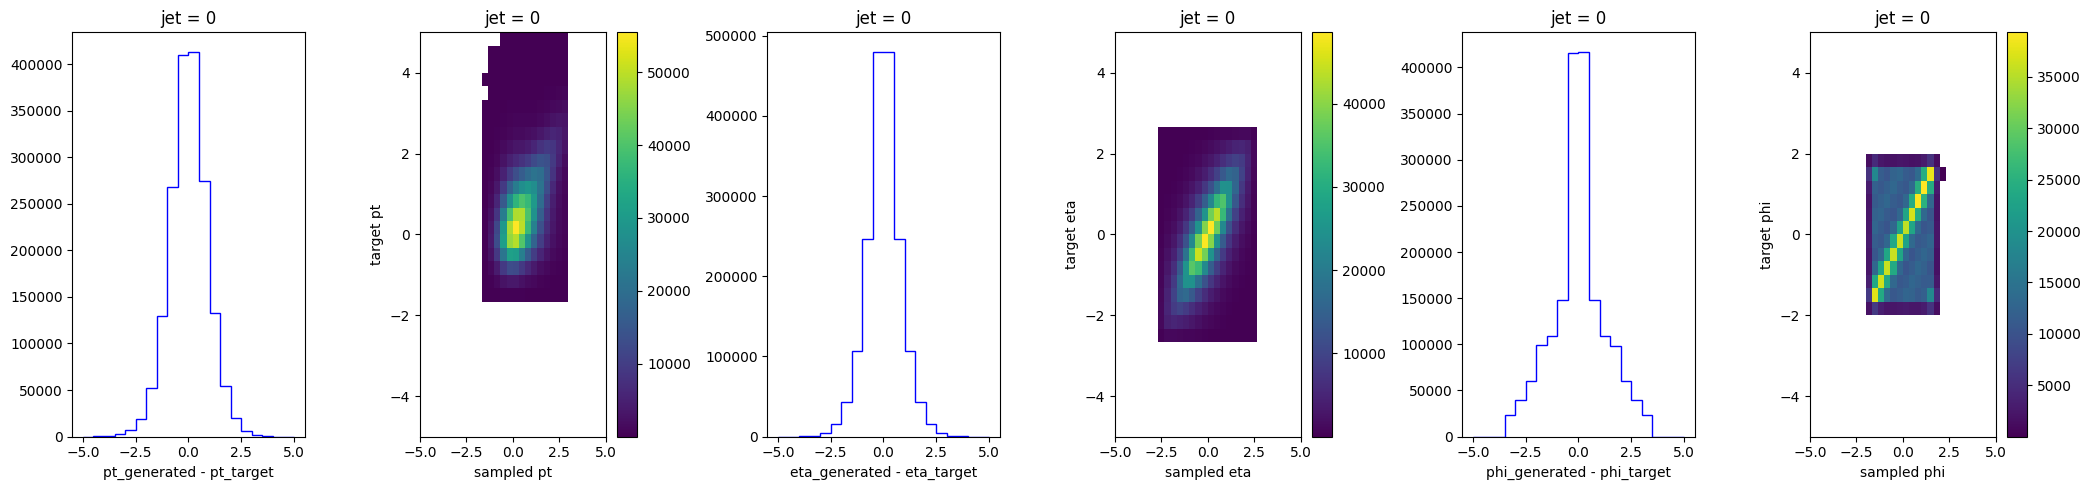

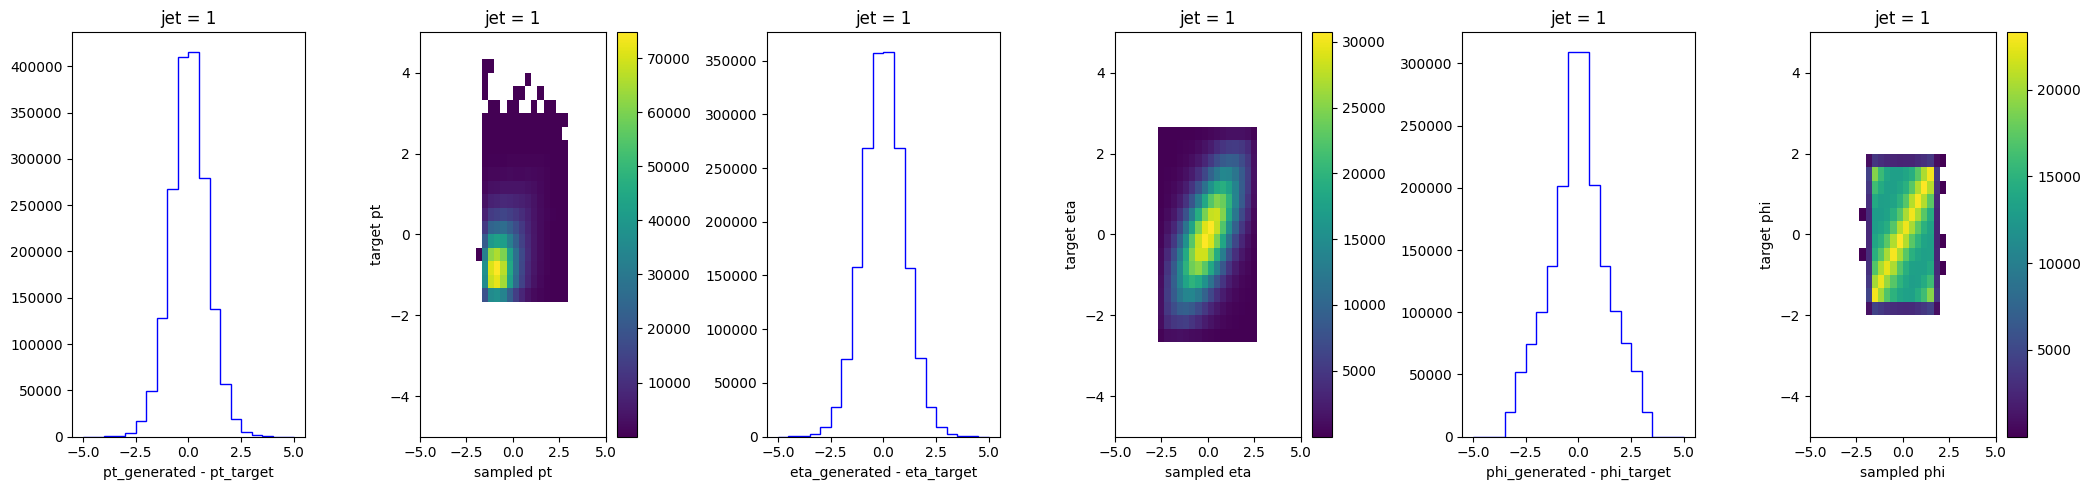

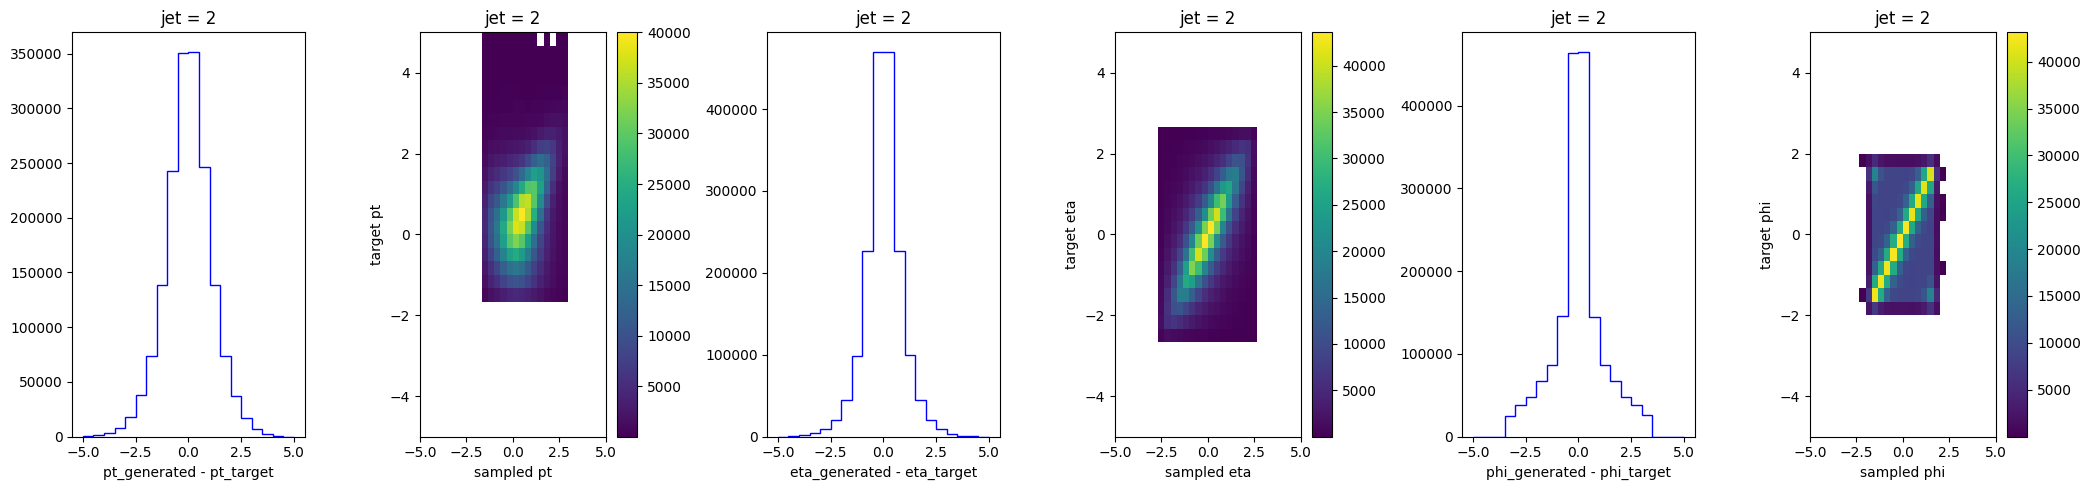

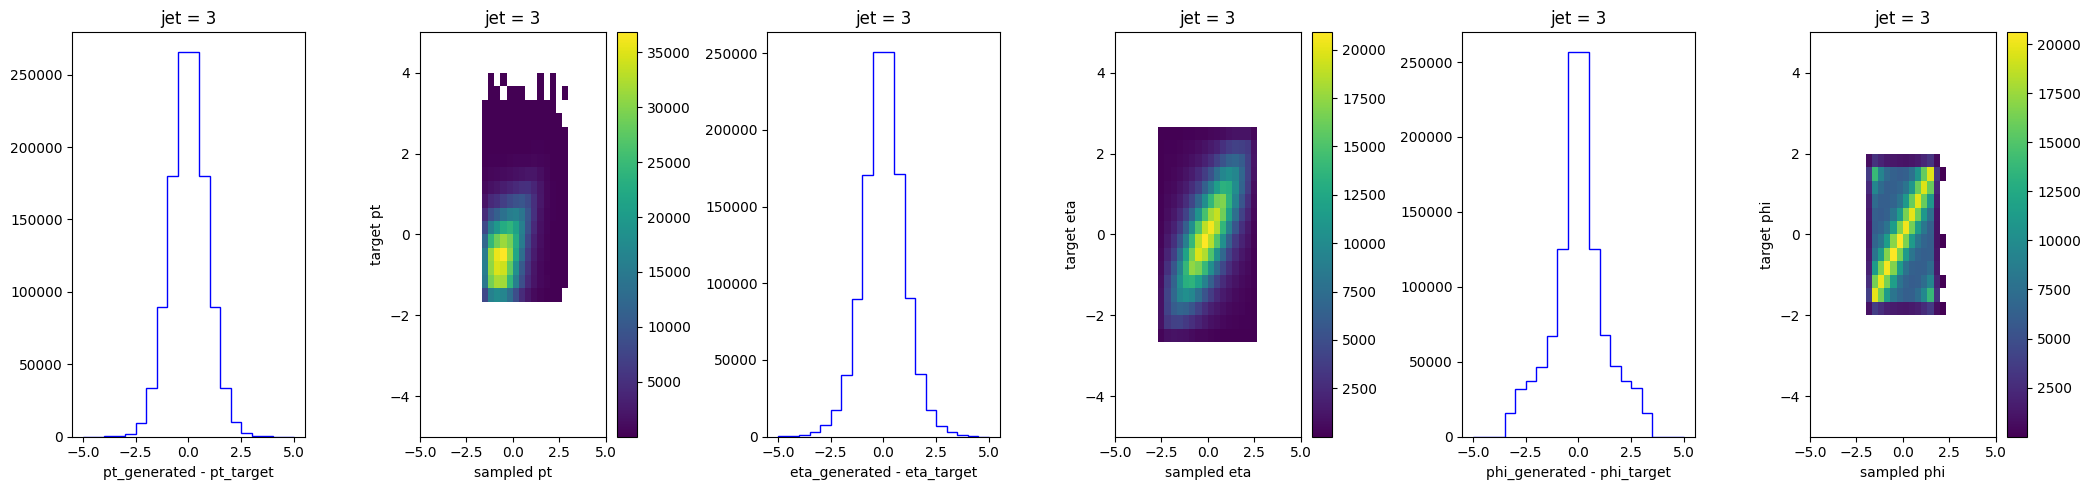

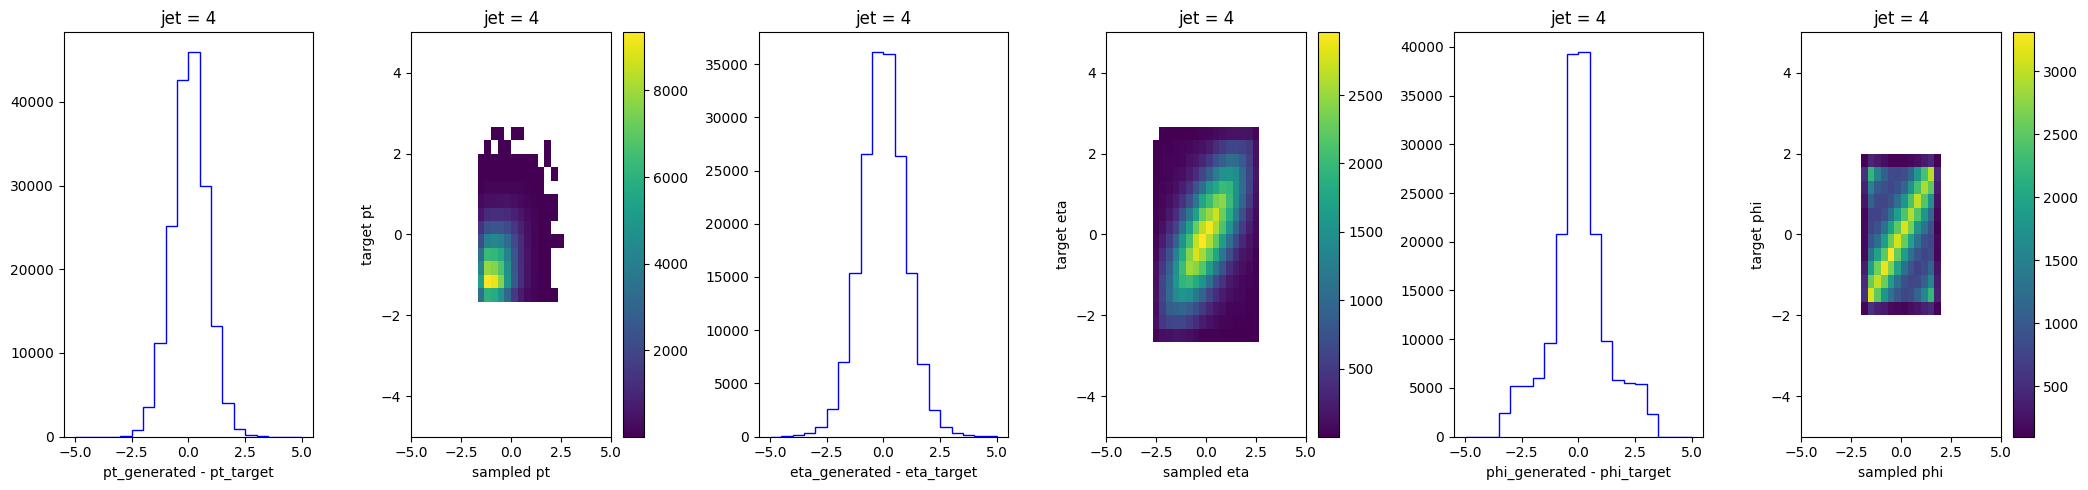

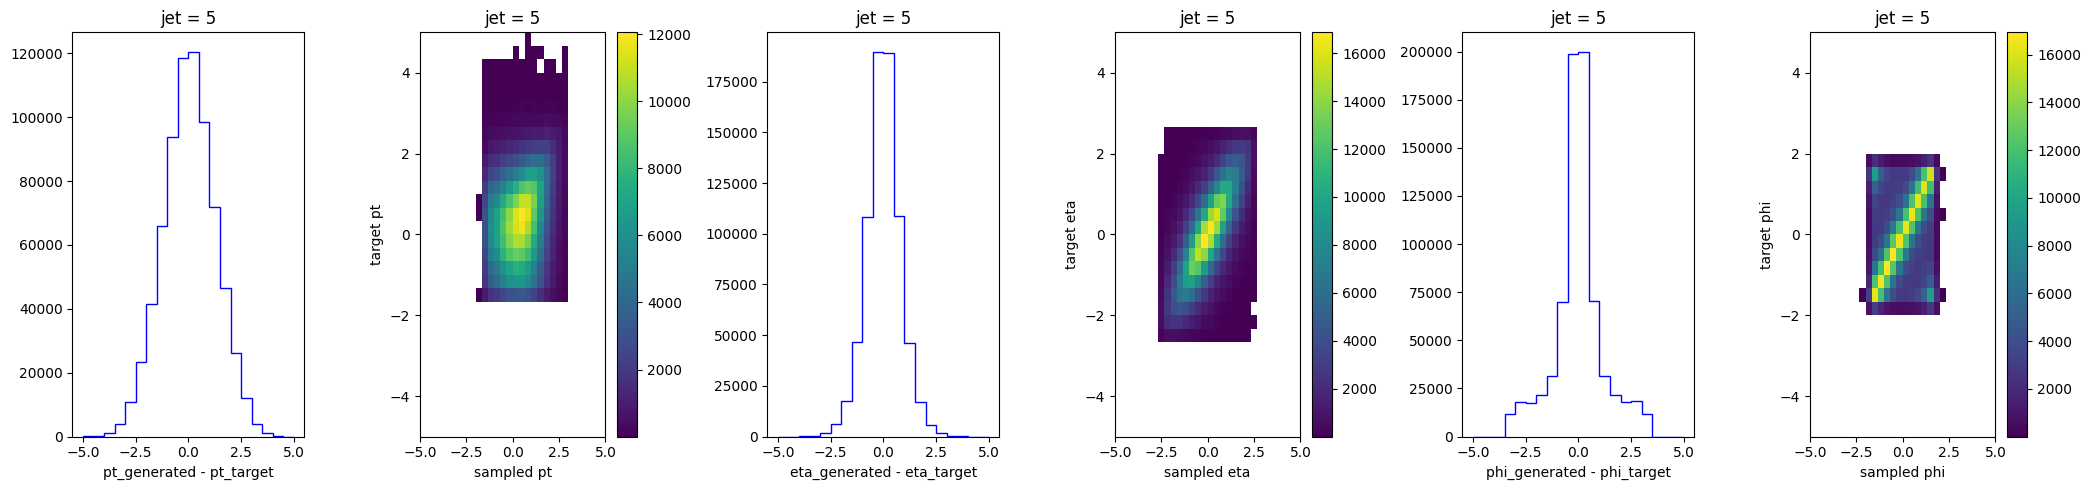

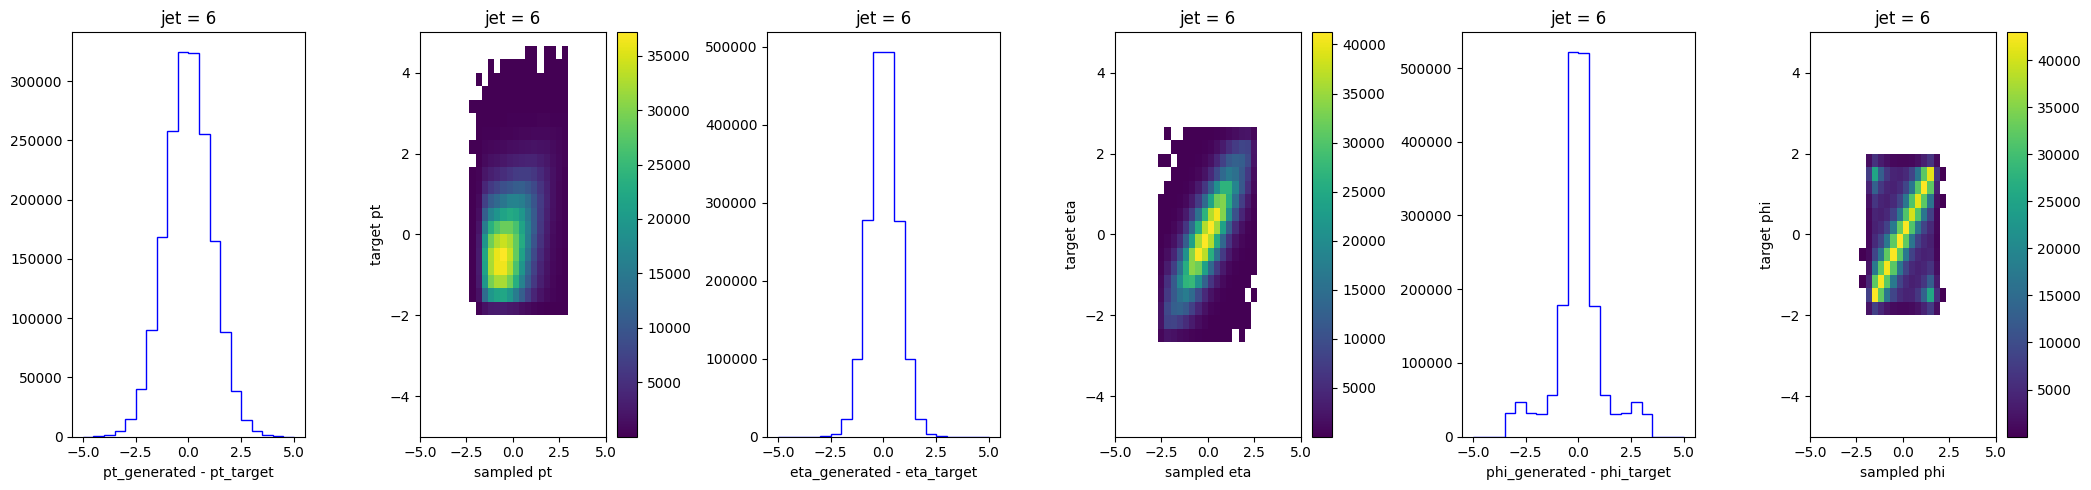

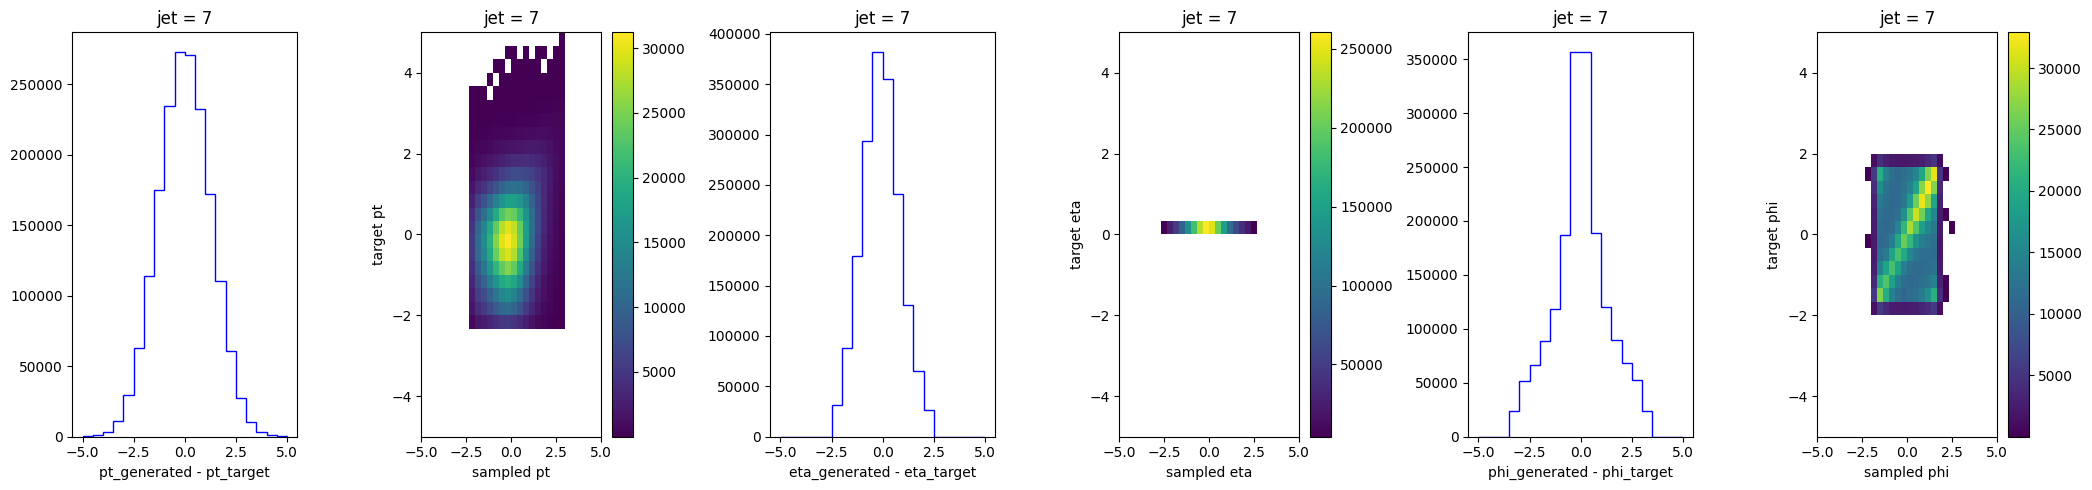

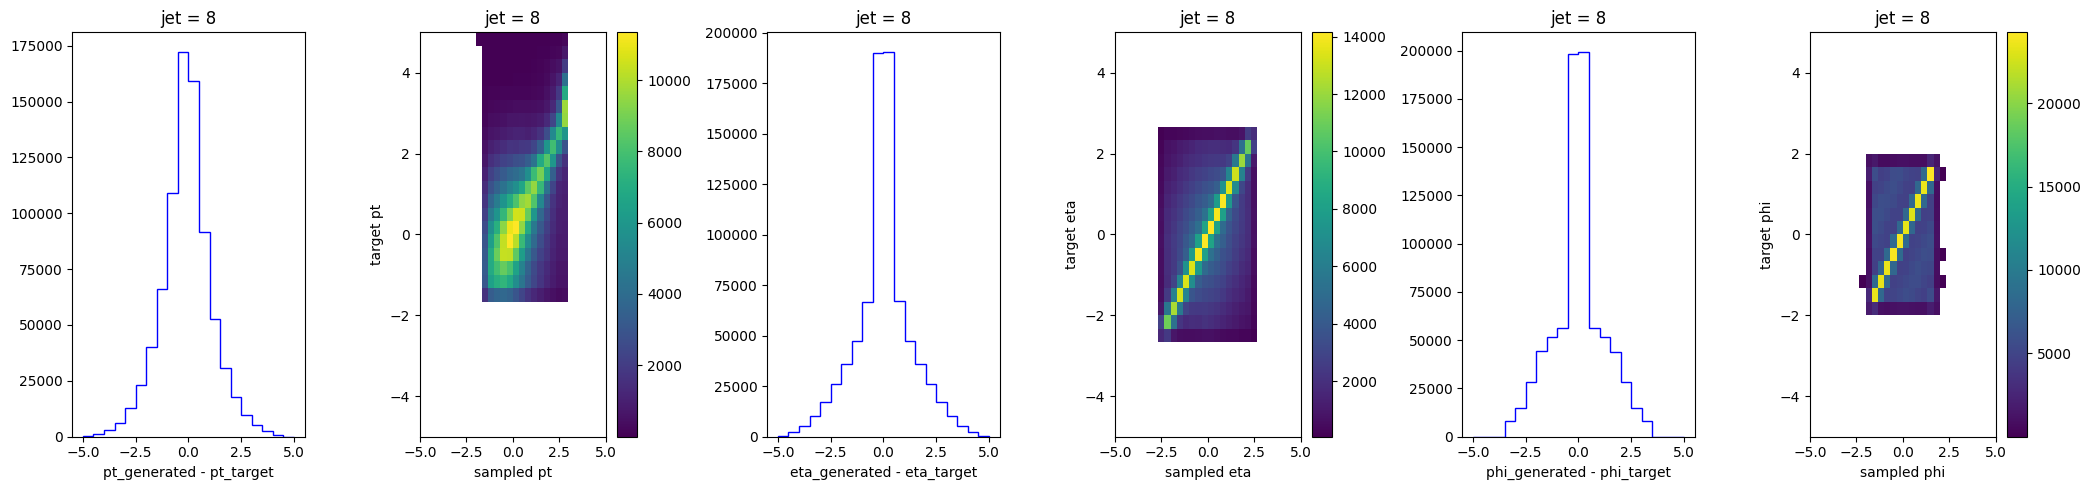

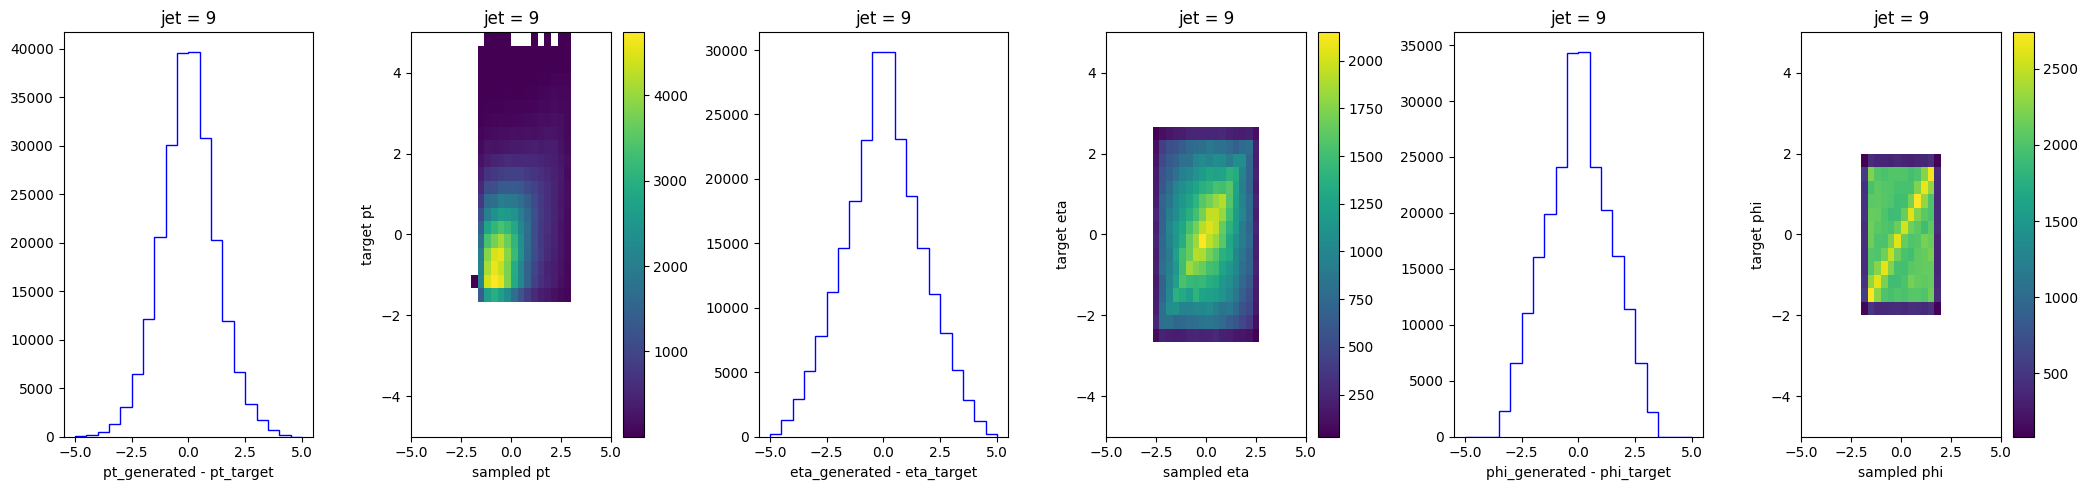

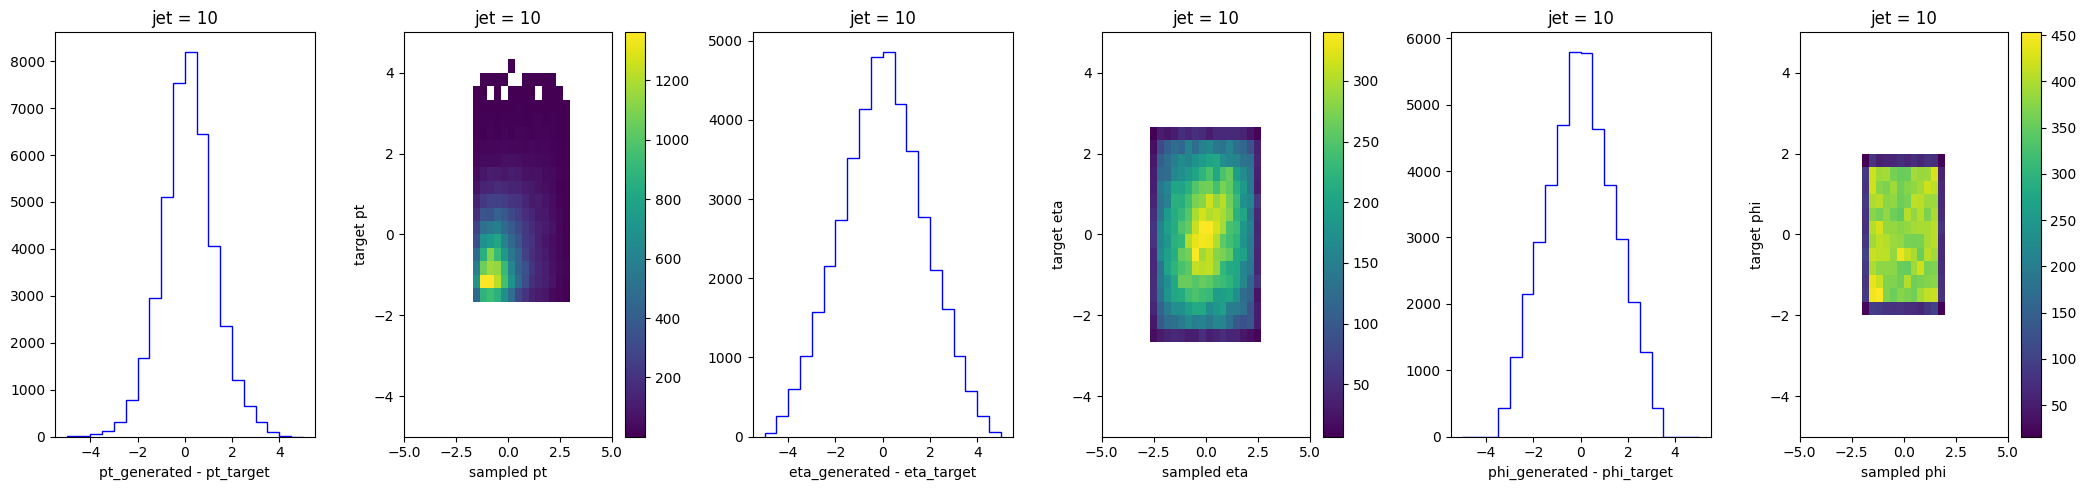

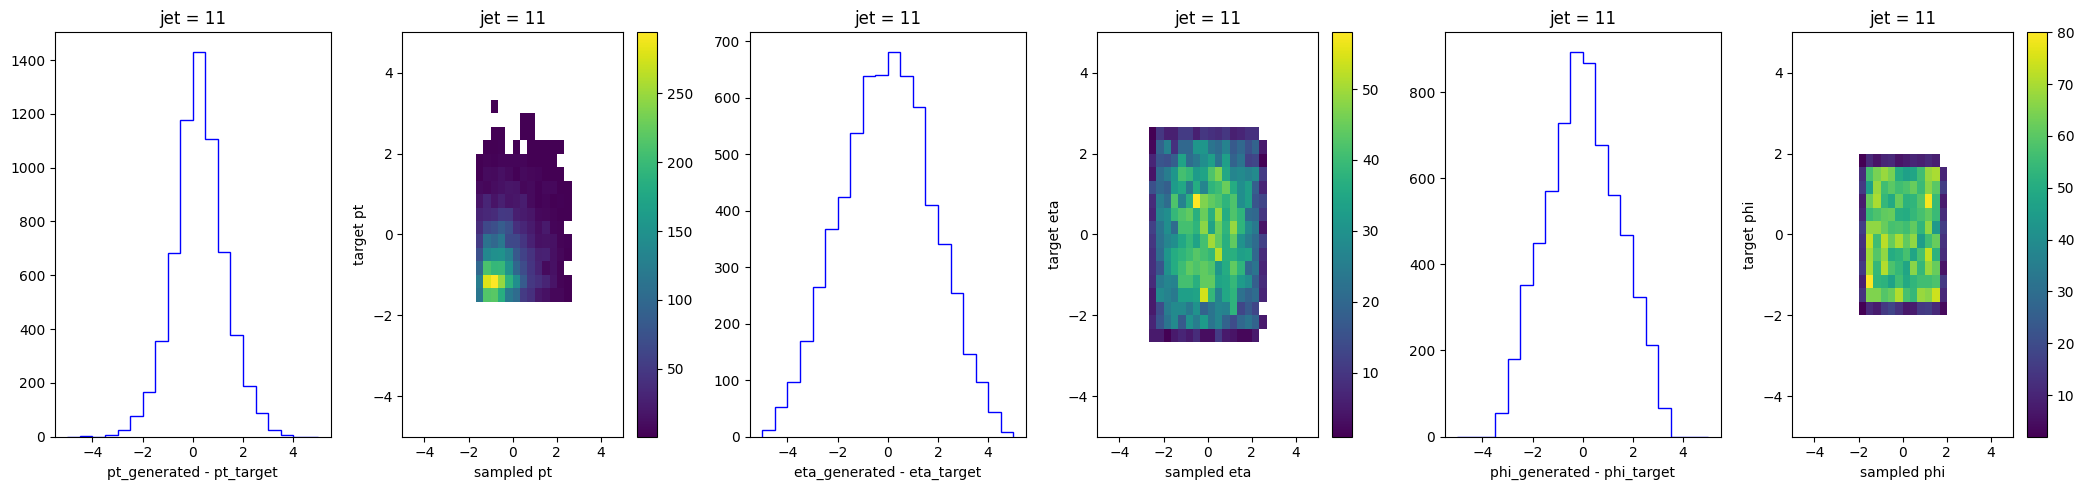

In [12]:
for i in range(12):
    sampling_print(sampledEvent, scaledLogRecoSpanet, maskReco, plotJets=i, onlyExistElem=True)

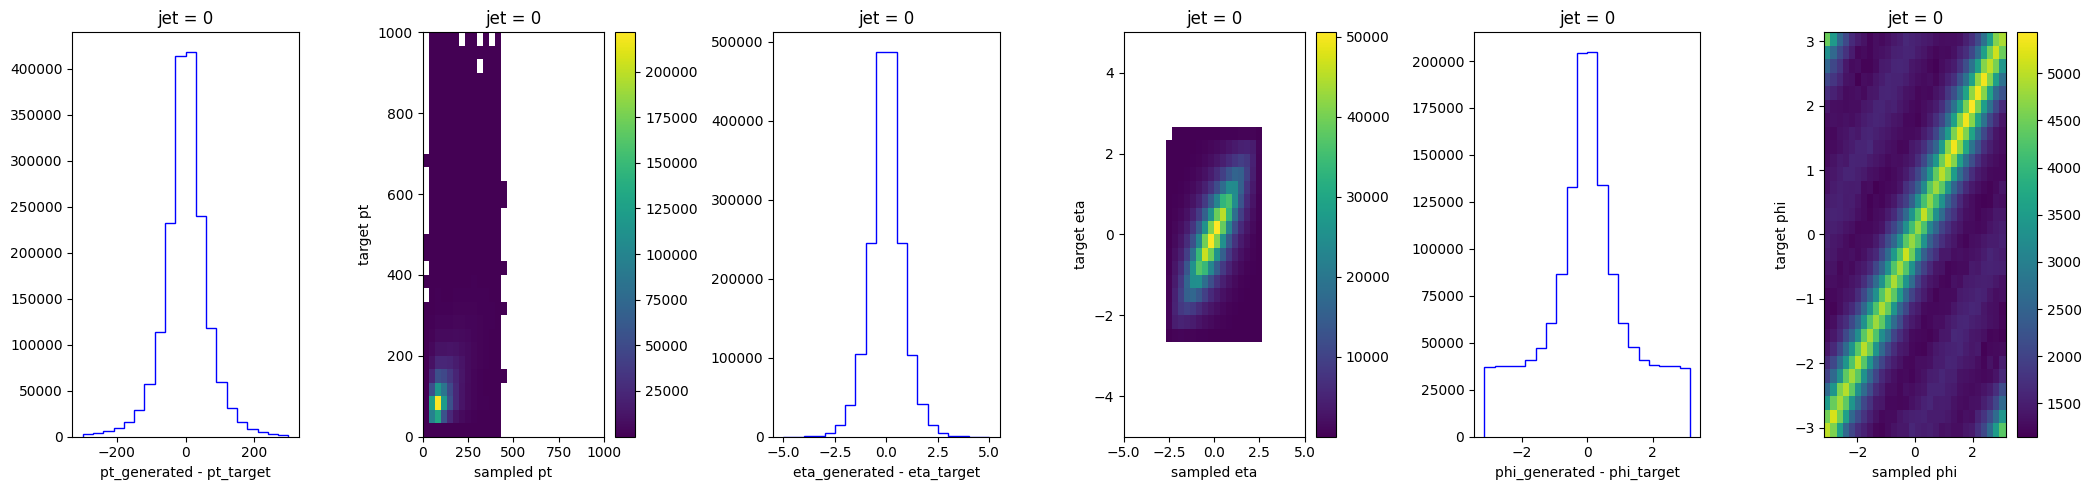

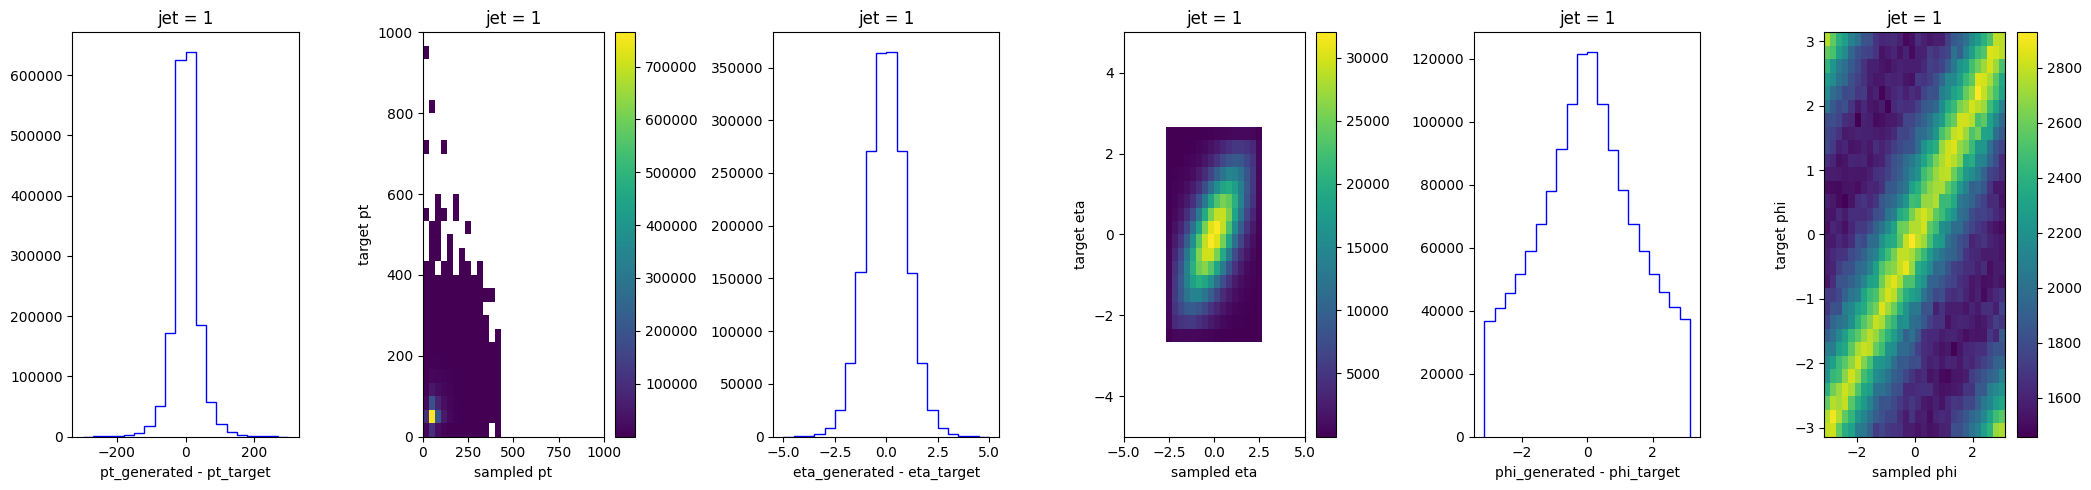

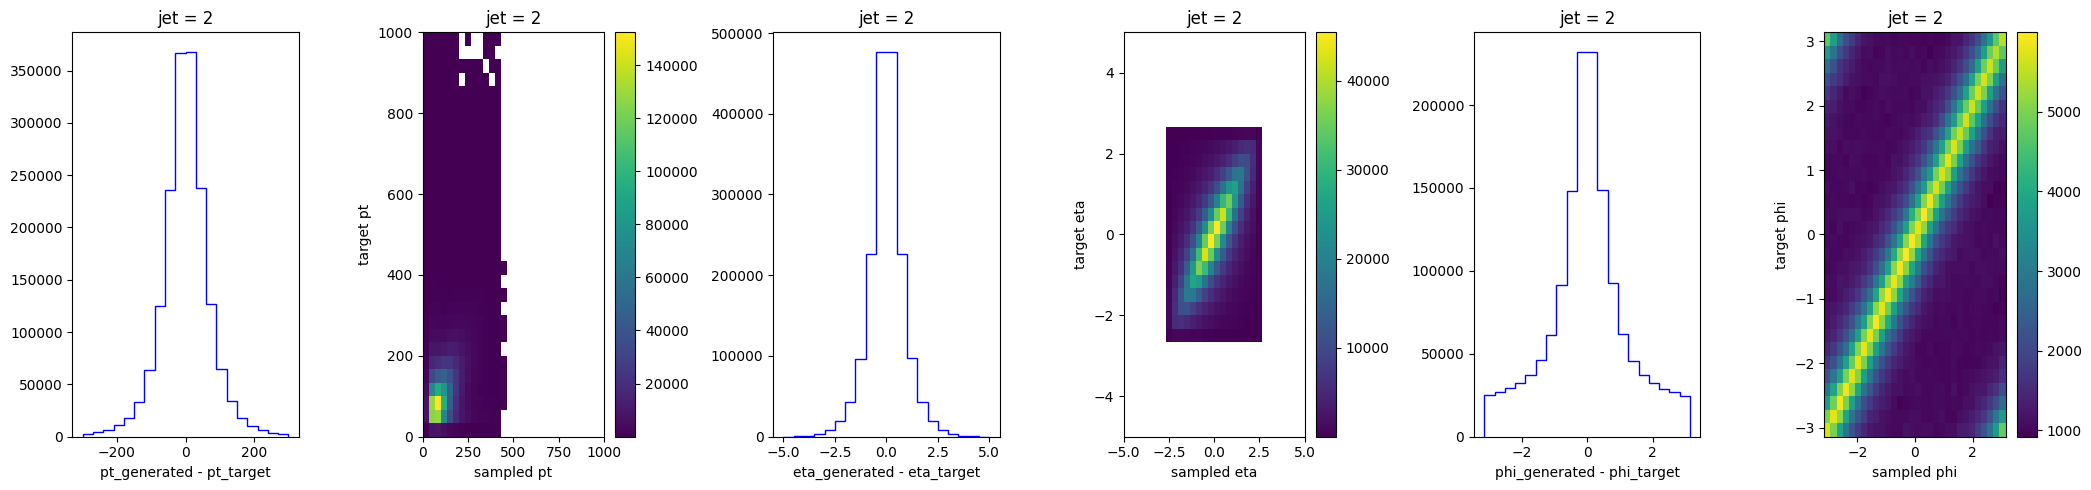

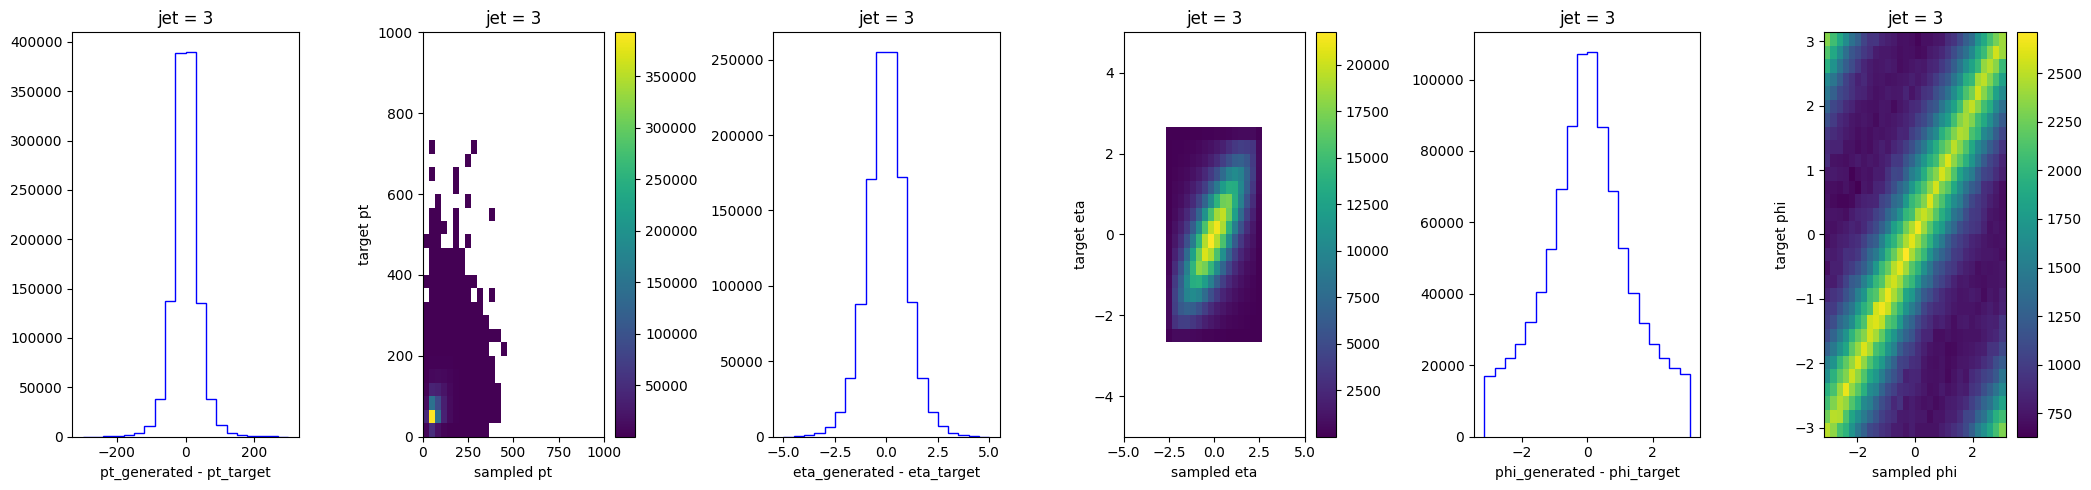

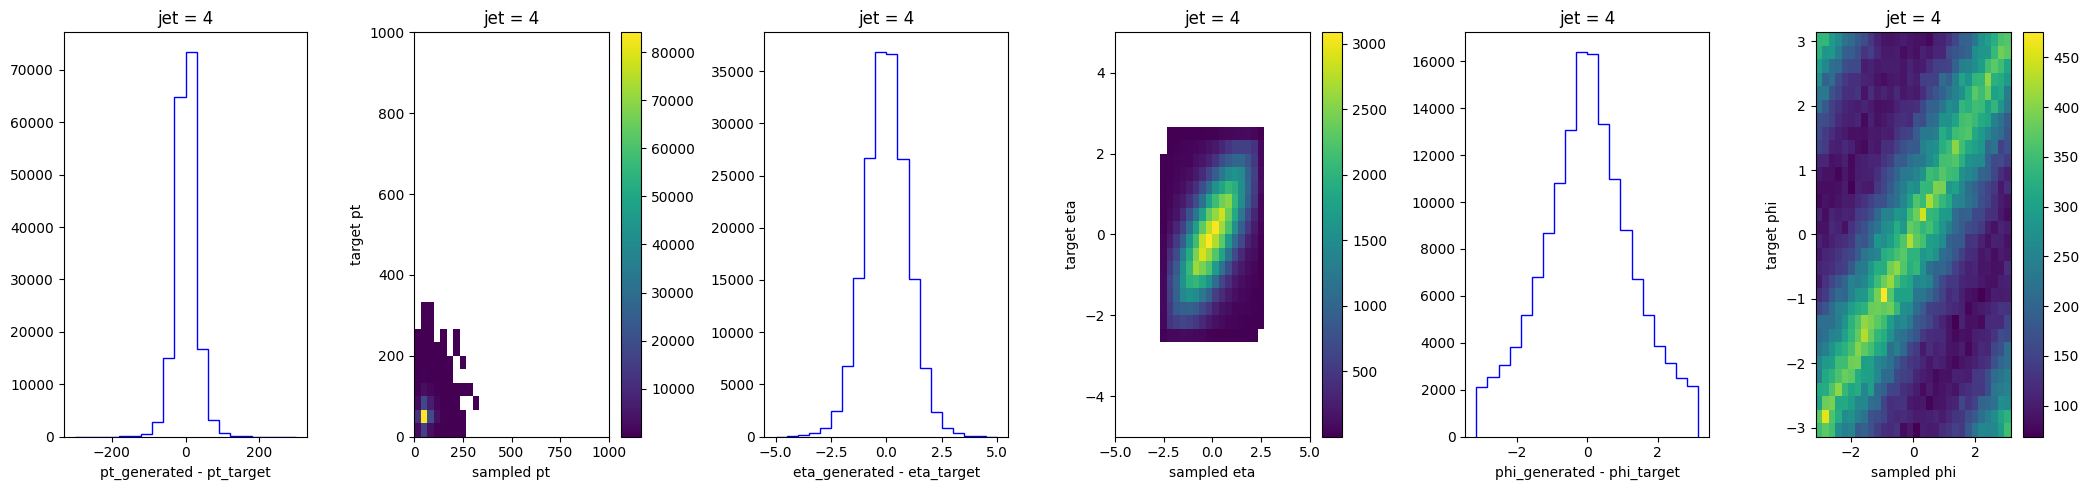

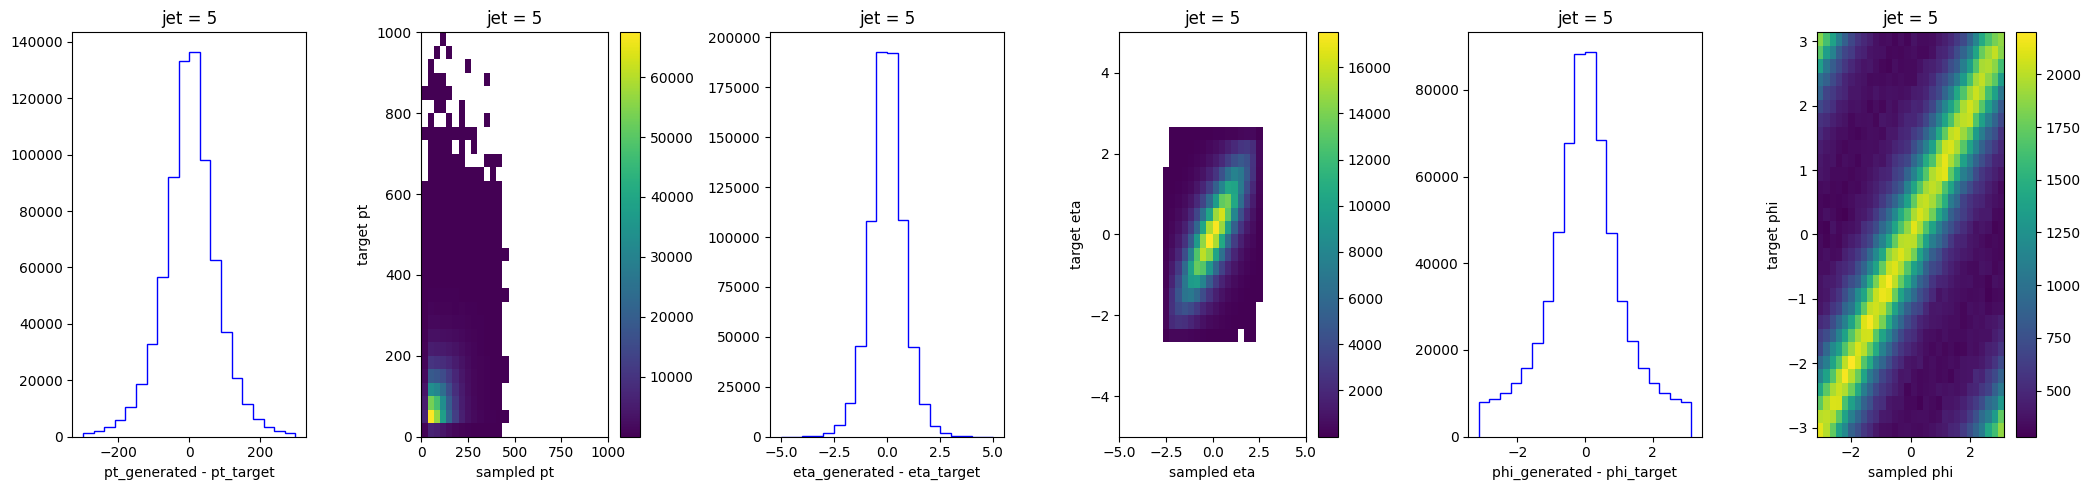

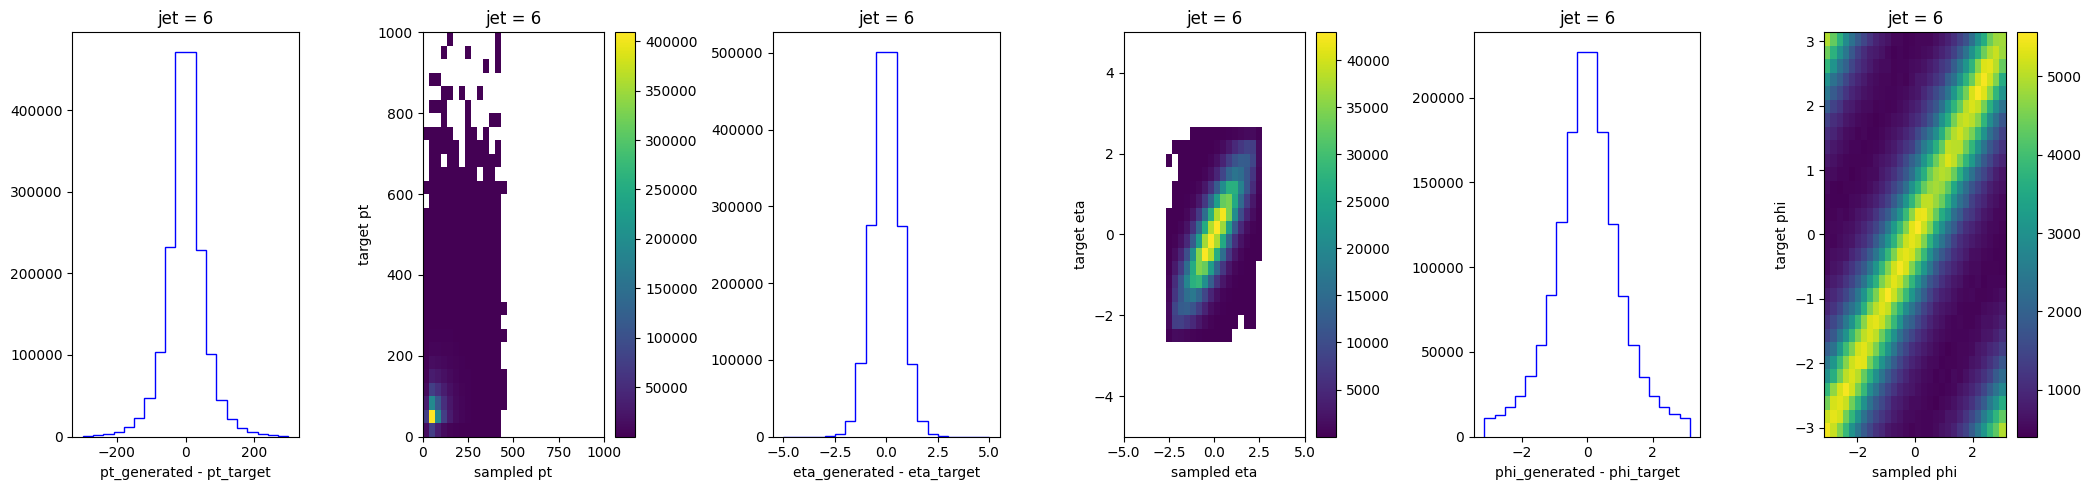

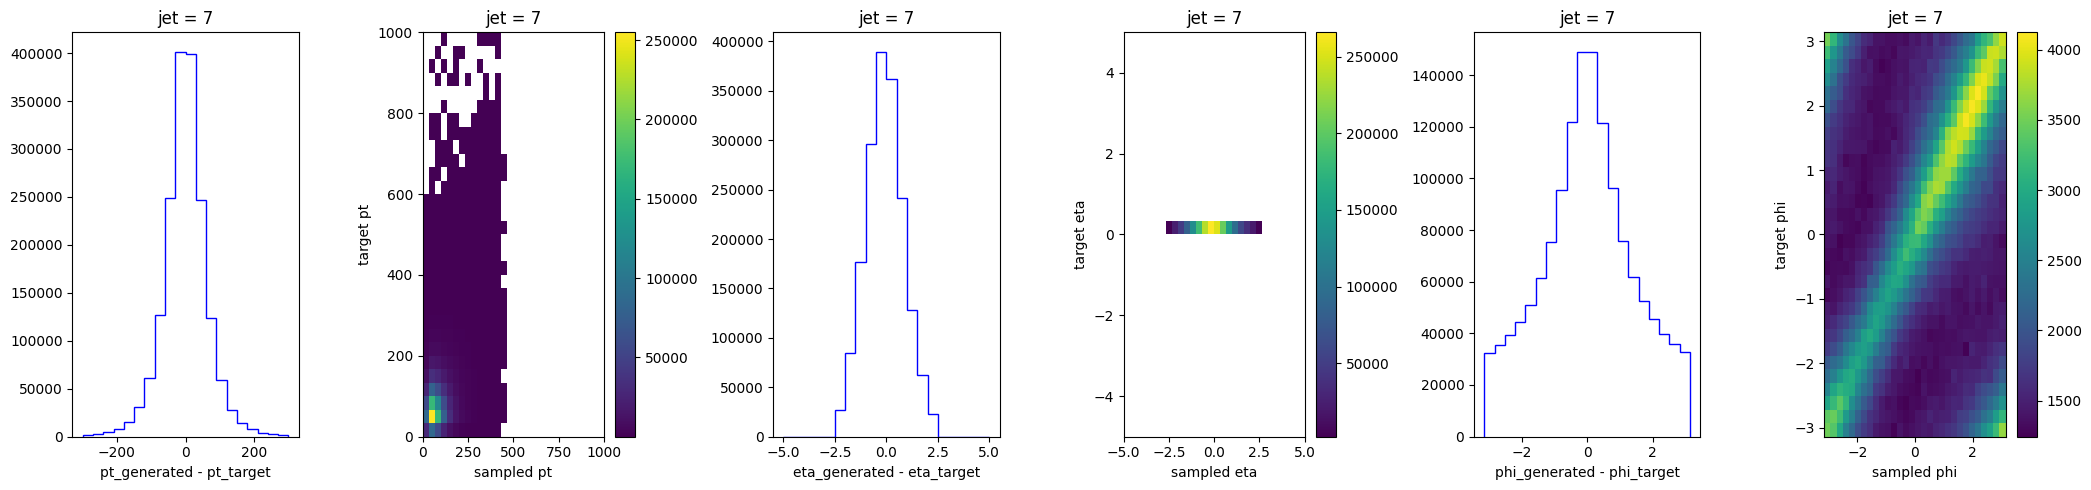

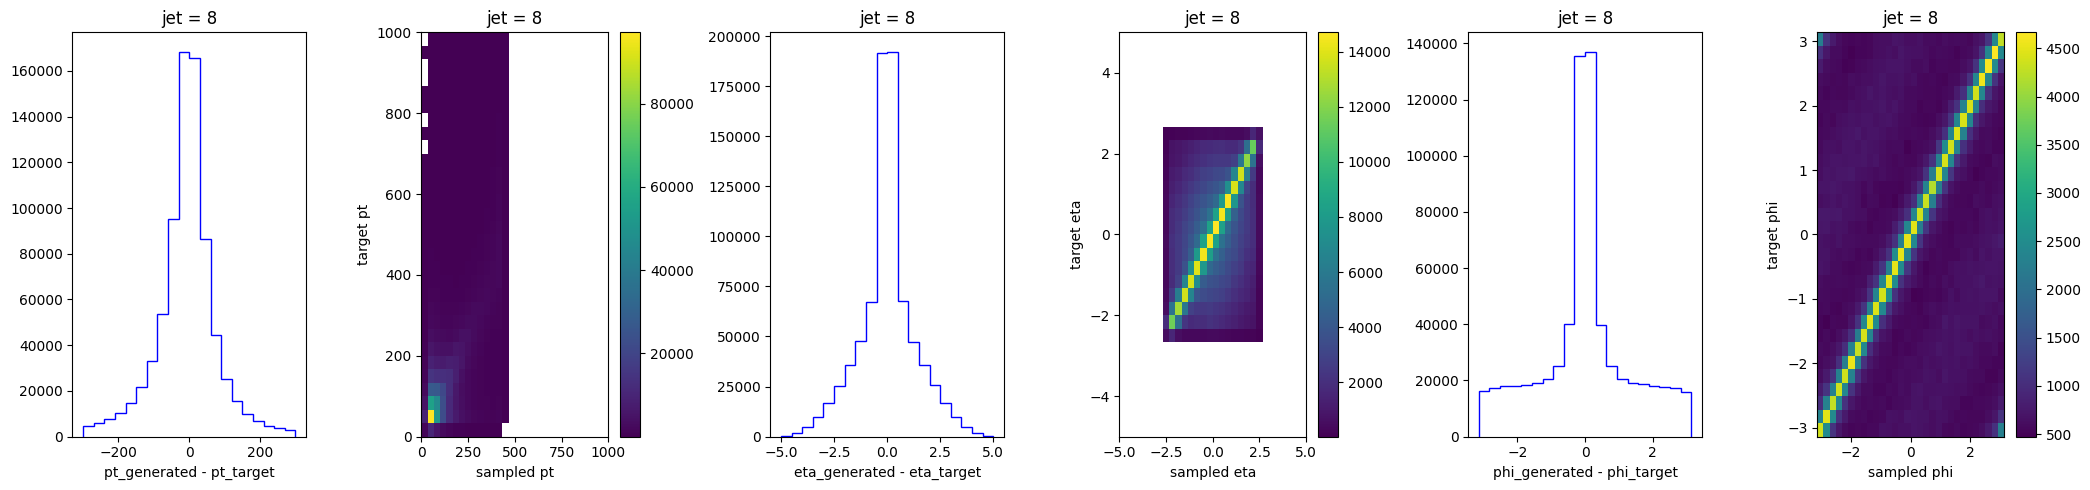

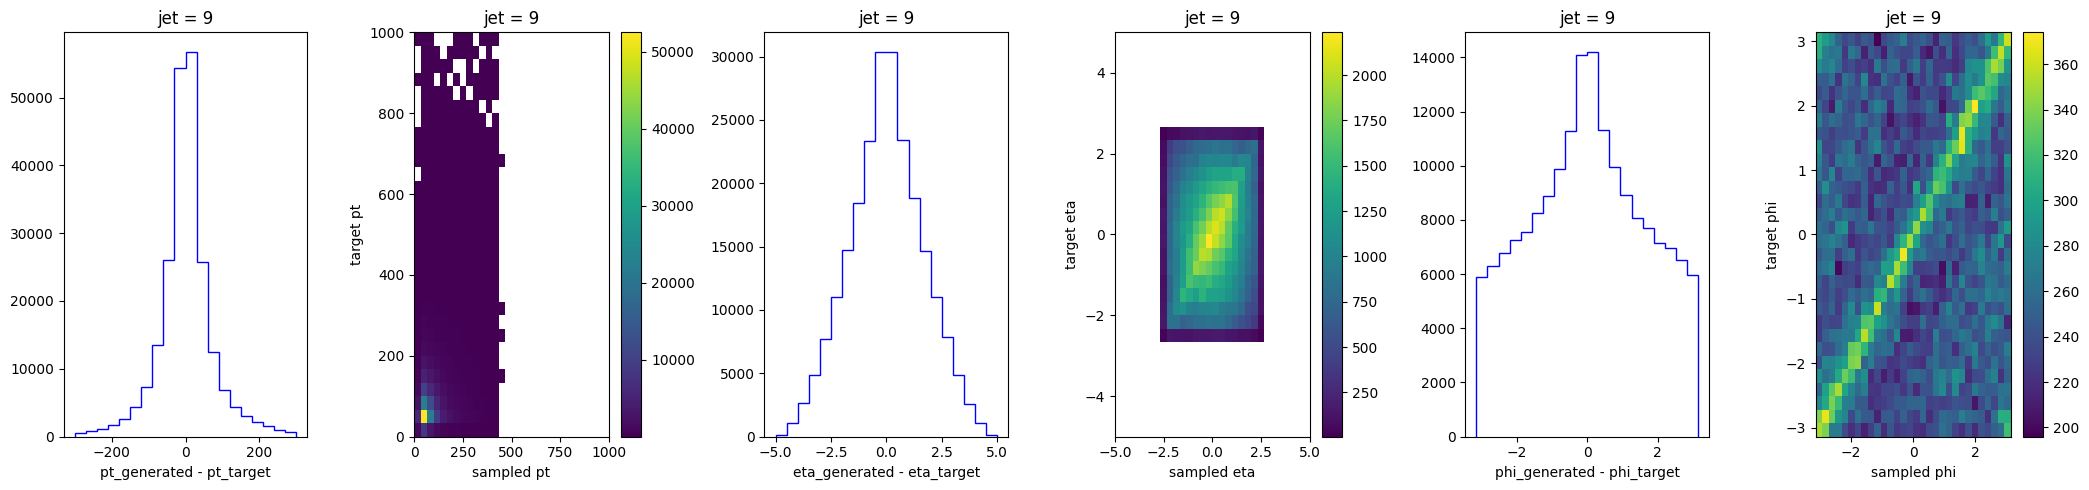

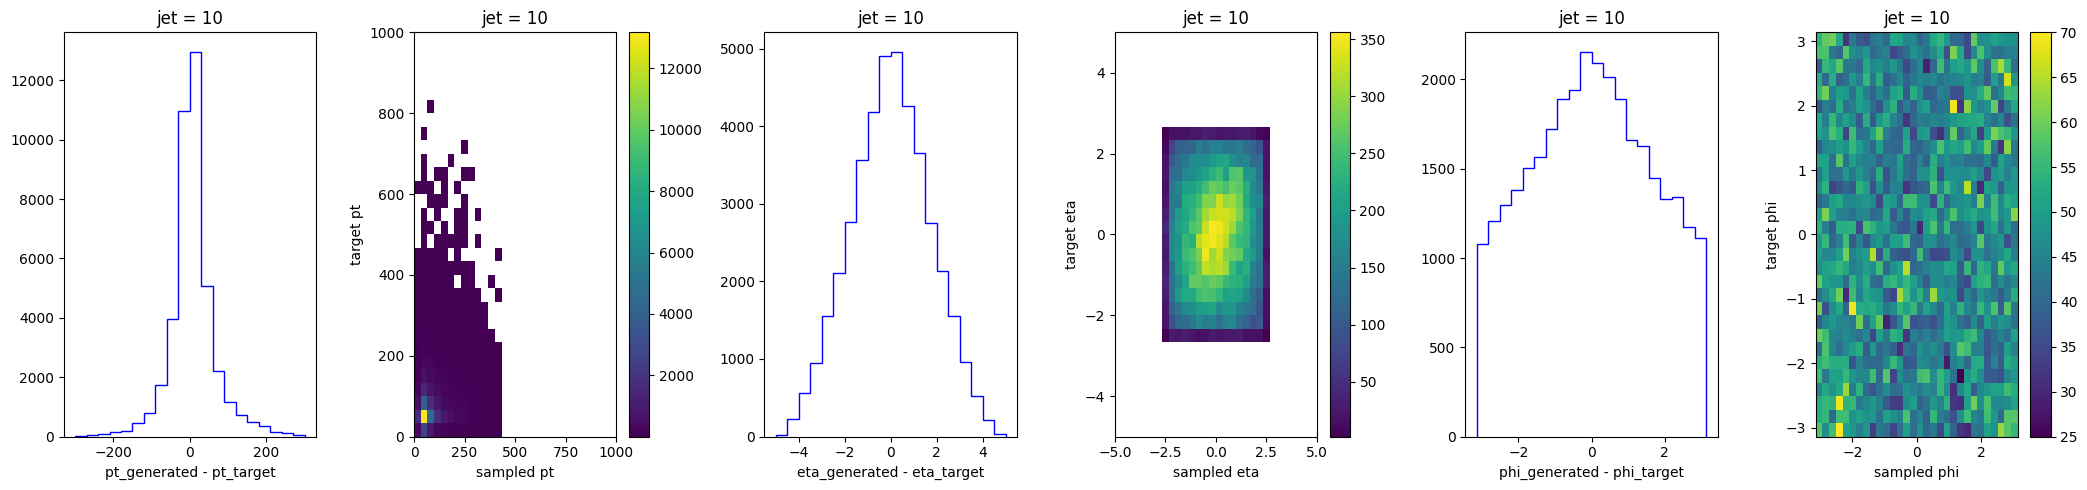

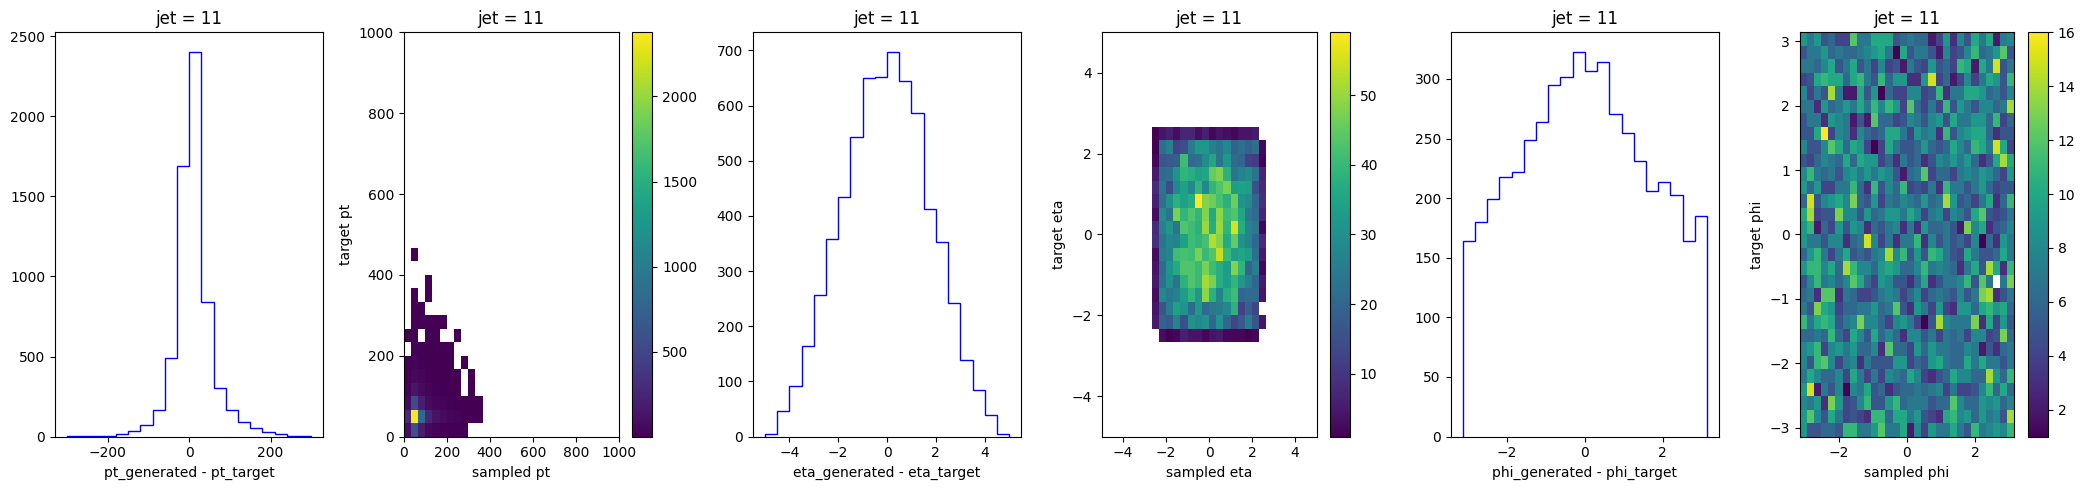

In [13]:
unscaled_target, unscaled_sampled = unscale_var(log_mean_reco, log_std_reco, scaledLogRecoSpanet, sampledEvent)
for i in range(12):
    sampling_print_unscaled(unscaled_sampled, unscaled_target, maskReco, plotJets=i, onlyExistElem=True)

In [14]:
print(unscaled_sampled[0,:,1])
print(unscaled_target[0,:,1])

tensor([ 81.7846,  58.0448,  33.3192,  41.3569,  41.3569, 125.5937,  42.4545,
         56.2759,  41.3569,  41.3569,  41.3569,  41.3569])
tensor([75.1250, 42.3125, 80.7500, 62.8125, 39.0312, 41.3569, 33.0788, 87.1505,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000])


# Sampled Event 2

In [21]:
model_dir = '/eos/user/a/adpetre/www/ttHbbAnalysis/MEMFlow/models_archive/transferFlow_paperVersion-pretrained_2ndVersion_onlyExist_v7/Transfer_Flow_Paper_pretrained_v2_transfer_flow_2nd_2nd_DiagNormal_NoTransf1_NoBins80_DNN:5_512'
path_to_conf = model_dir + '/config_transfer_flow_2nd_2nd.yaml'
path_to_sample = model_dir + '/sampled_jets.pt'

In [22]:
sampledEvent = torch.load(path_to_sample, map_location=device)
print(sampledEvent.shape)
print(scaledLogRecoSpanet.shape)

torch.Size([1792125, 12, 5])
torch.Size([1792125, 21, 9])


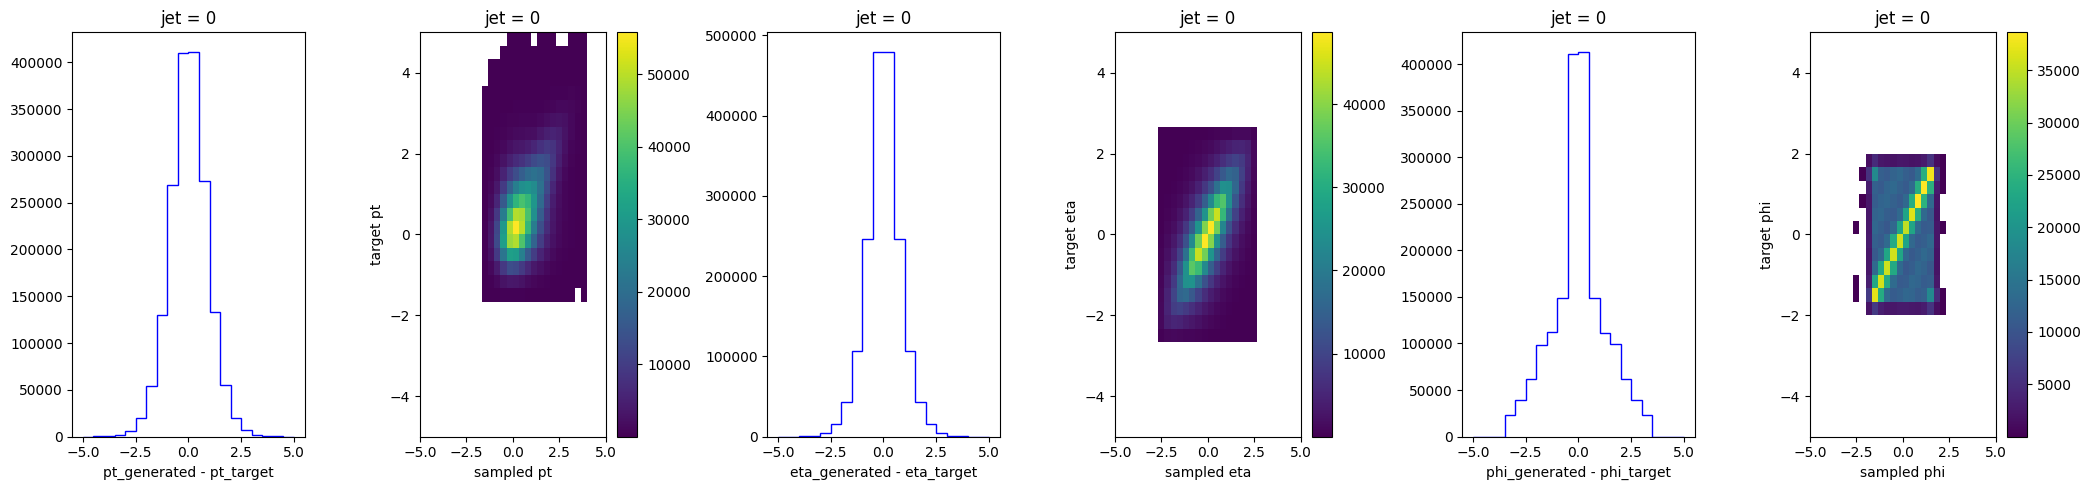

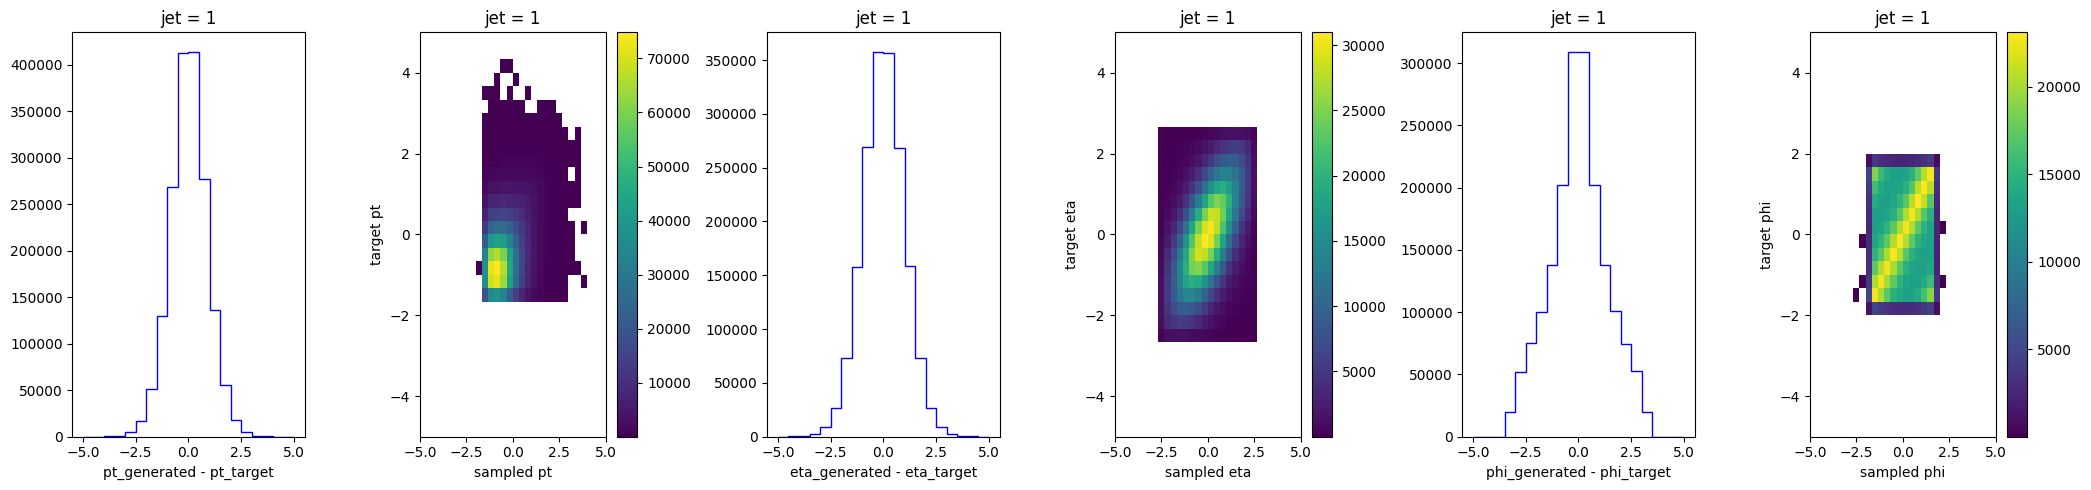

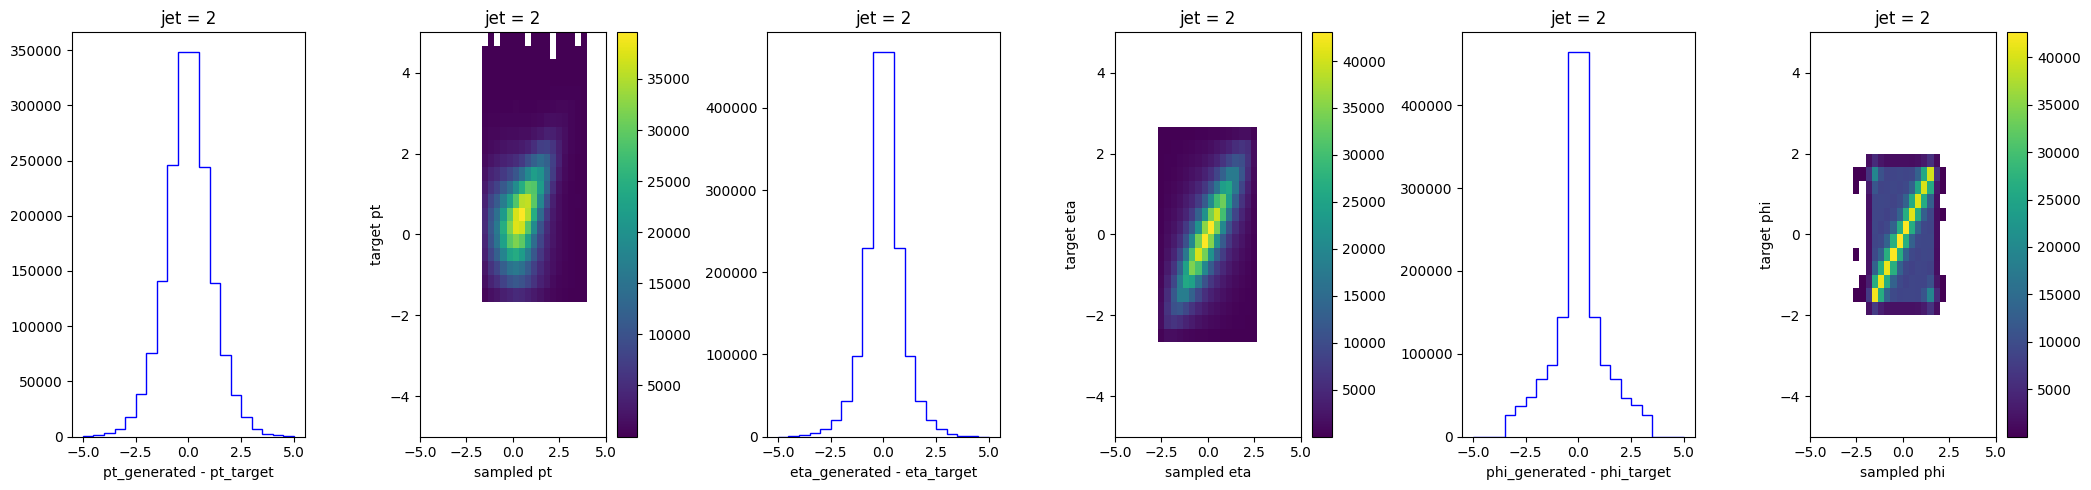

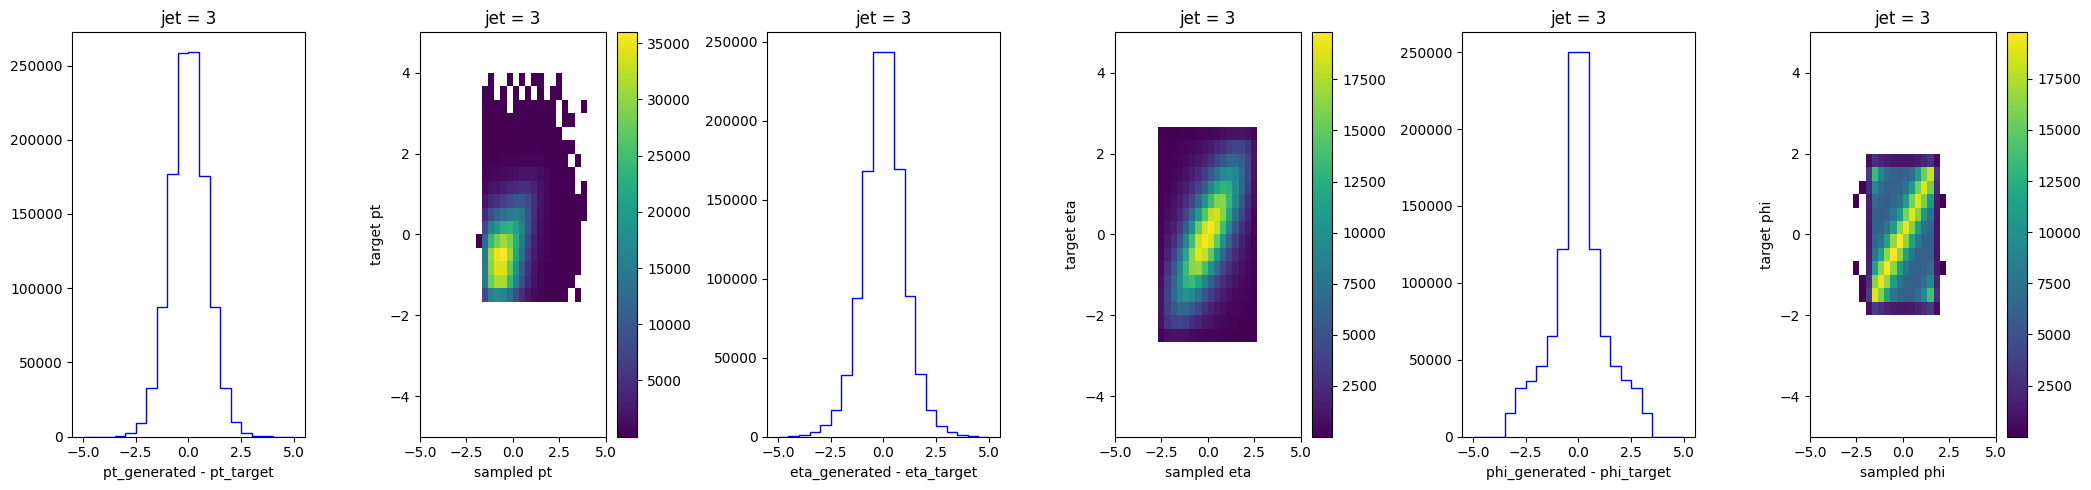

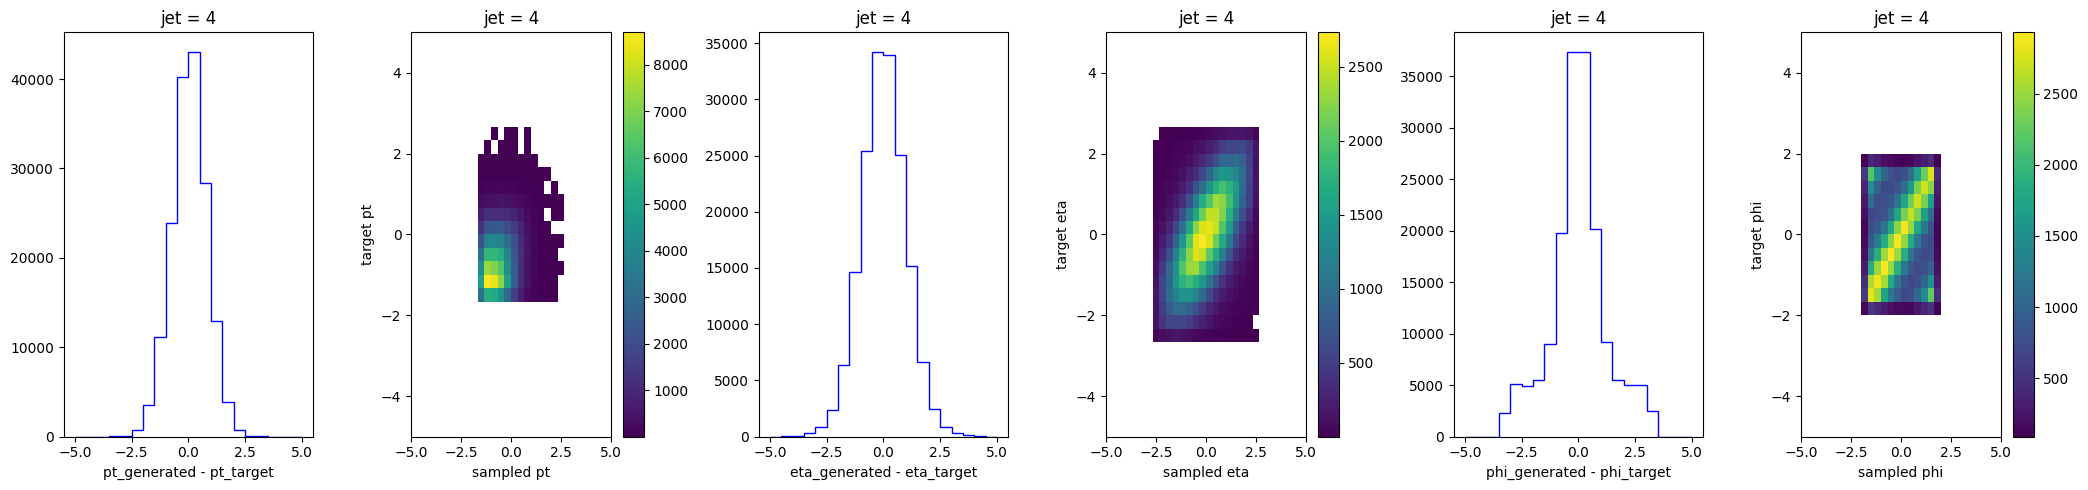

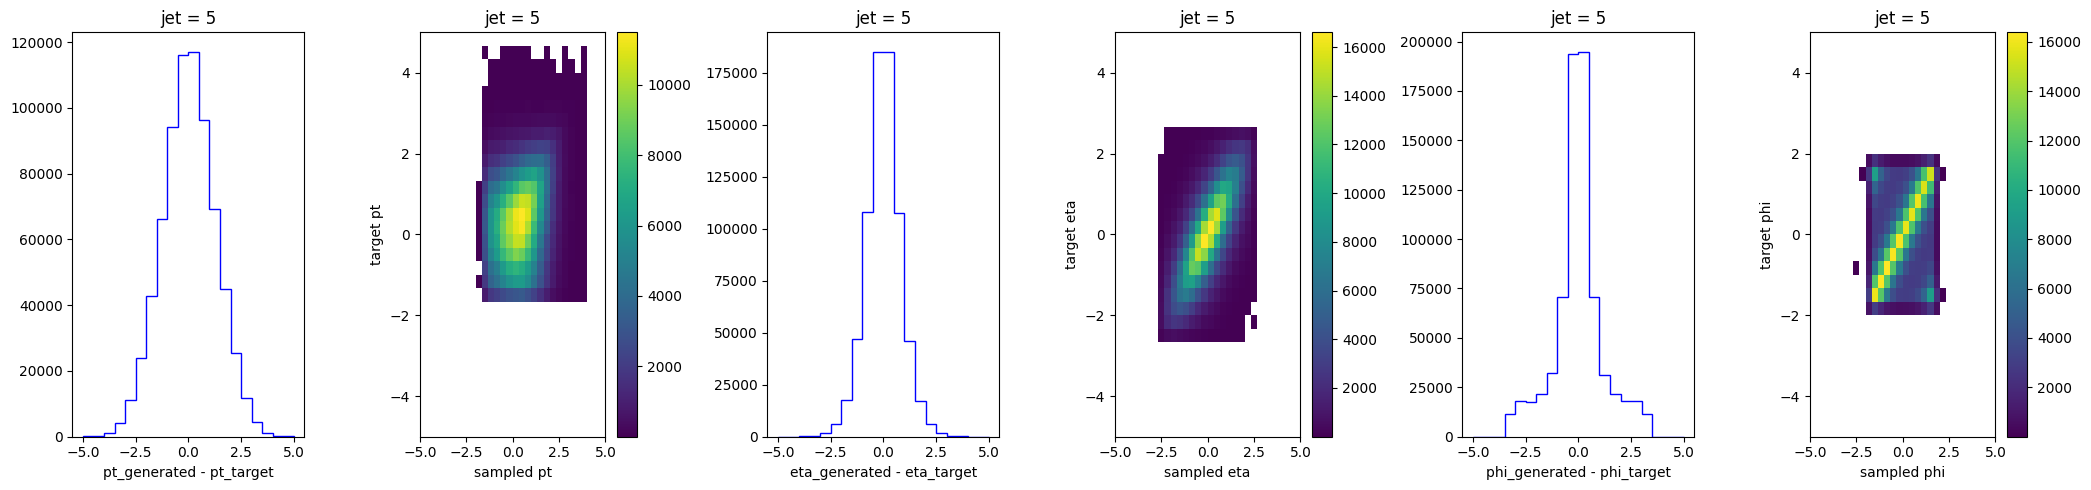

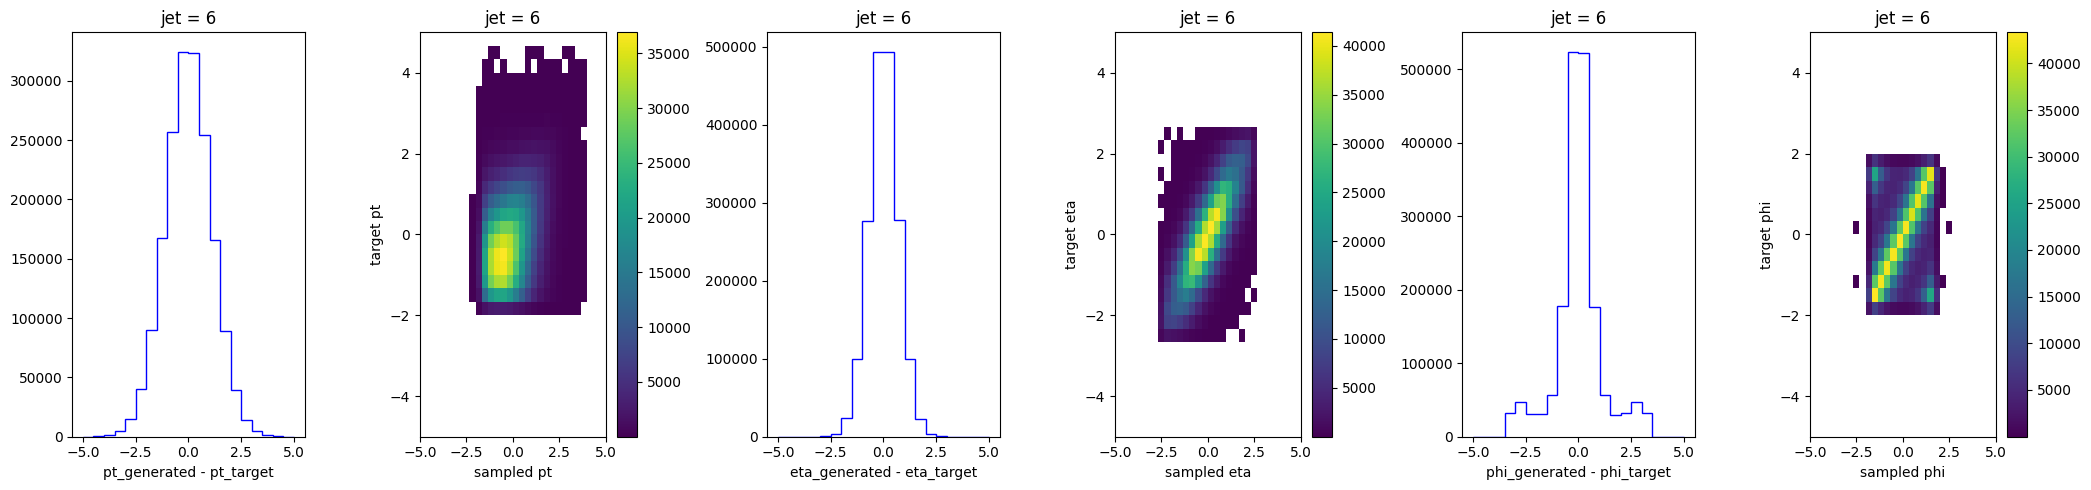

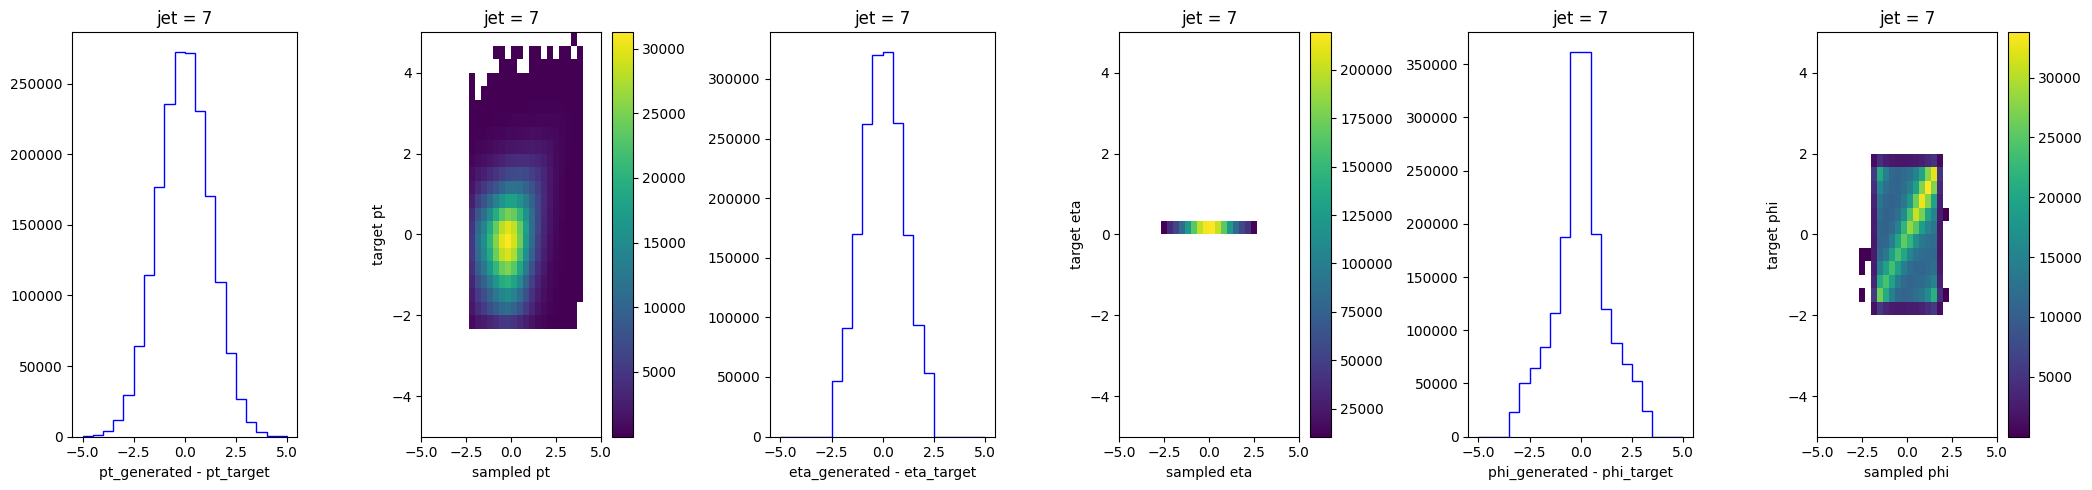

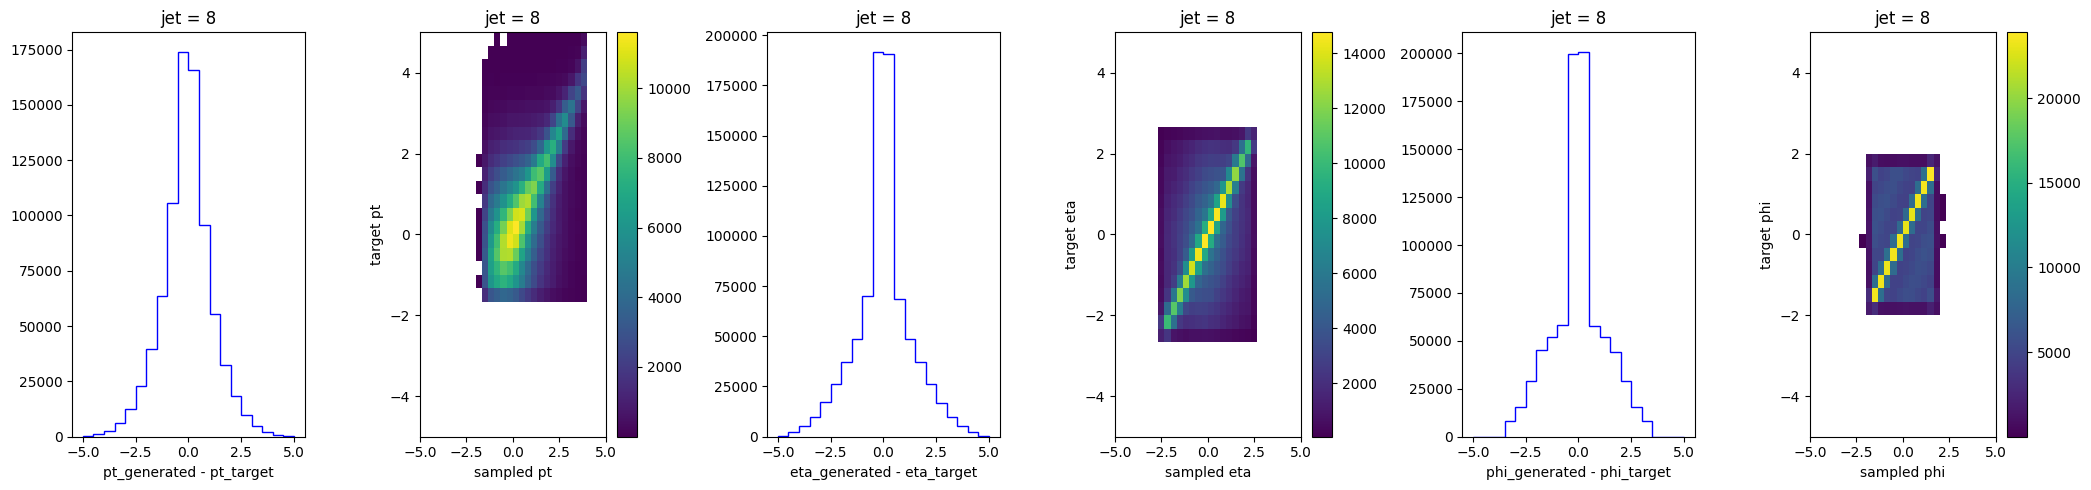

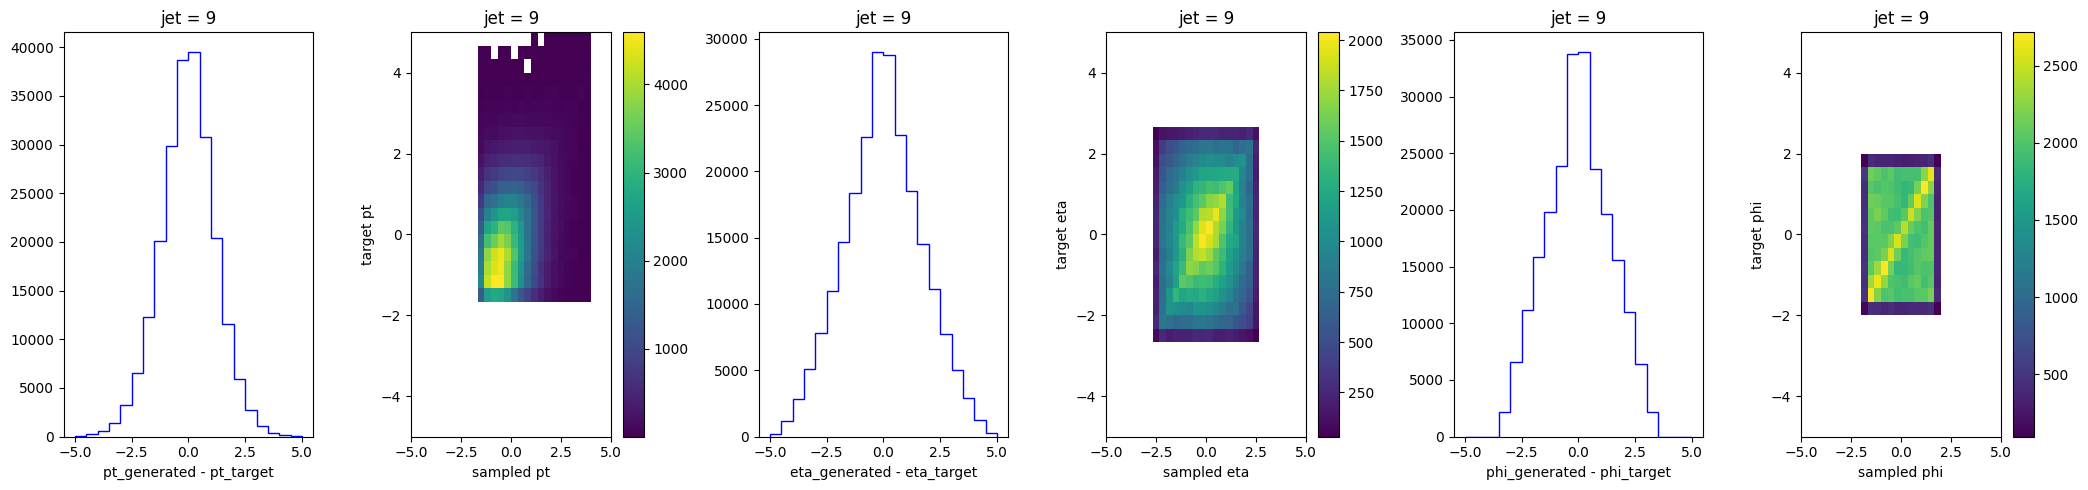

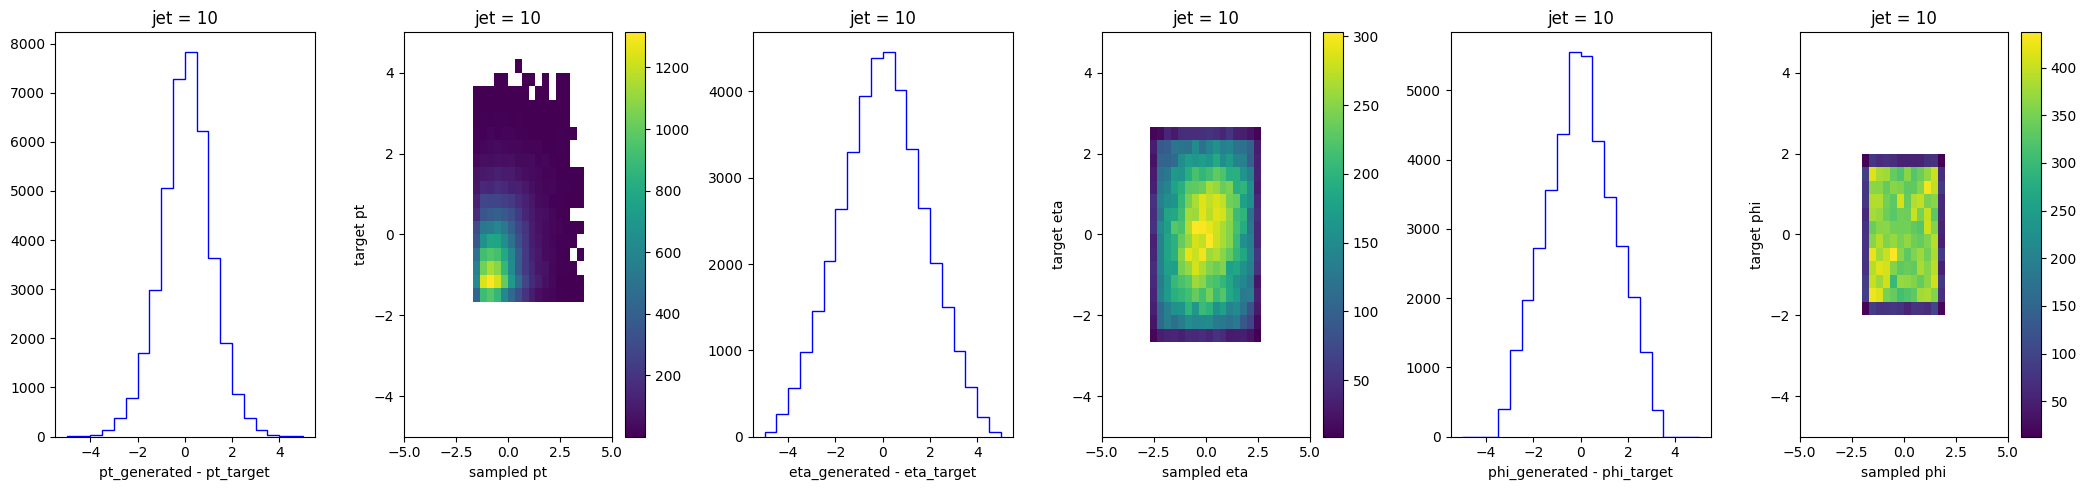

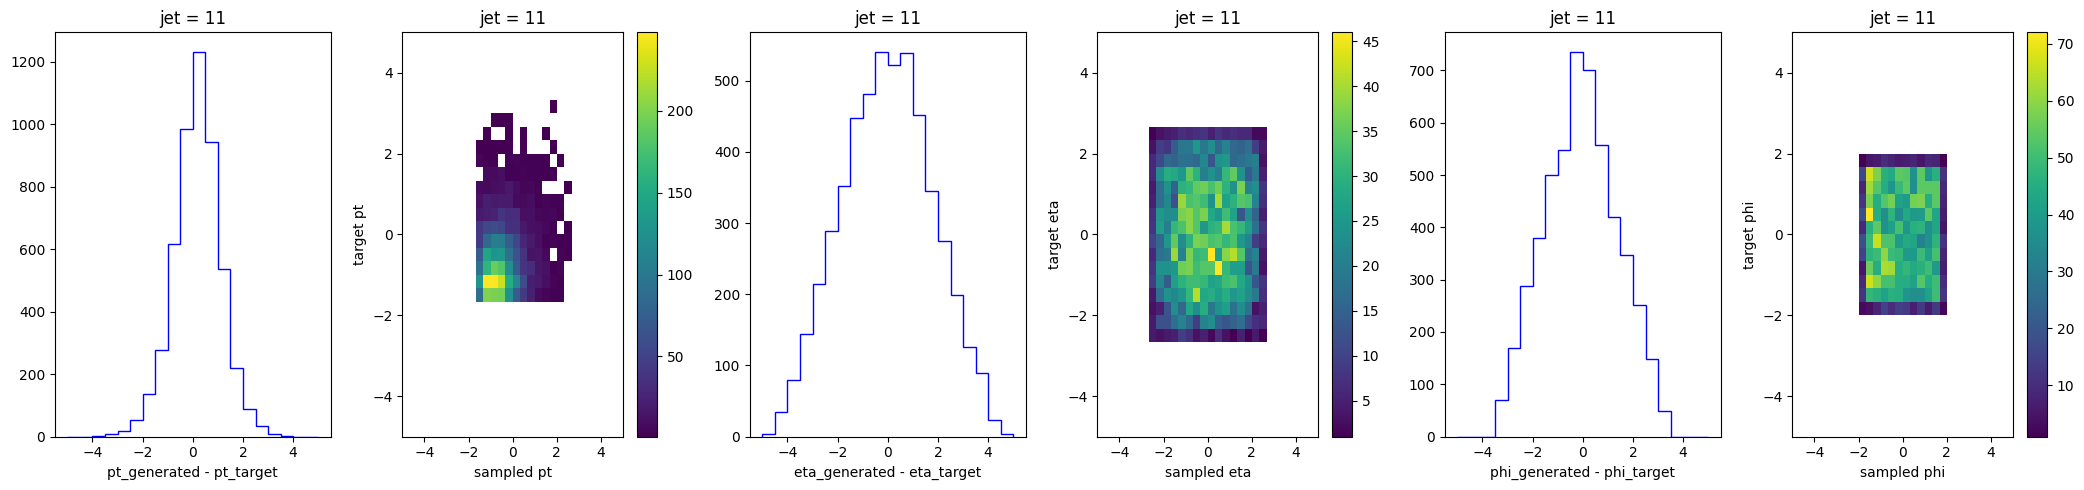

In [17]:
for i in range(12):
    sampling_print(sampledEvent, scaledLogRecoSpanet, maskReco, plotJets=i, onlyExistElem=True)

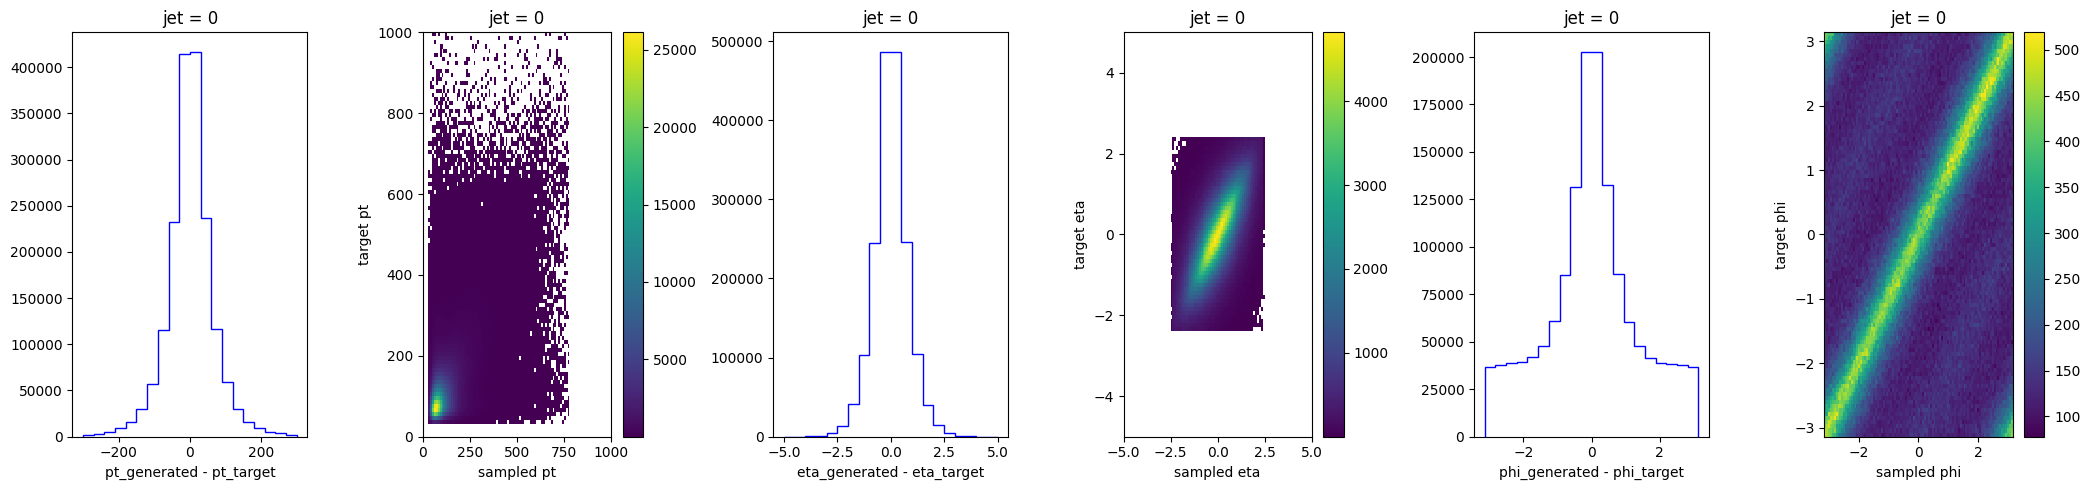

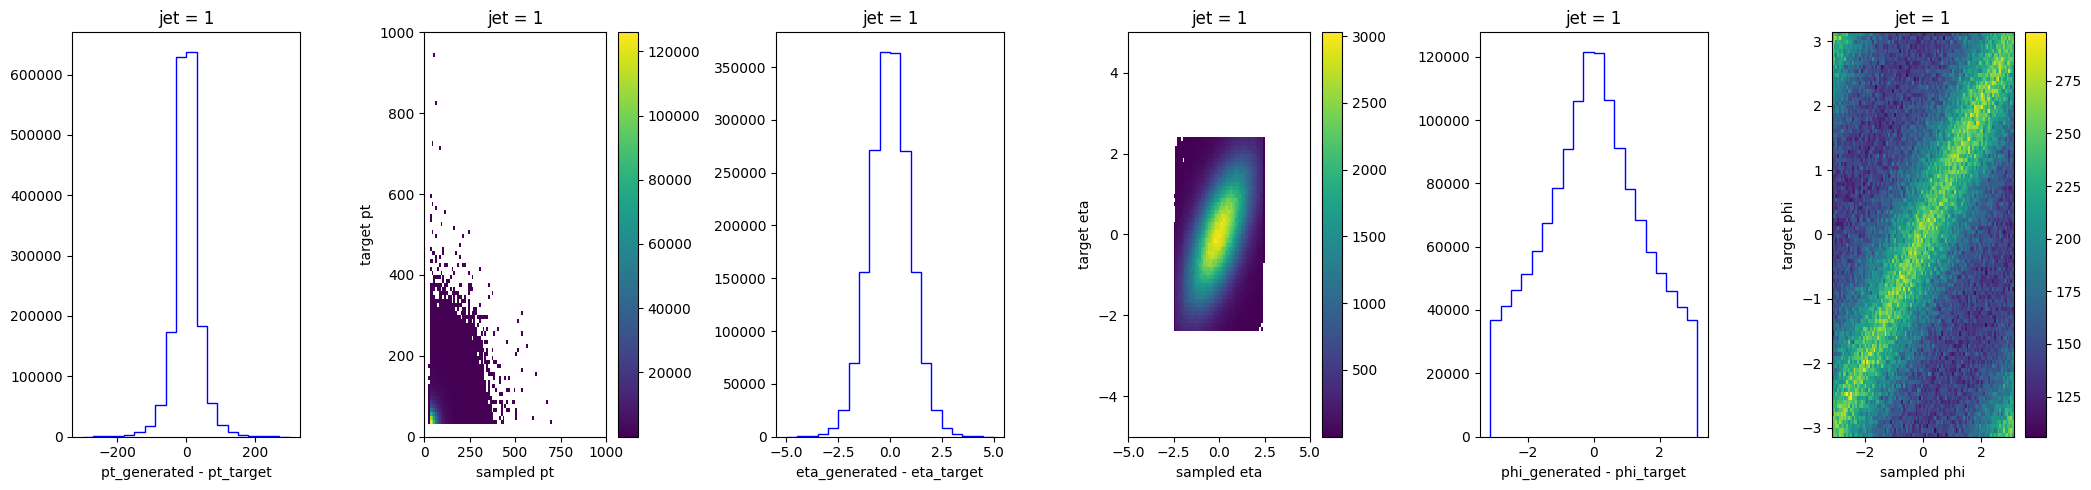

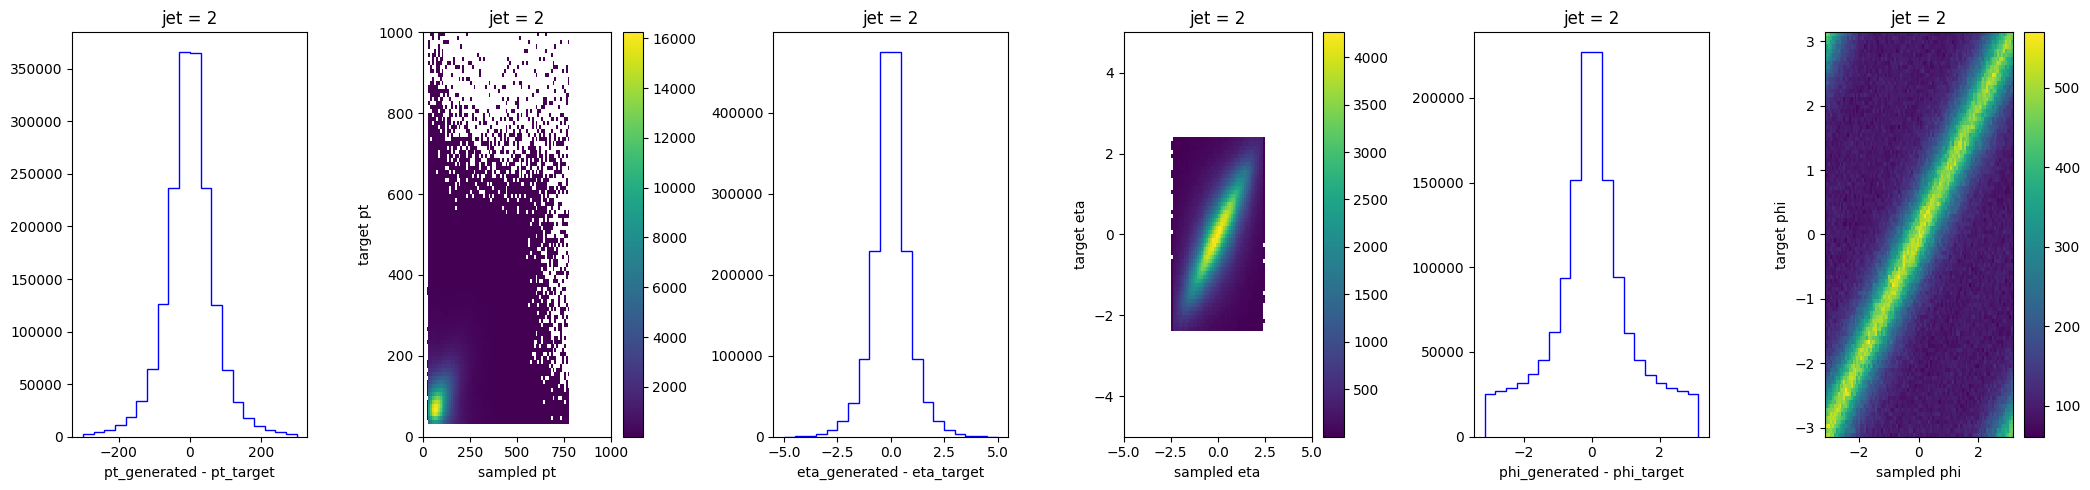

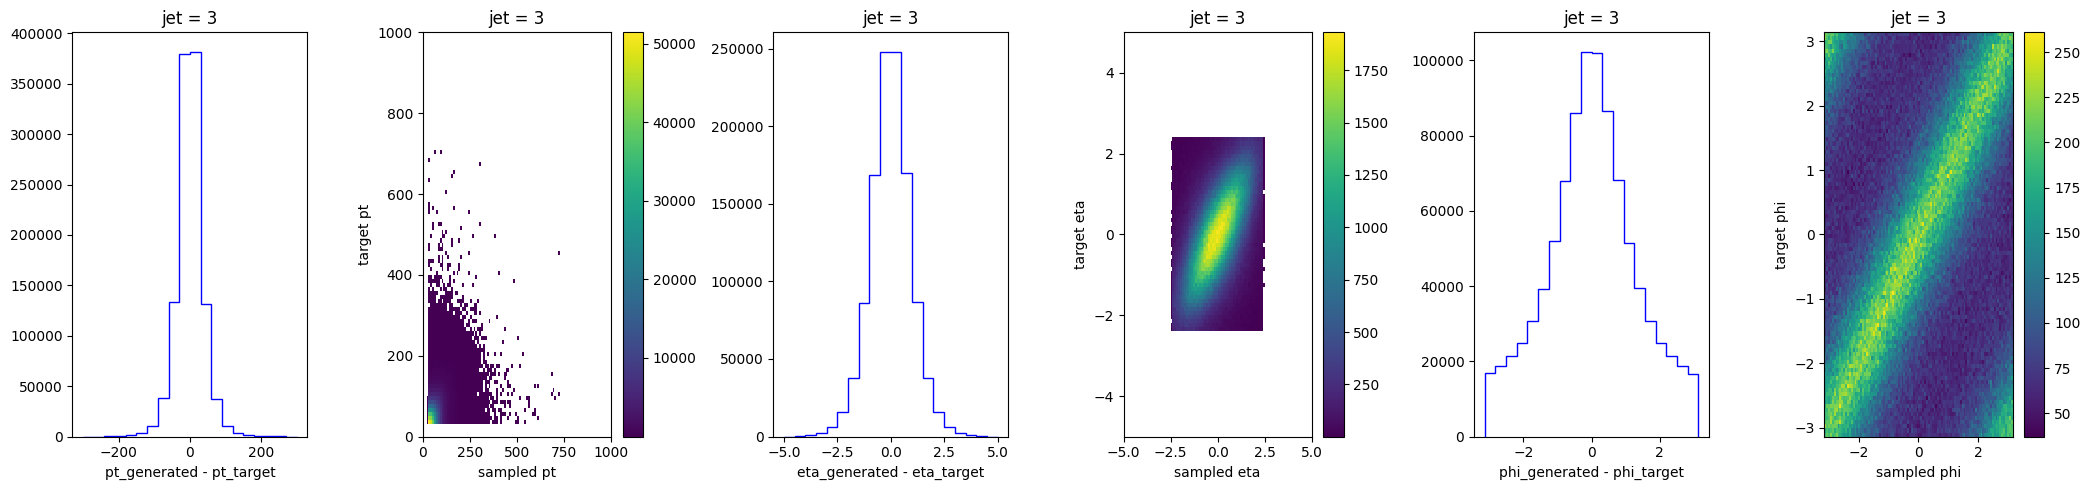

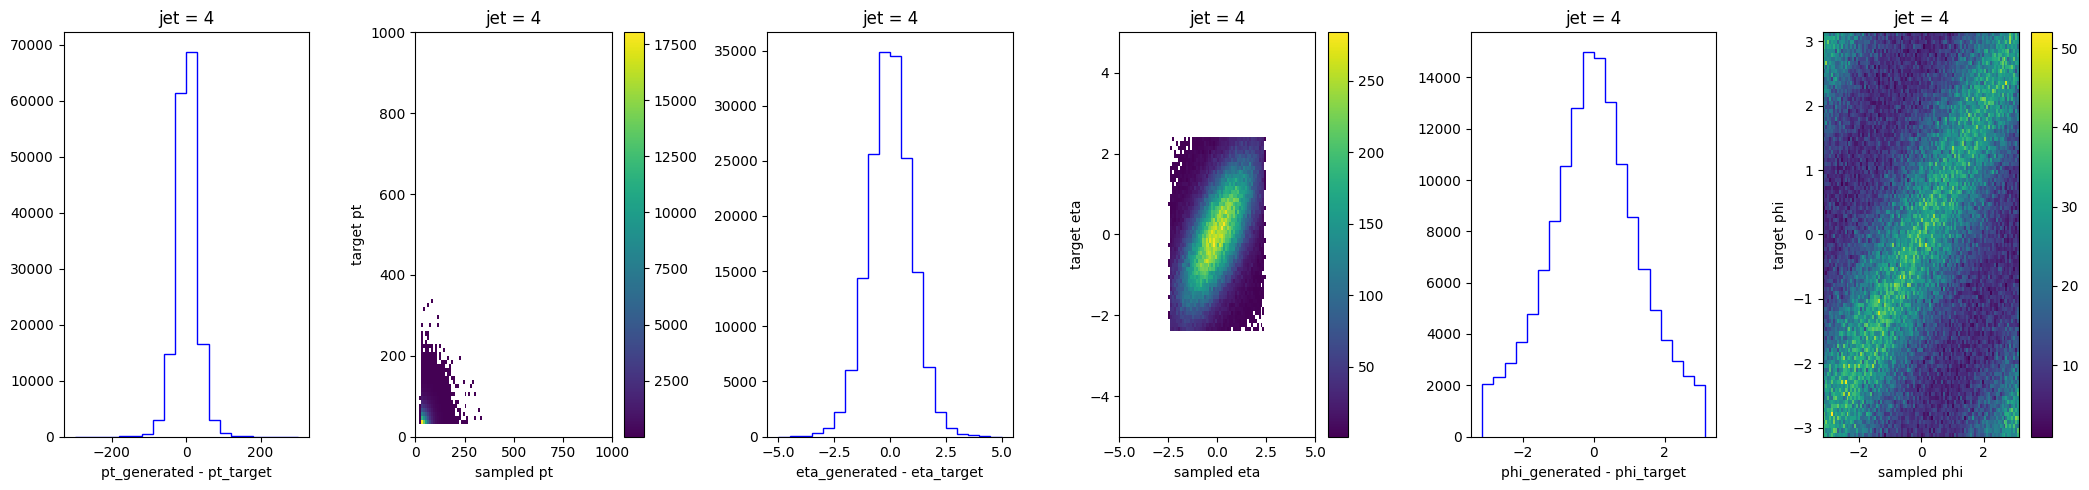

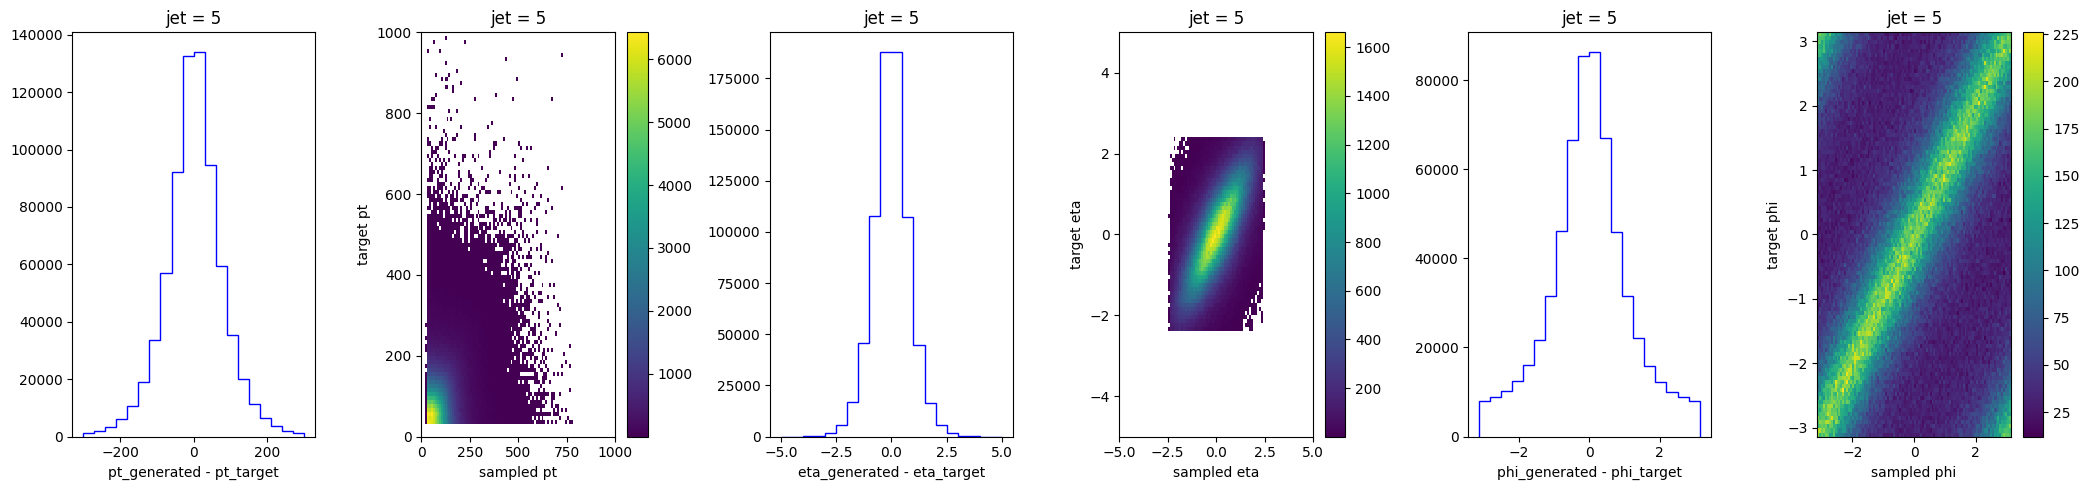

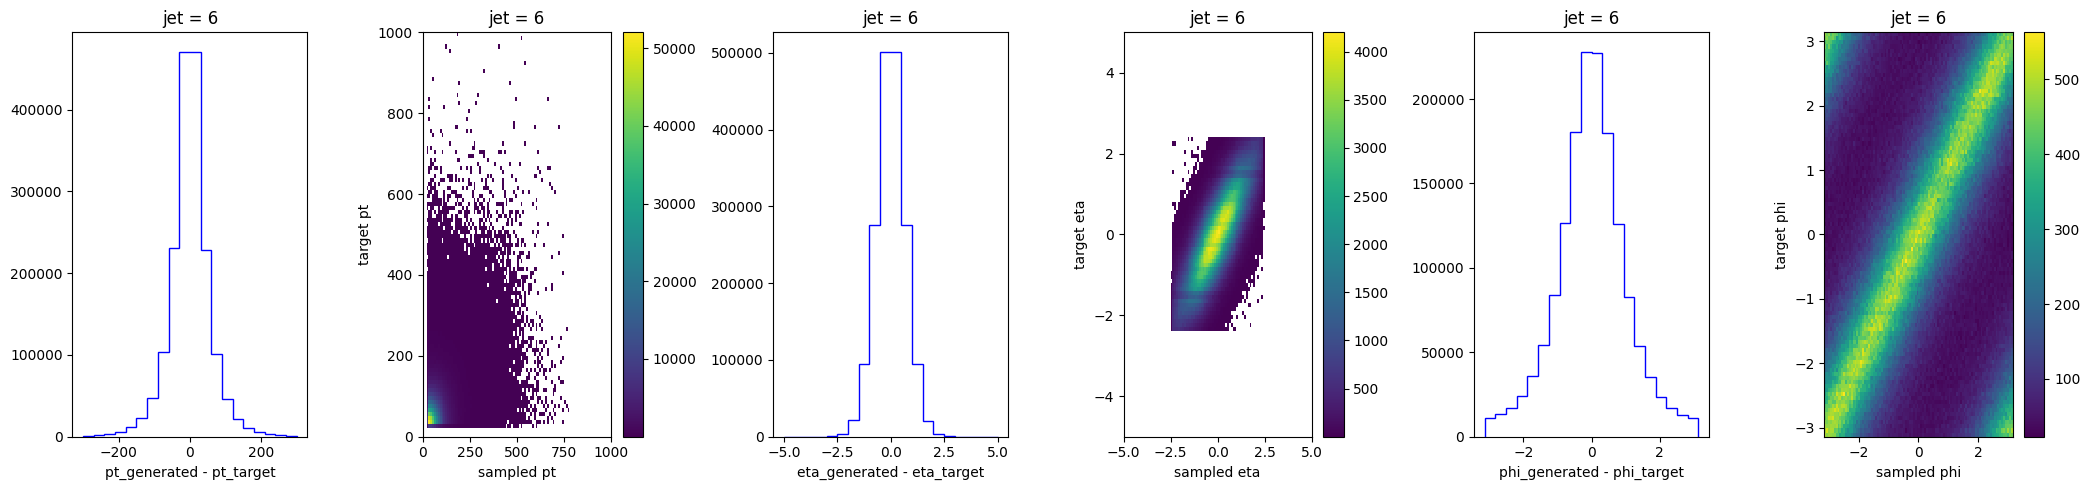

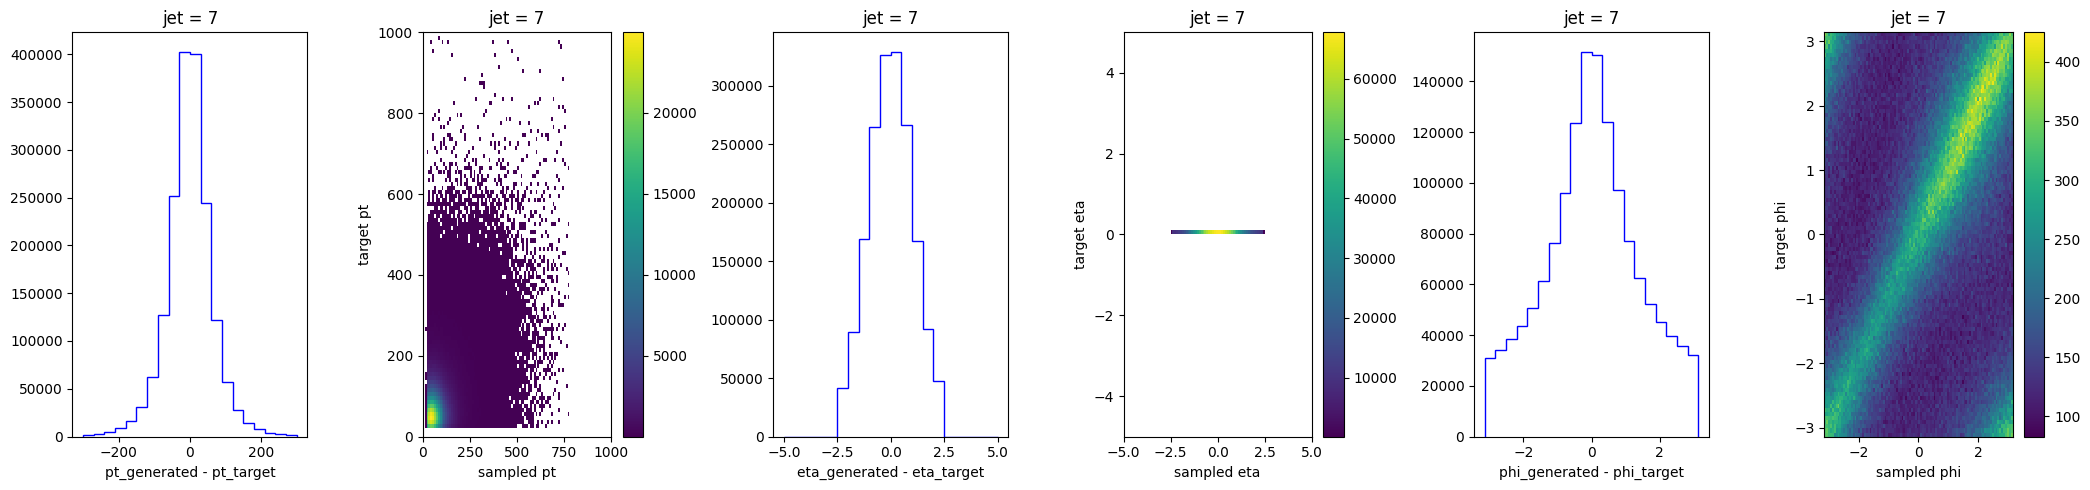

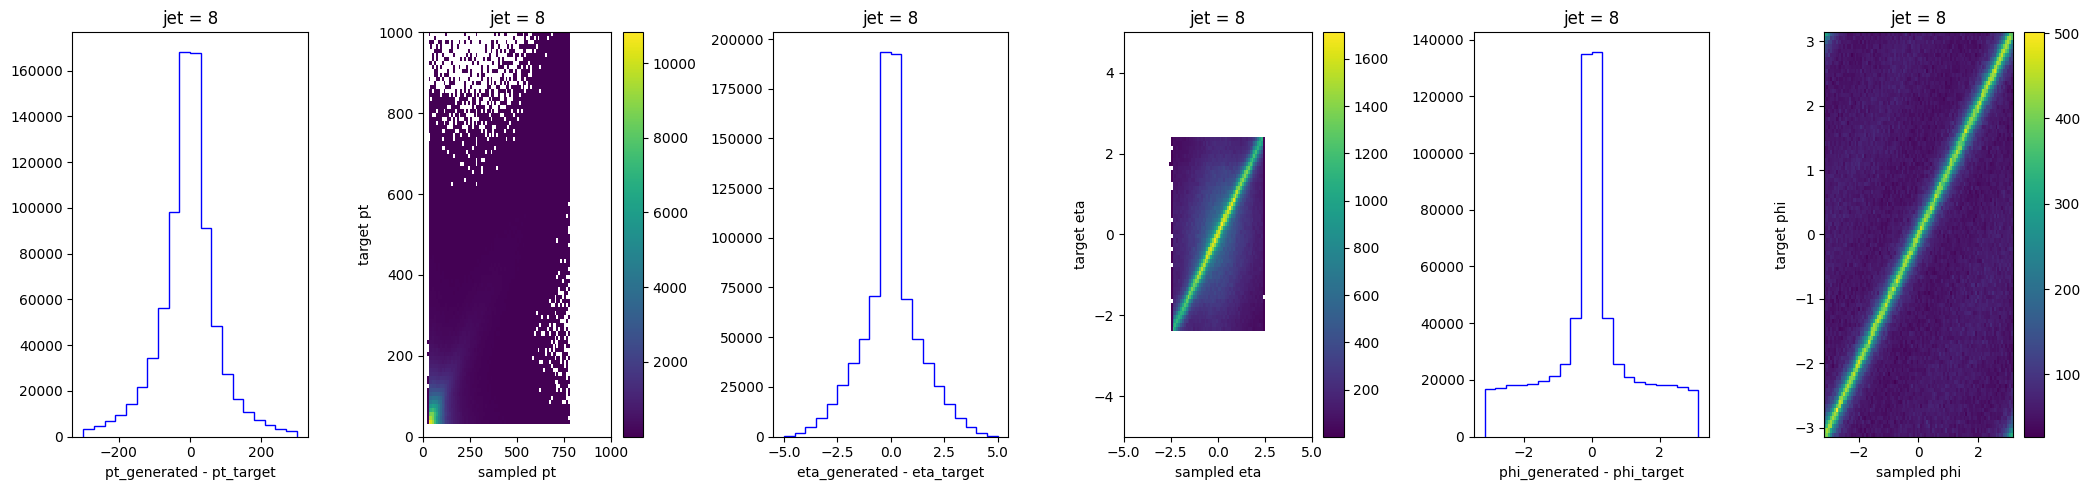

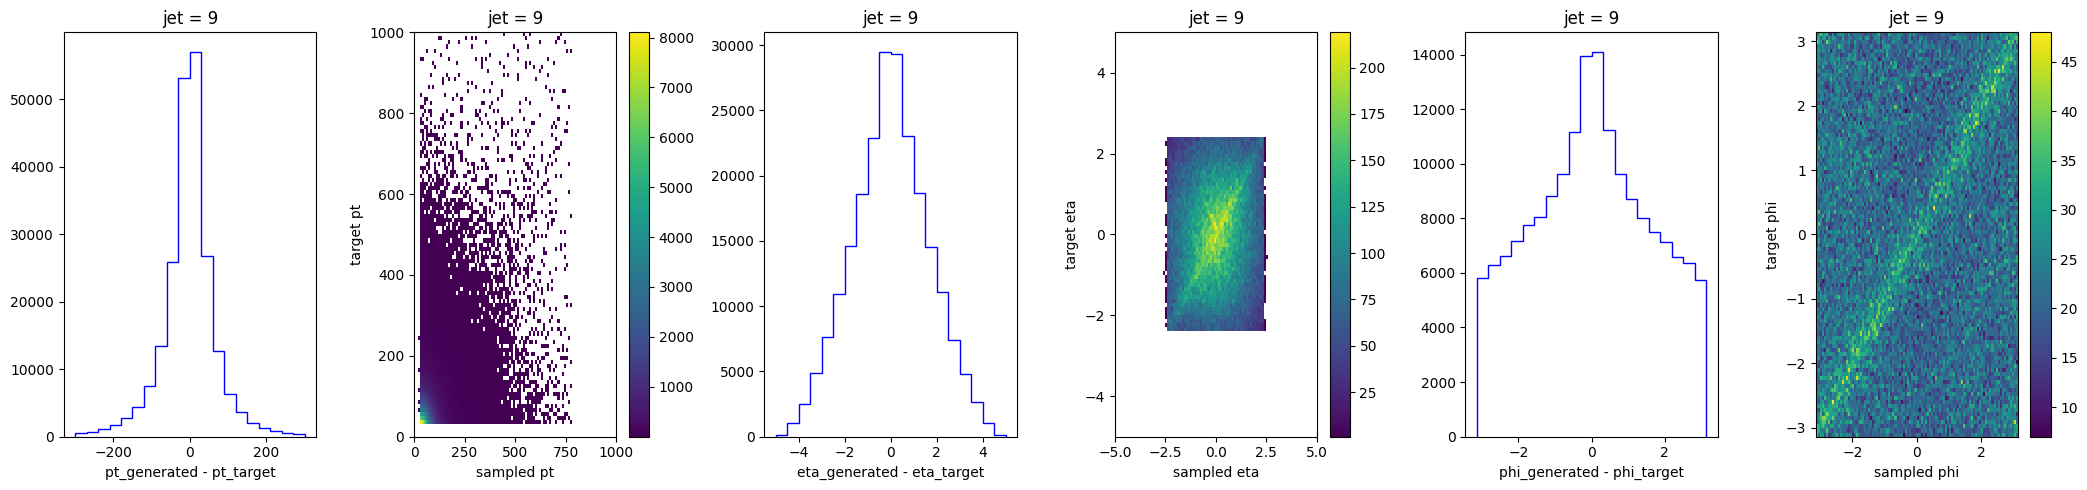

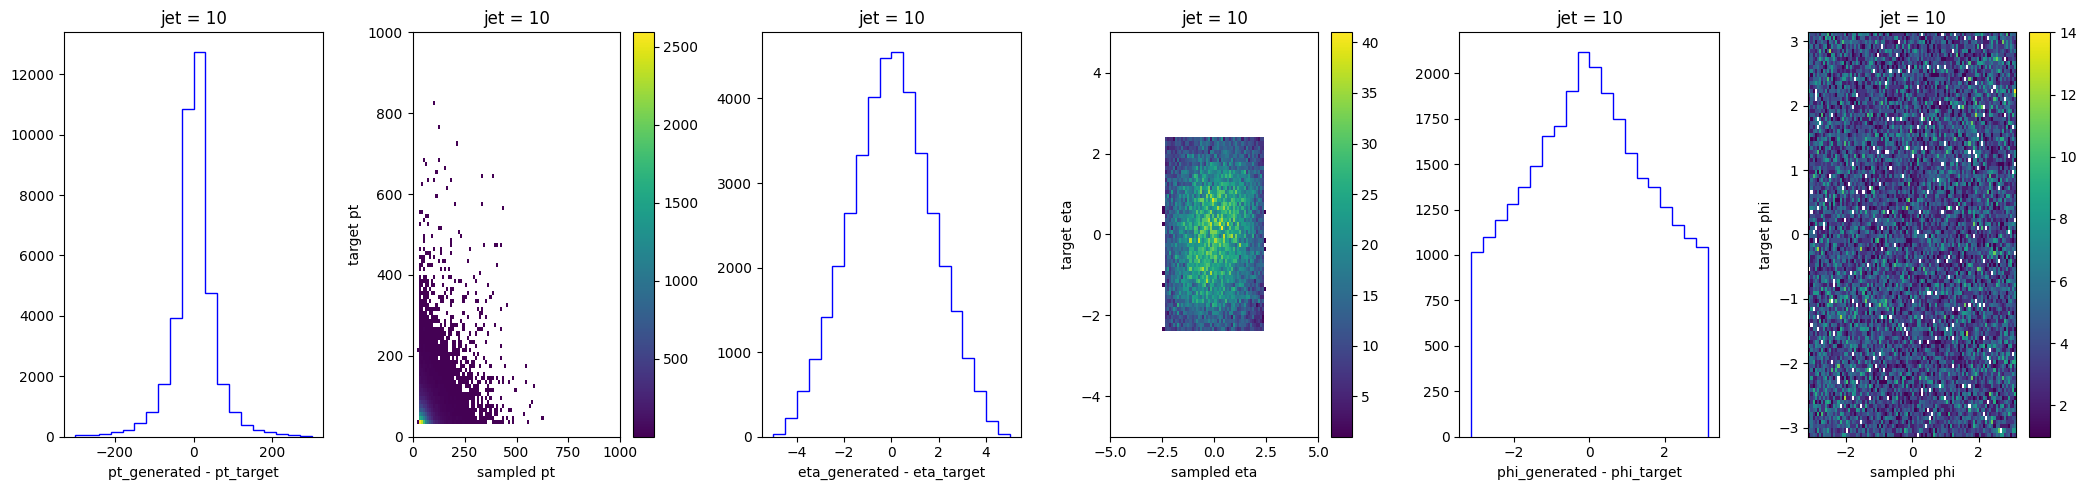

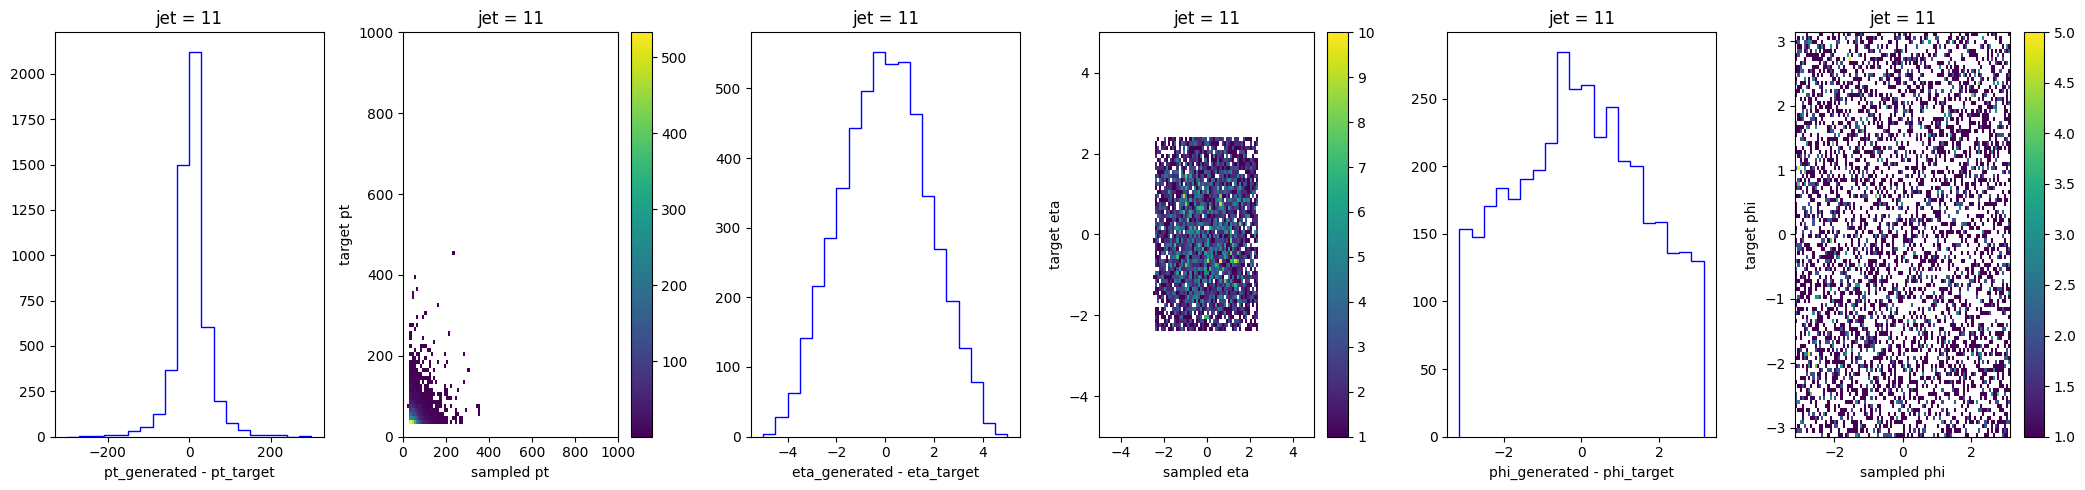

In [24]:
unscaled_target, unscaled_sampled = unscale_var(log_mean_reco, log_std_reco, scaledLogRecoSpanet, sampledEvent)
for i in range(12):
    sampling_print_unscaled(unscaled_sampled, unscaled_target, maskReco, plotJets=i, onlyExistElem=True)

# Sampled Event 1 -- VALIDATION

In [87]:
test_data = DatasetCombined(config.input_dataset_validation,dev=device,
                                  dtype=dtype, datasets=['partons_lab', 'reco_lab'],
                           reco_list_lab=['scaledLogReco_sortedBySpanet',
                                          'mask_scaledLogReco_sortedBySpanet',
                                          'mask_boost', 'scaledLogBoost'],
                           parton_list_lab=['logScaled_data_higgs_t_tbar_ISR'])

>>Loading datasets
Loading partons in LAB
PartonLevel LAB
Reading parton_level Files
Load logScaled_data_higgs_t_tbar_ISR
Parton: Move tensors to device (cpu) memory
Loading reco in LAB
RecoLevel LAB
Reading reco_level Files
Load scaledLogBoost
Load scaledLogReco_sortedBySpanet
Reco: Move tensors to device (cpu) memory
Loaded datasets:  ['partons_lab', 'reco_lab']


In [88]:
log_mean_parton = test_data.partons_lab.mean_log_data_higgs_t_tbar_ISR
log_std_parton = test_data.partons_lab.std_log_data_higgs_t_tbar_ISR
log_mean_reco = test_data.reco_lab.meanRecoParticles
log_std_reco = test_data.reco_lab.stdRecoParticles
    
scaledLogRecoSpanet = test_data.reco_lab.scaledLogReco_sortedBySpanet
maskReco = test_data.reco_lab.mask_scaledLogReco_sortedBySpanet


In [89]:
model_dir = '/eos/user/a/adpetre/www/ttHbbAnalysis/MEMFlow/models_archive/transferFlow_paperVersion-pretrained_2ndVersion_onlyExist_v6/Transfer_Flow_Paper_pretrained_v2_transfer_flow_2nd_2nd_DiagNormal_NoTransf1_NoBins80_DNN:6_256'
path_to_sample = model_dir + '/sampled_jets_valid.pt'
sampledEvent = torch.load(path_to_sample, map_location=device)
print(sampledEvent.shape)
print(scaledLogRecoSpanet.shape)

torch.Size([179213, 12, 5])
torch.Size([179213, 21, 9])


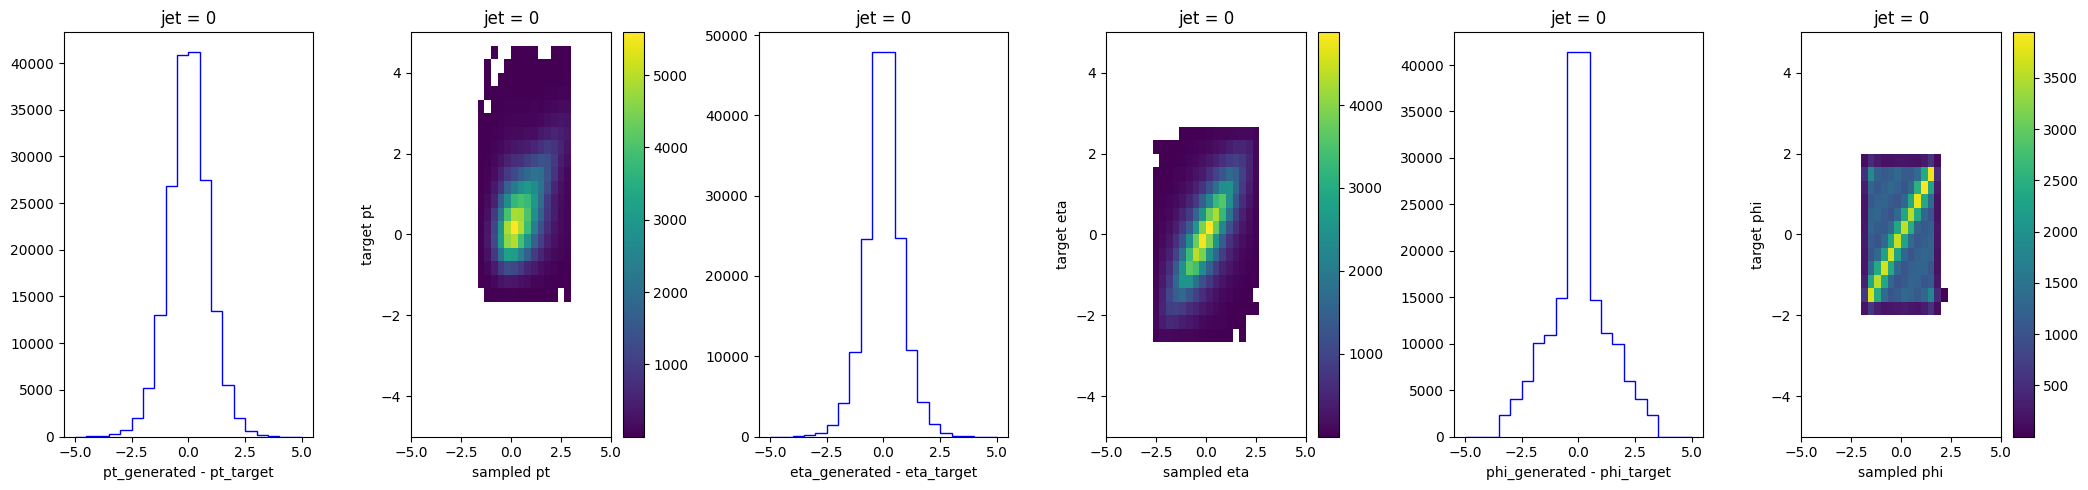

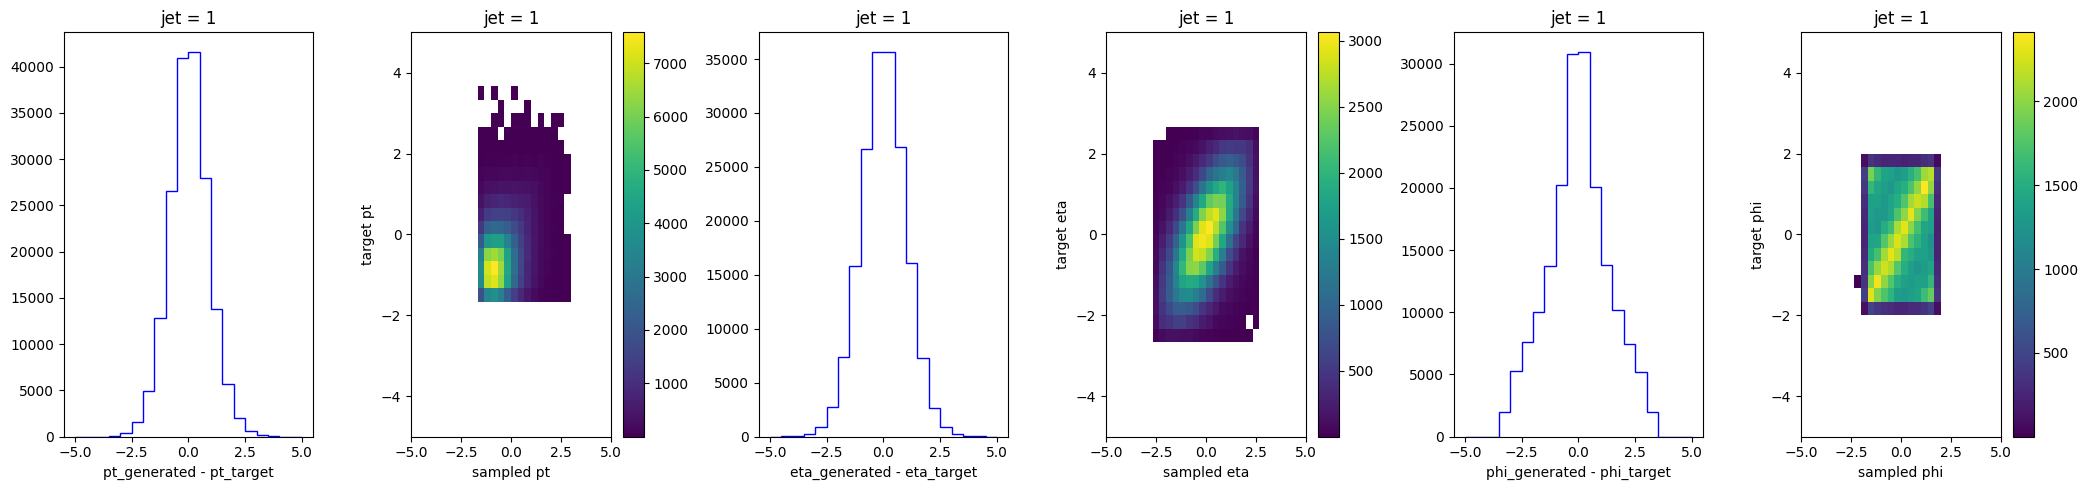

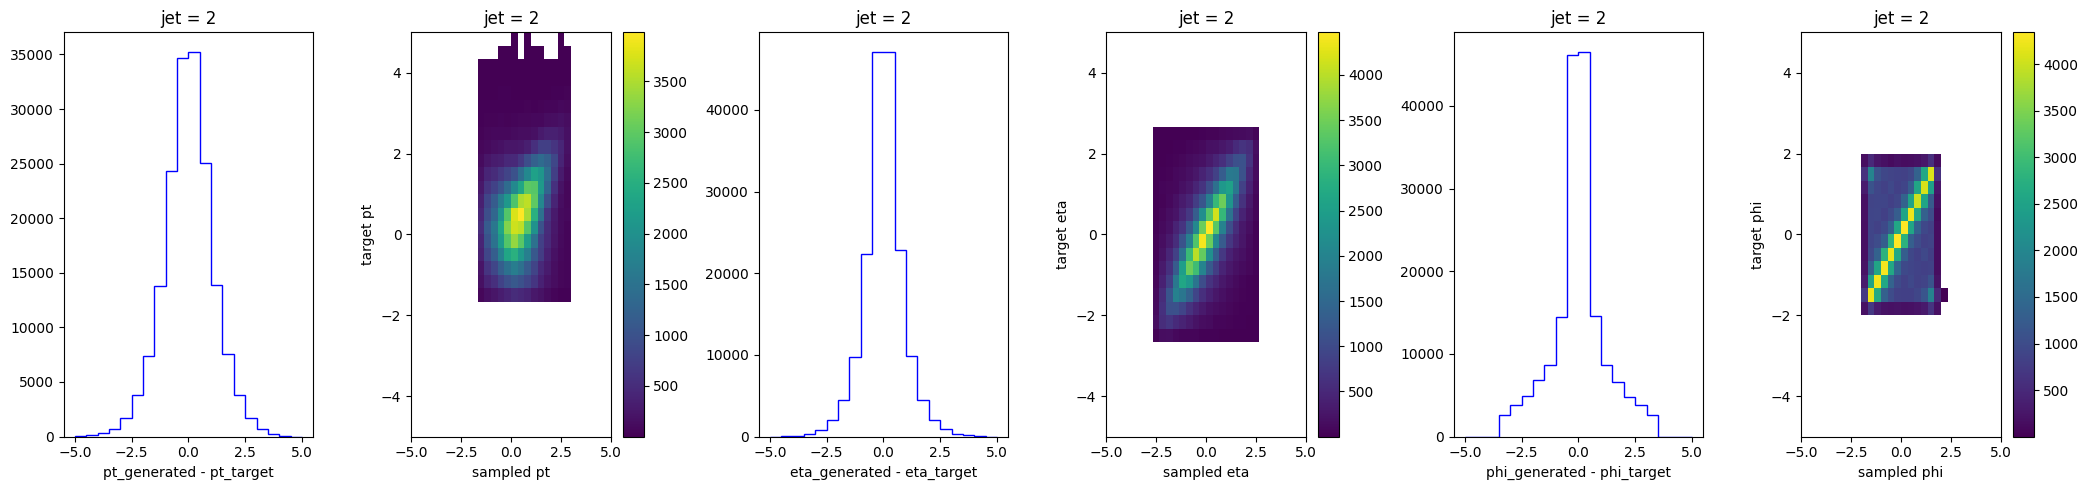

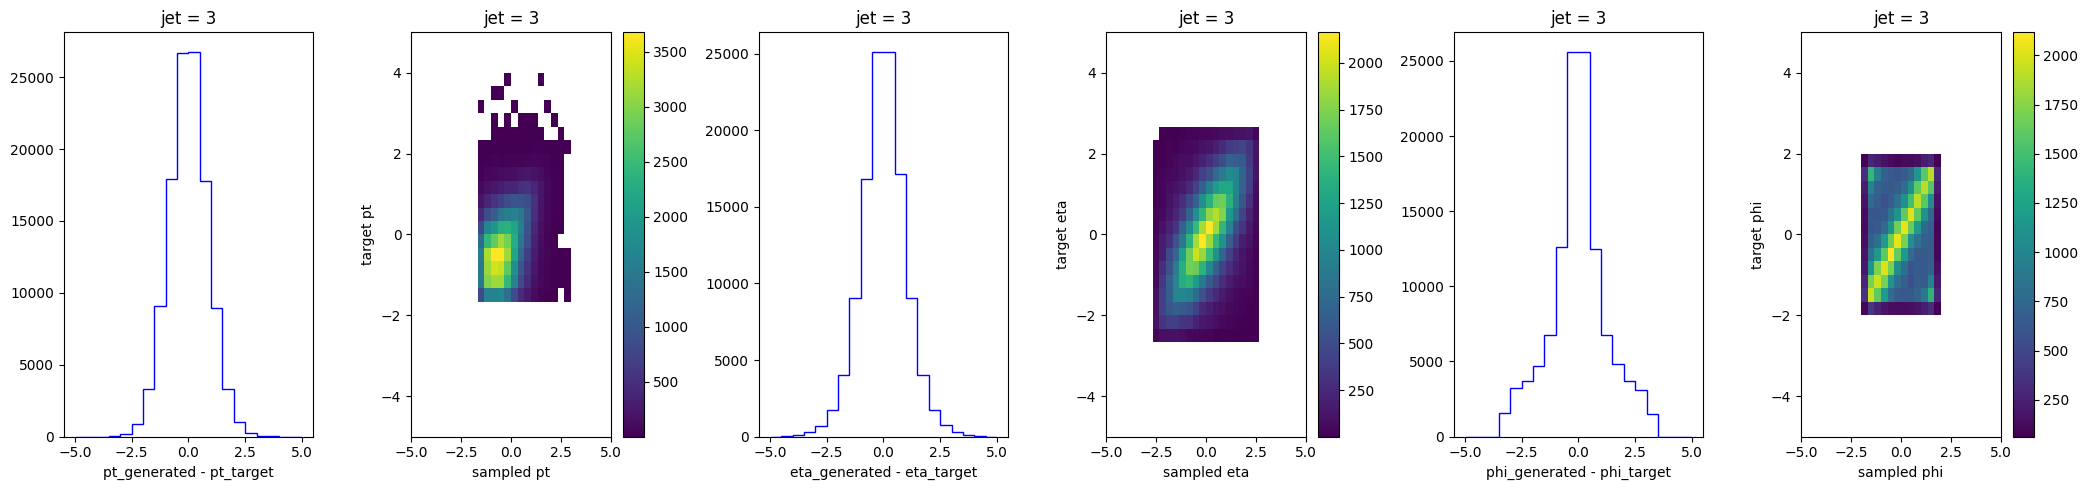

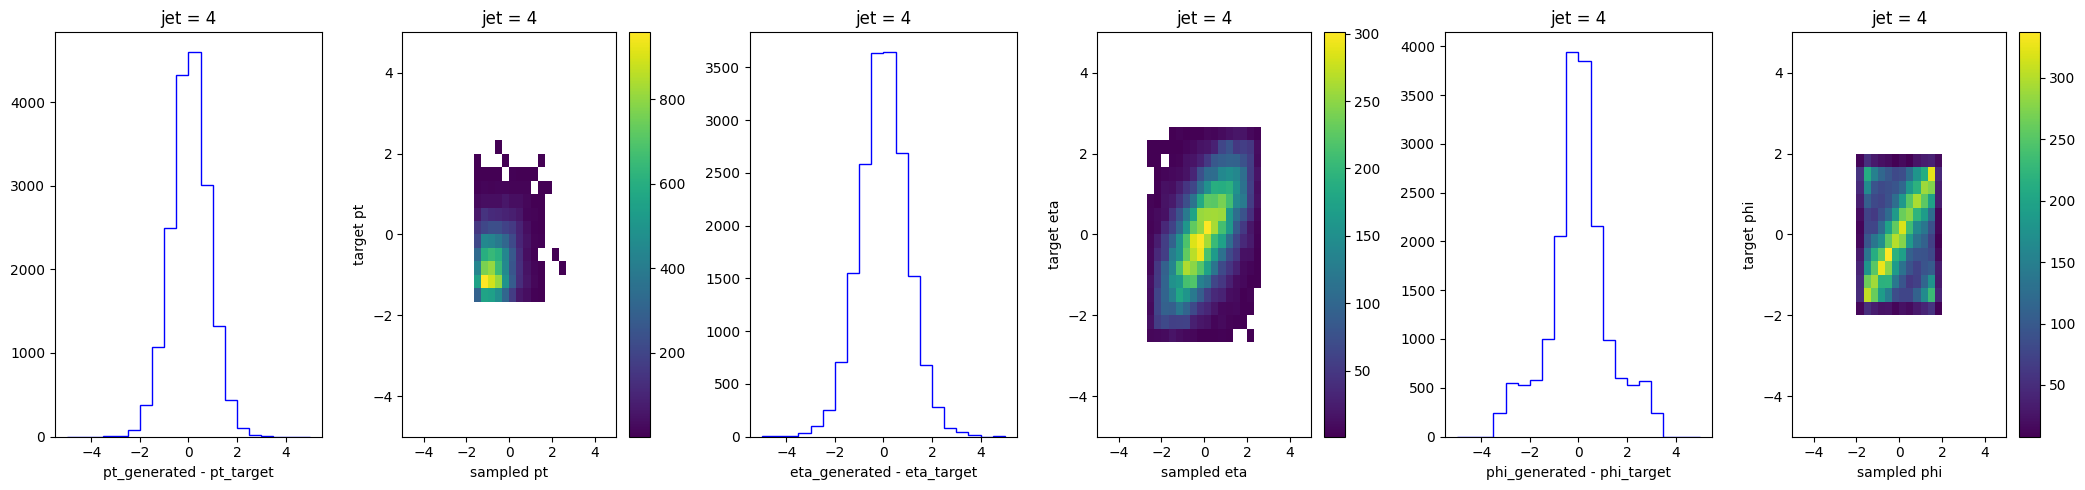

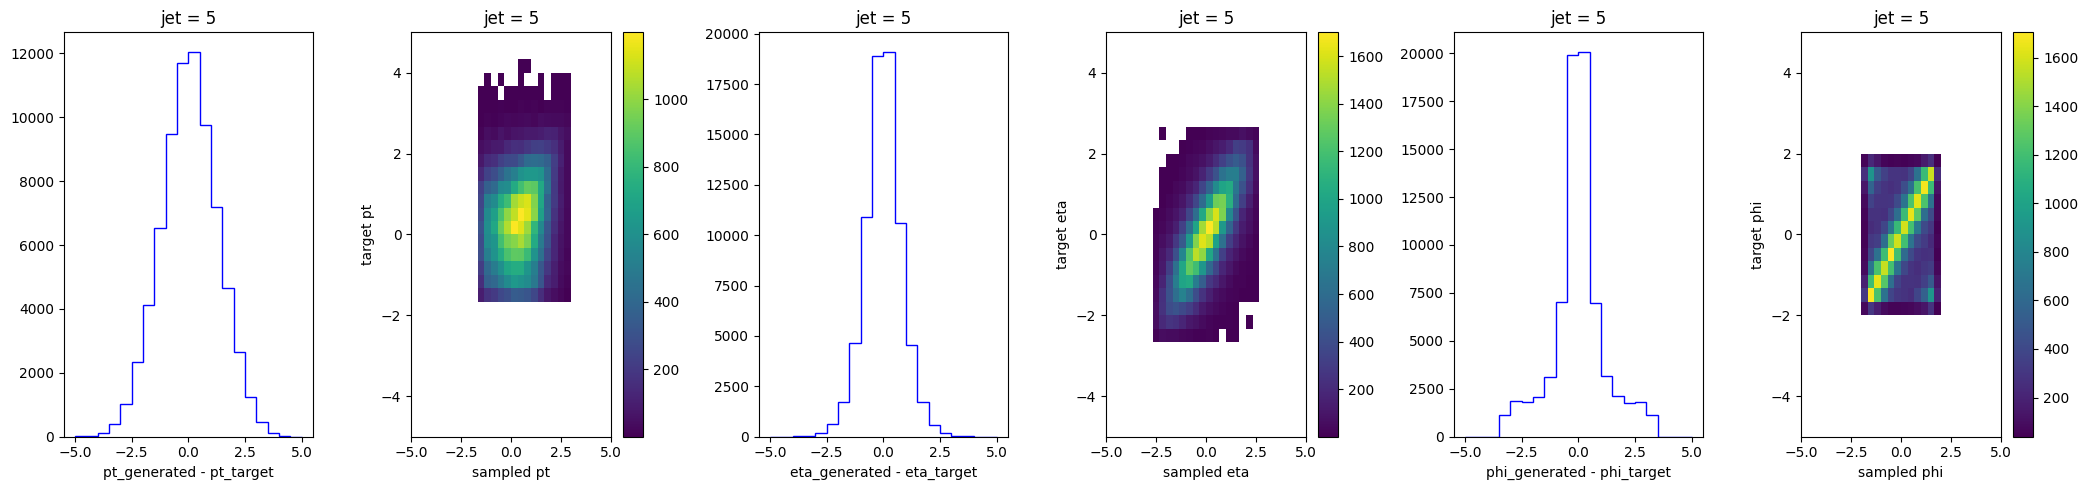

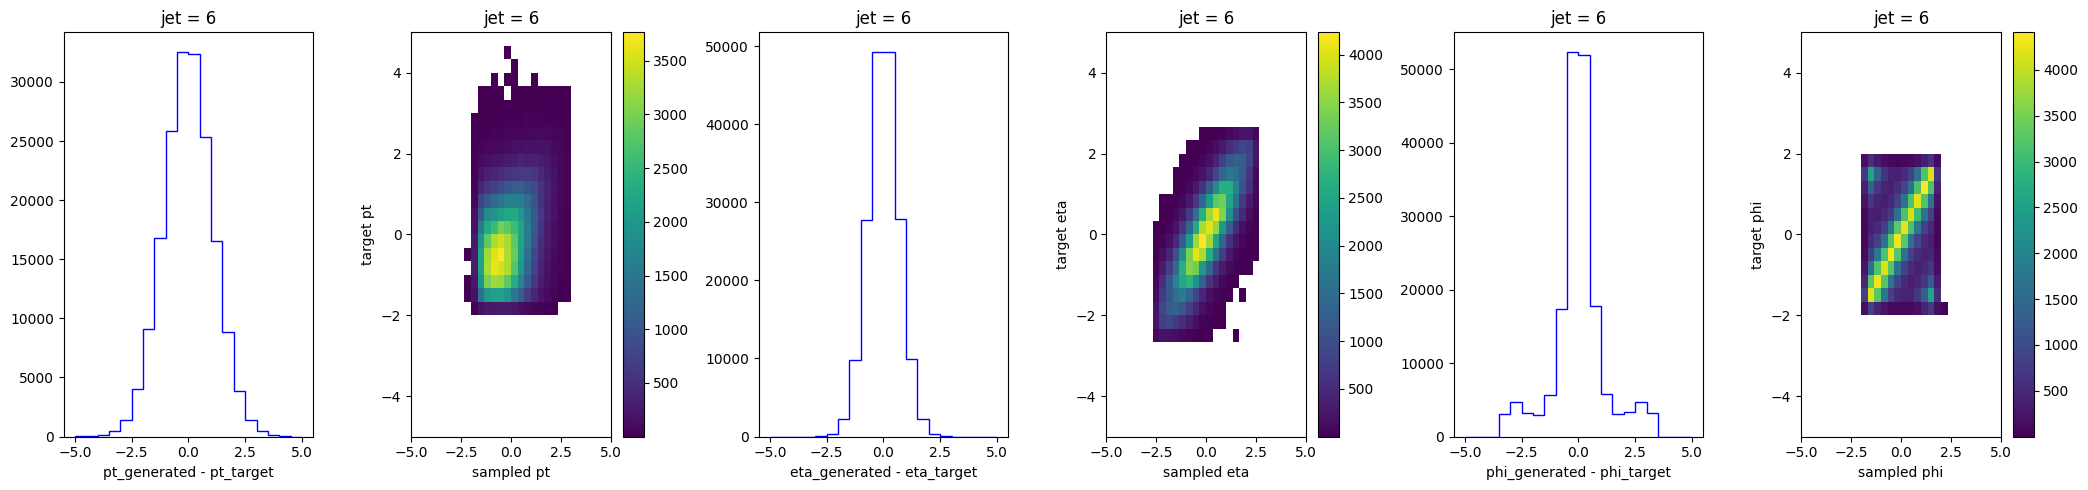

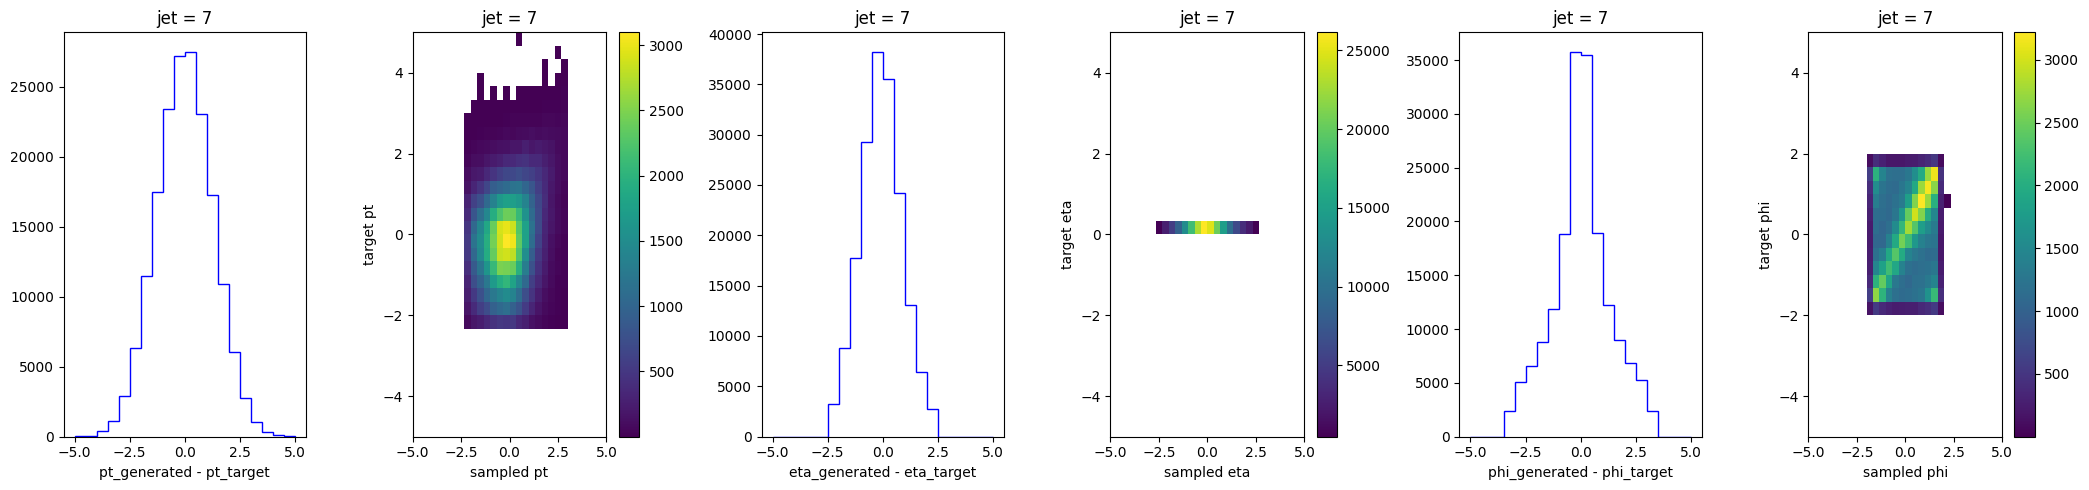

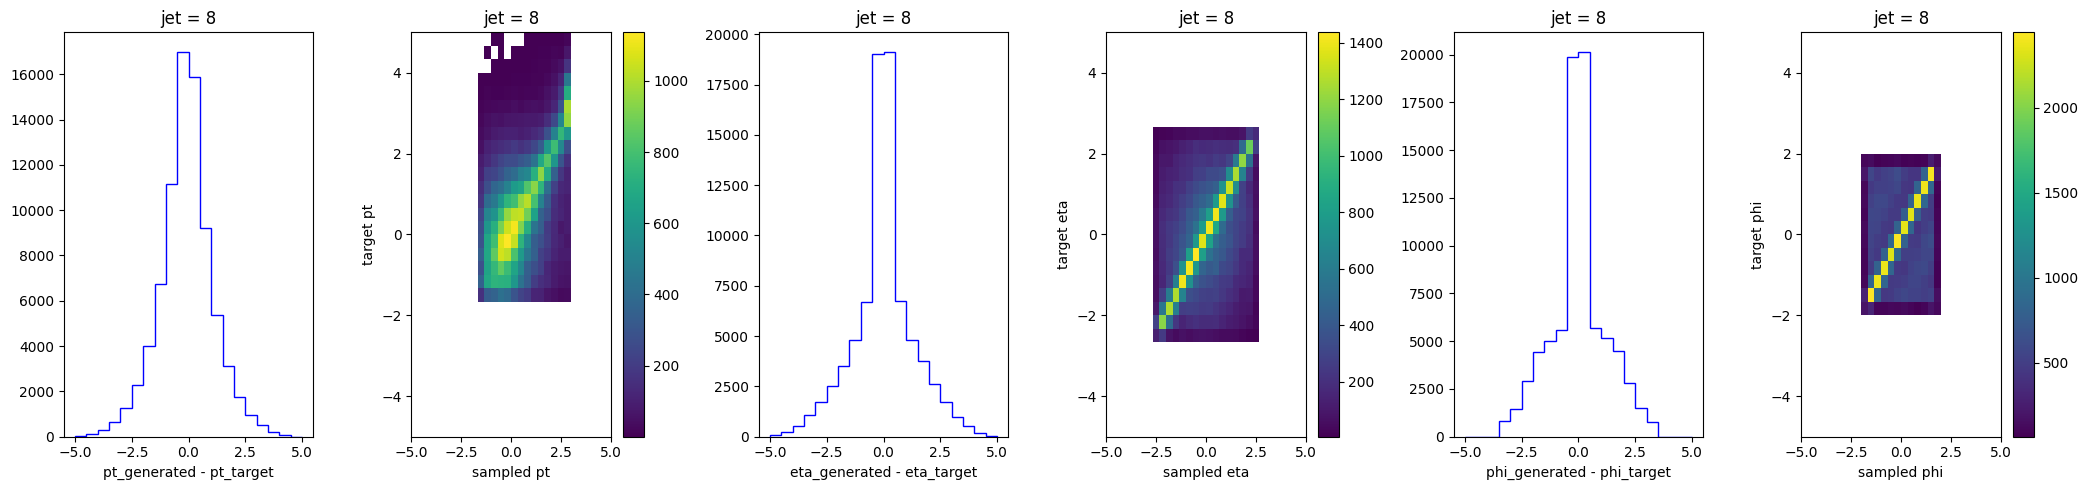

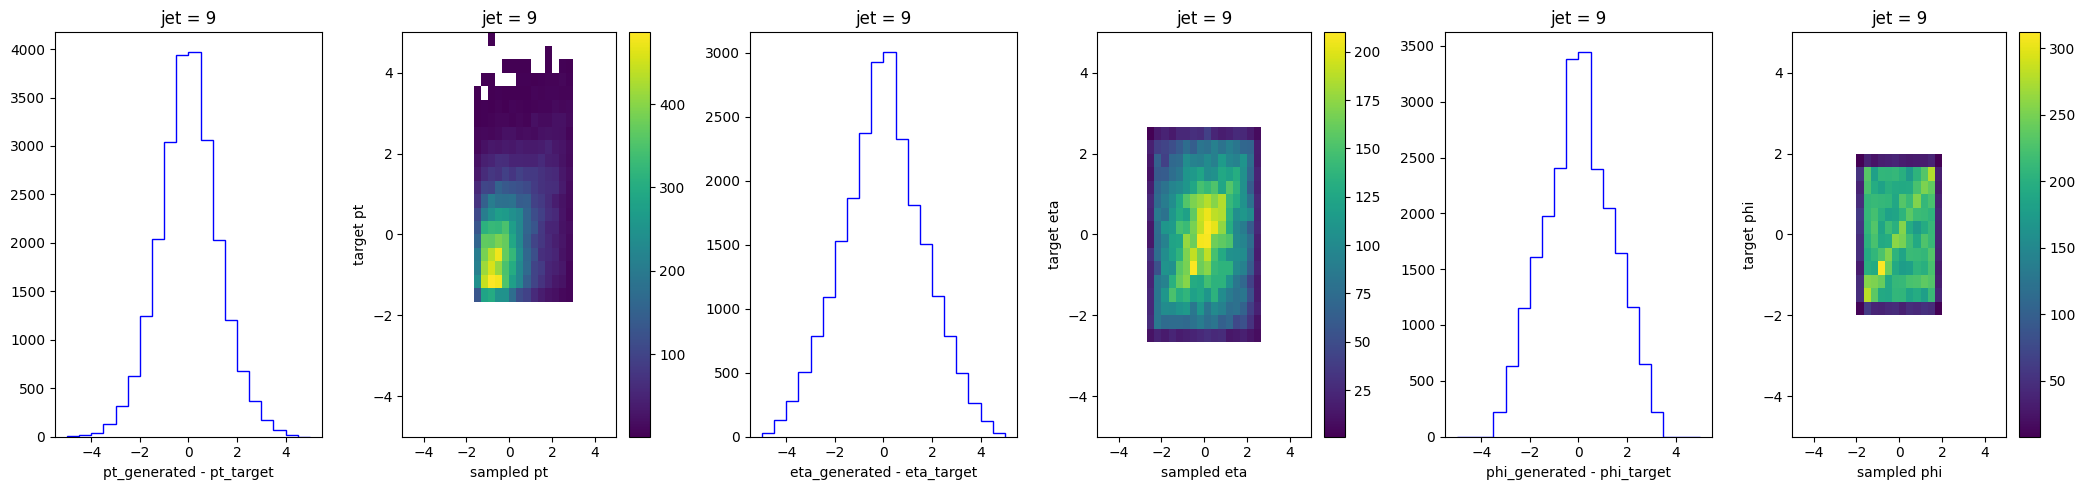

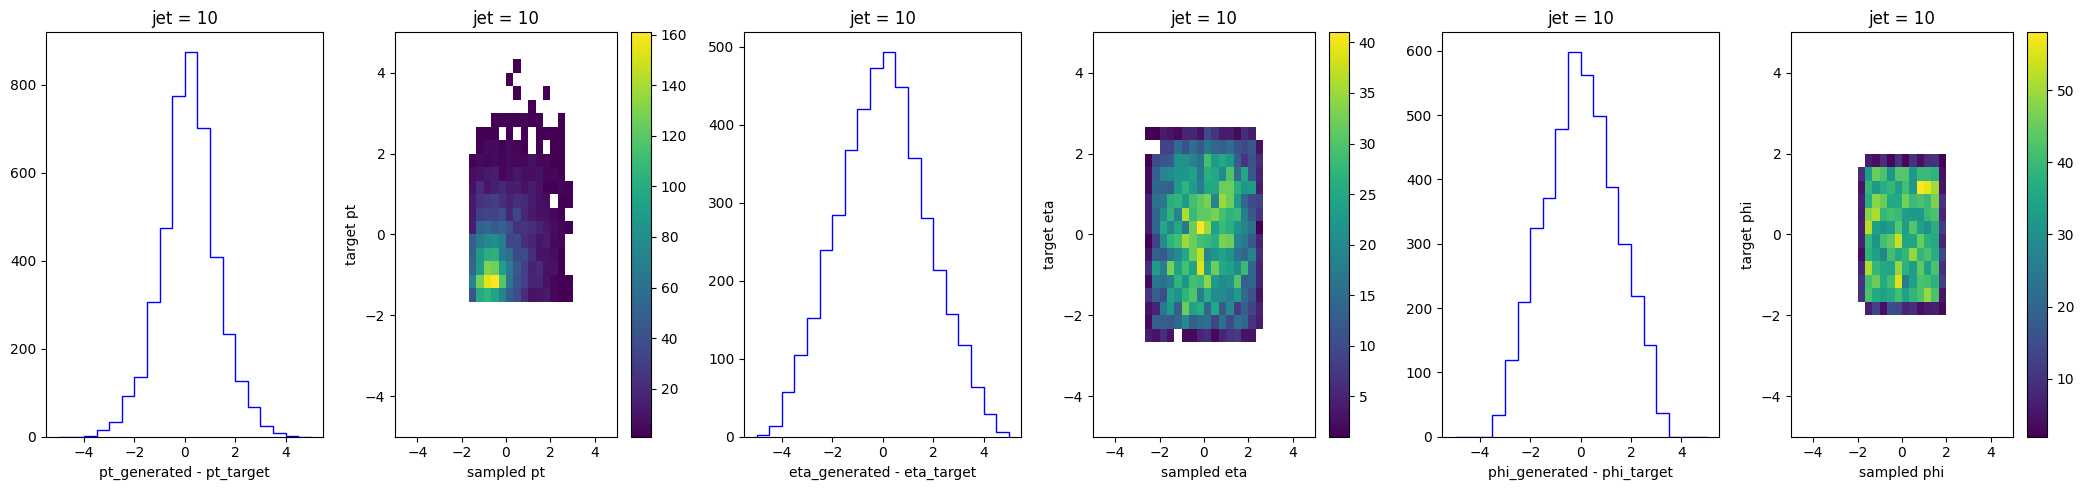

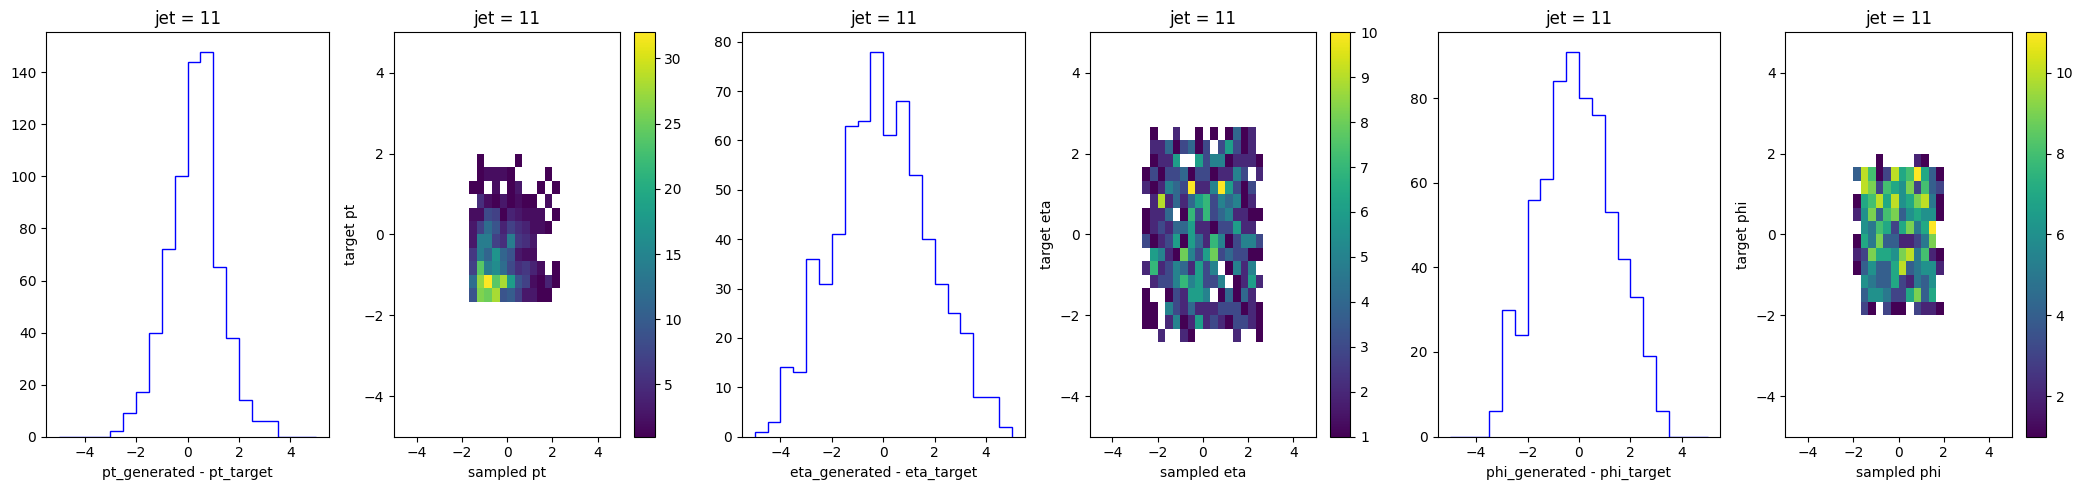

In [84]:
for i in range(12):
    sampling_print(sampledEvent, scaledLogRecoSpanet, maskReco, plotJets=i, onlyExistElem=True)

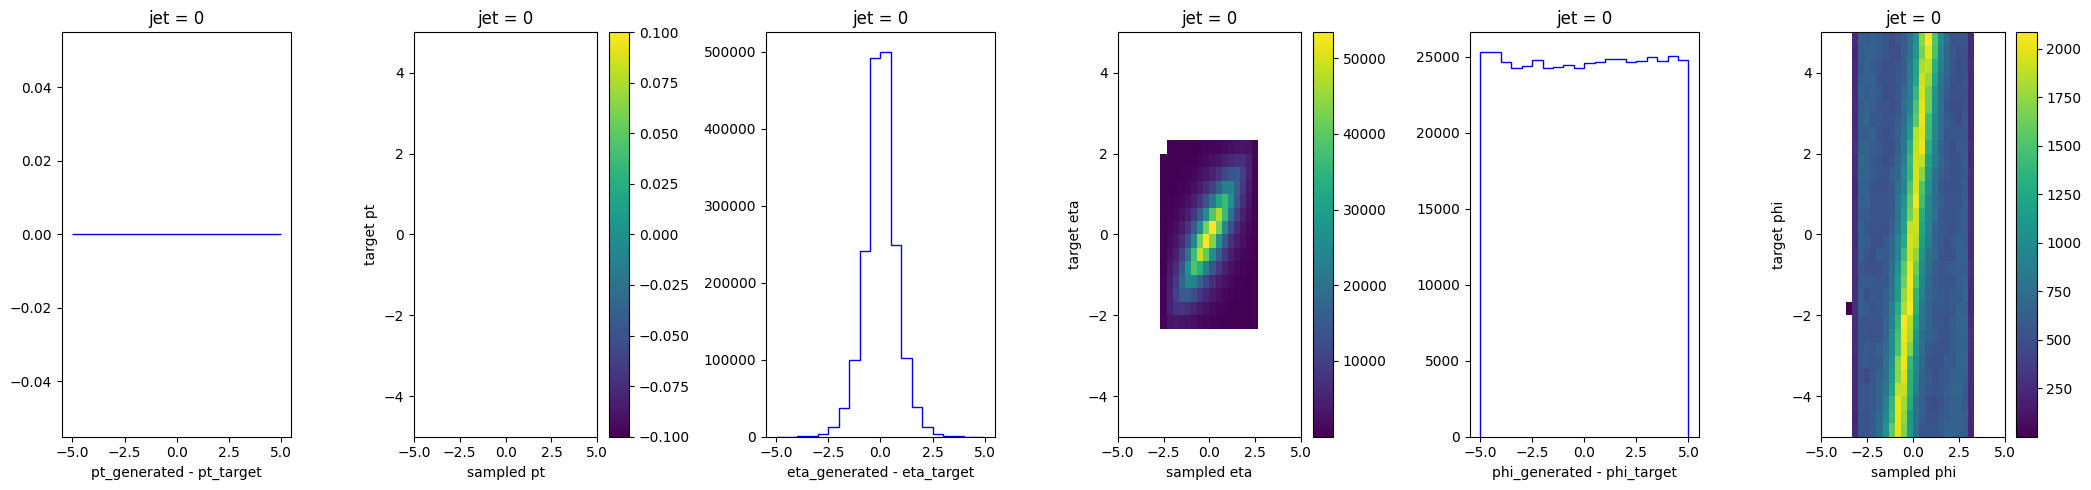

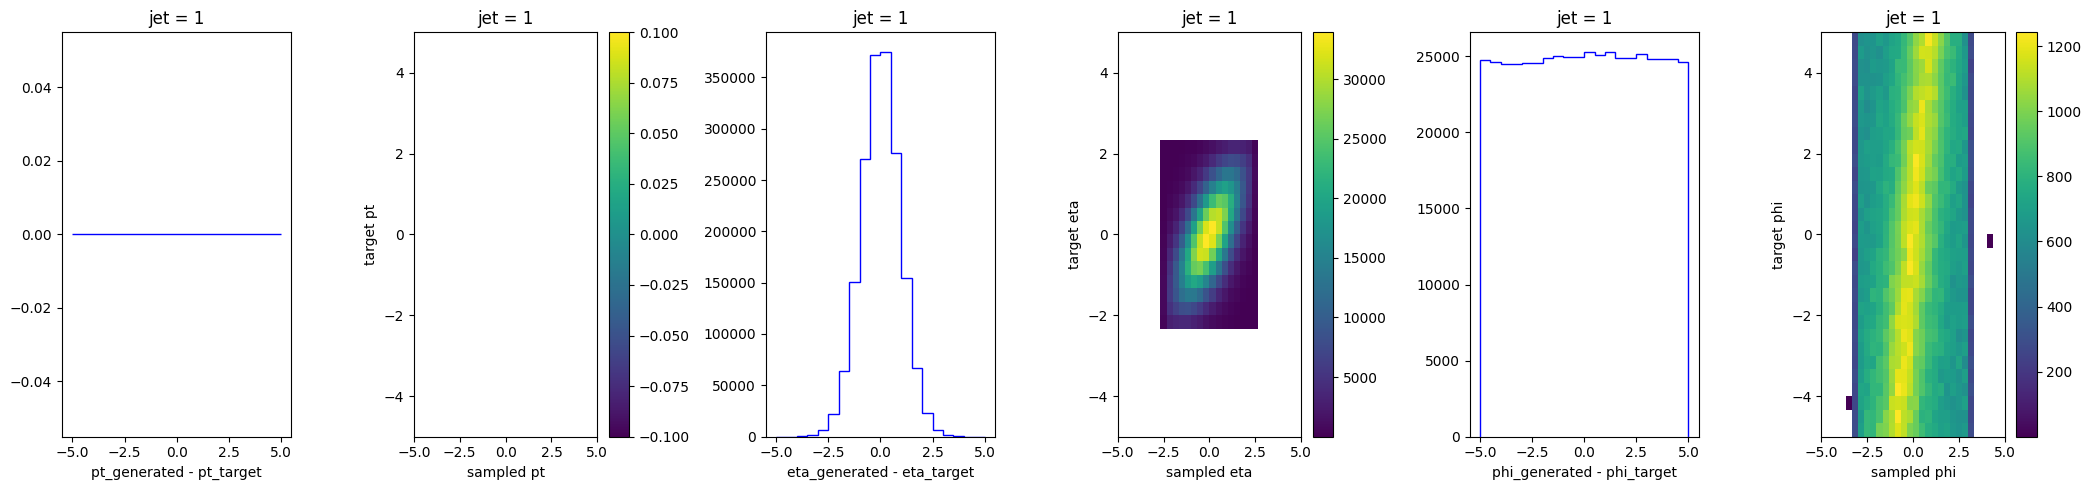

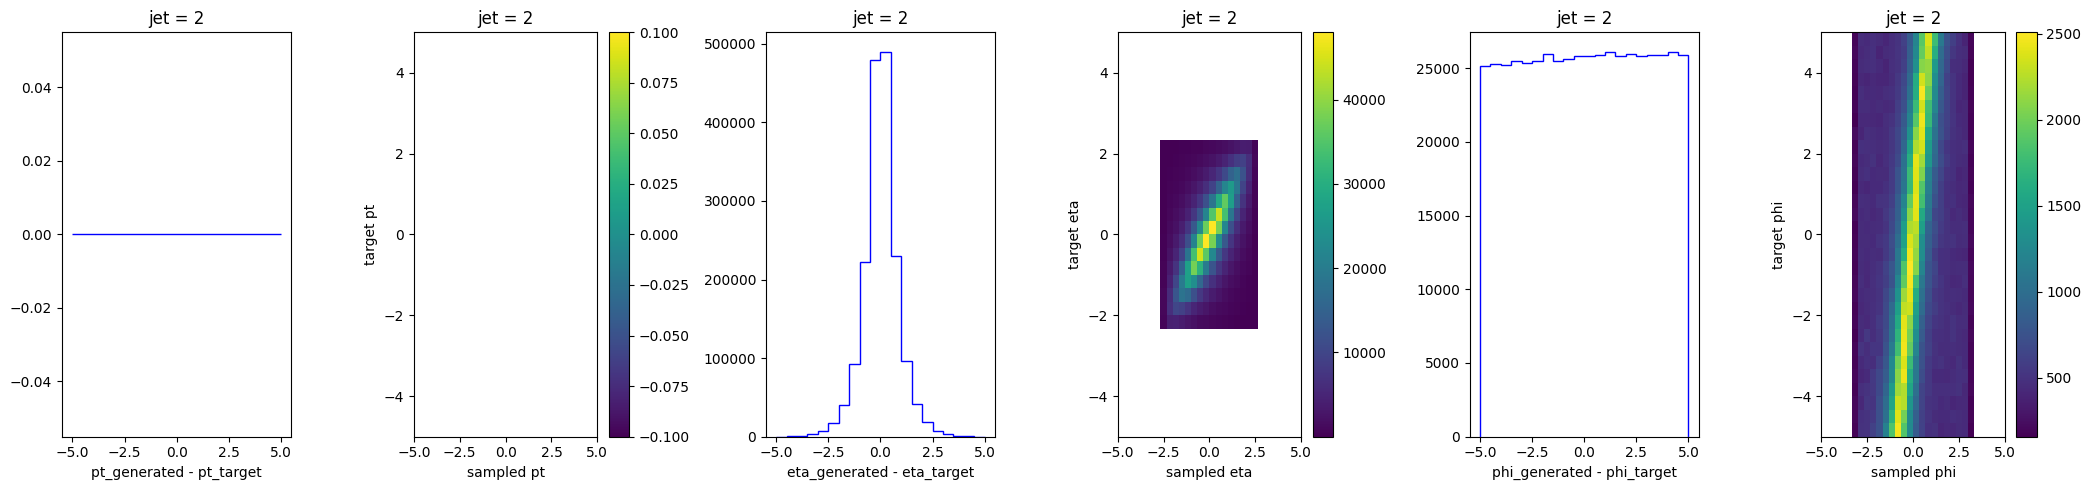

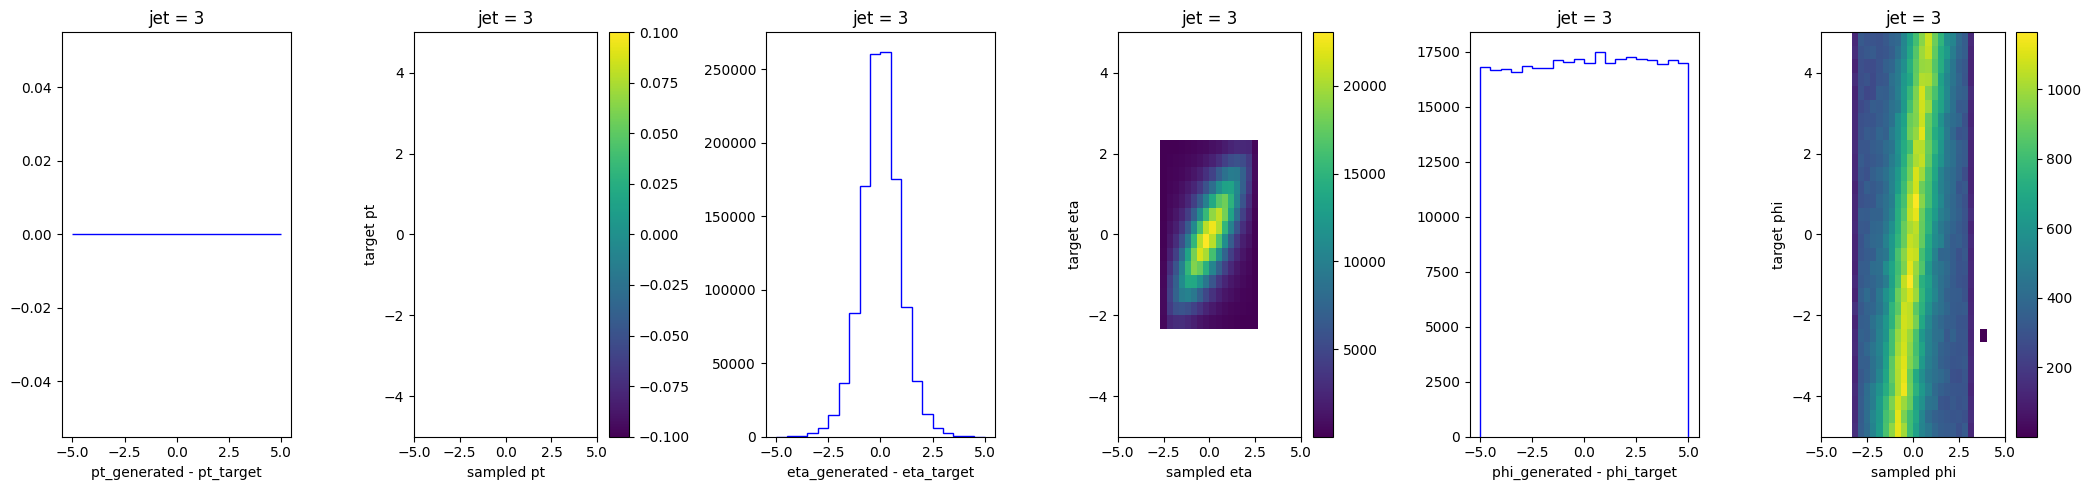

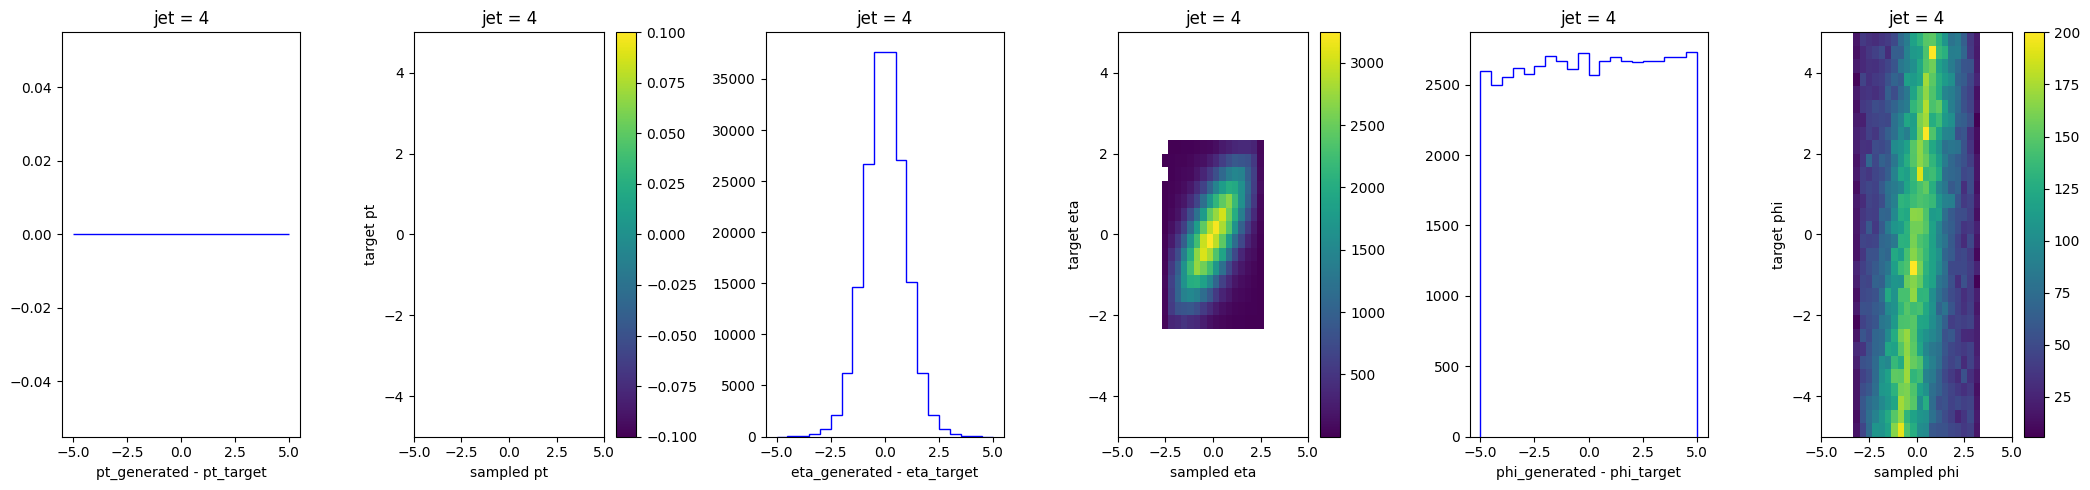

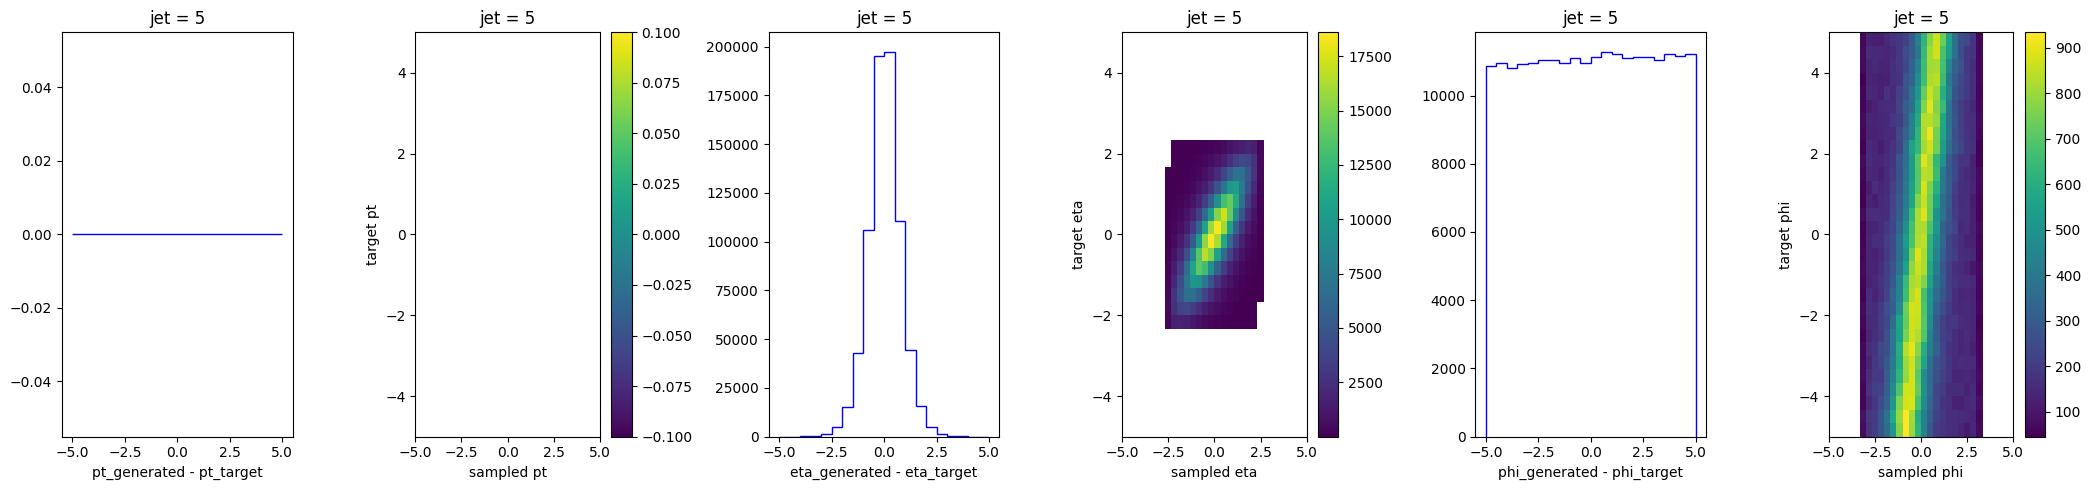

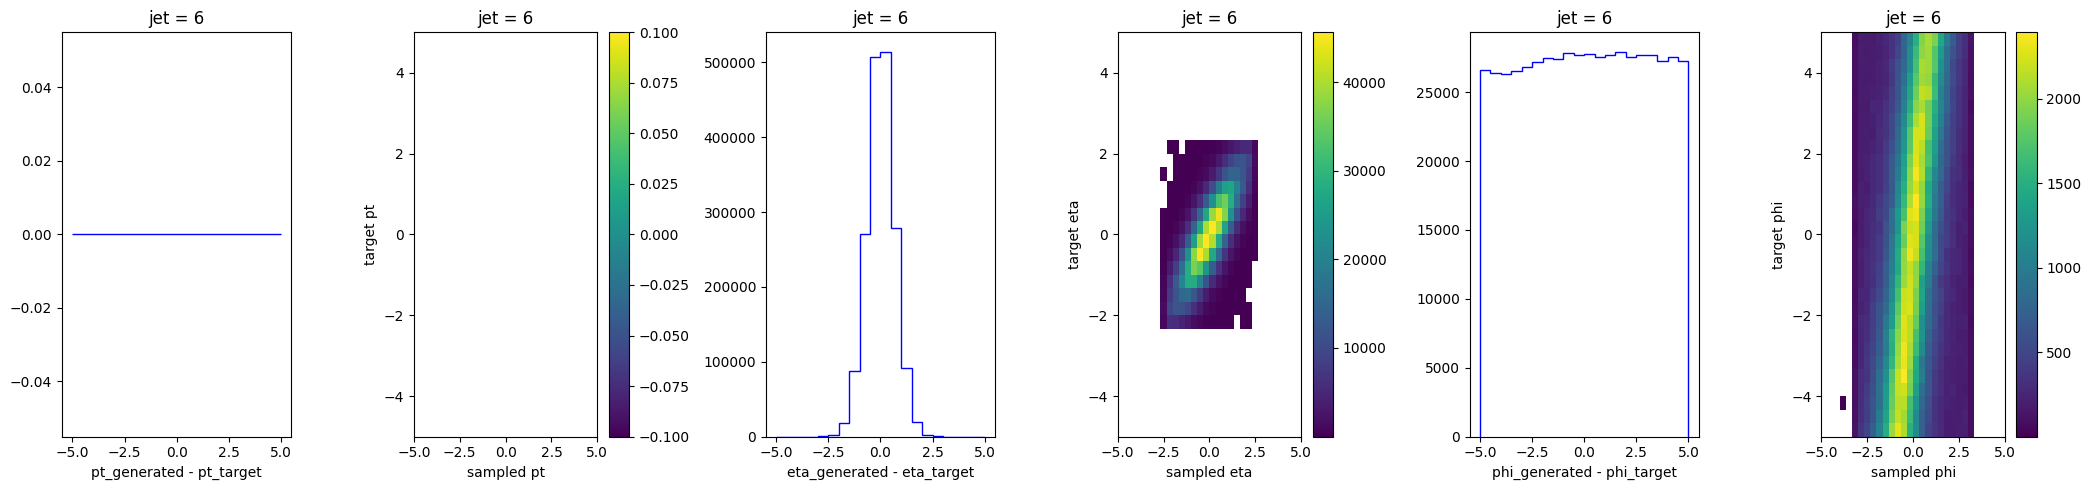

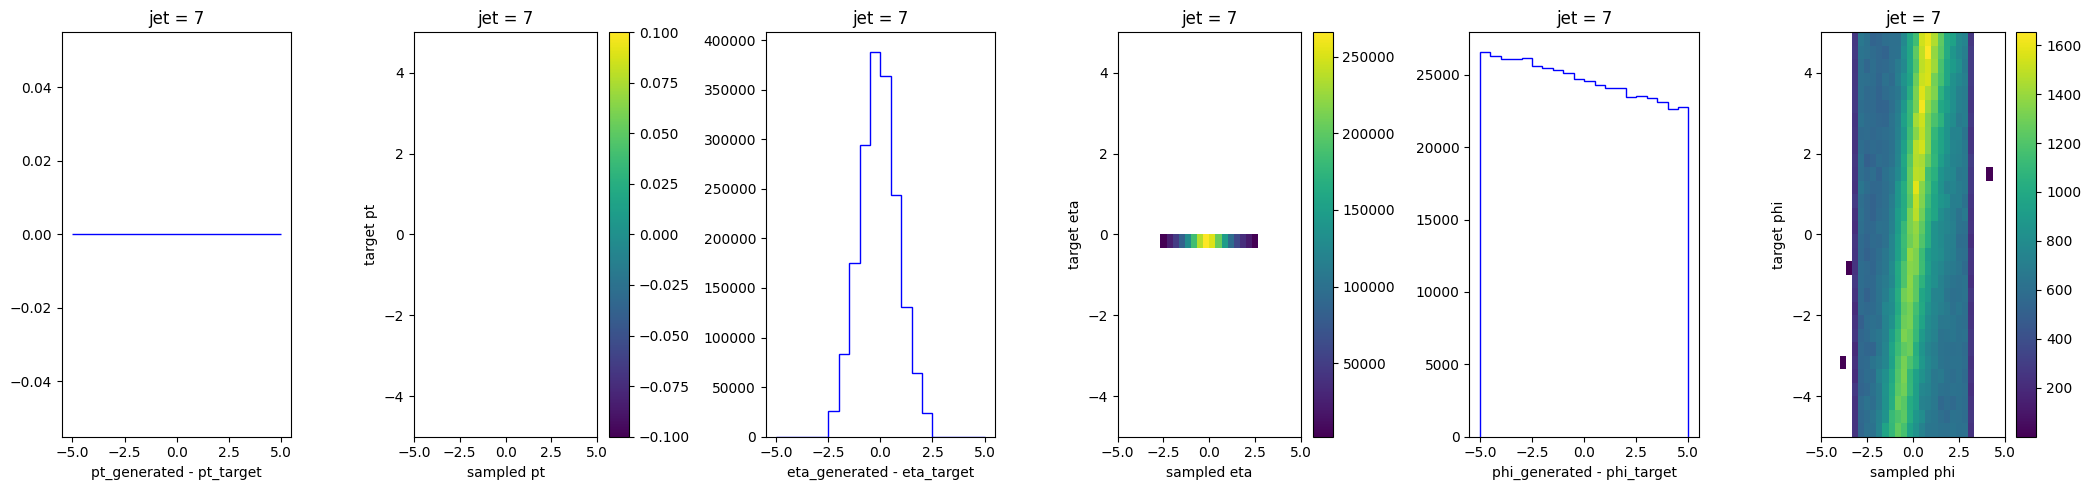

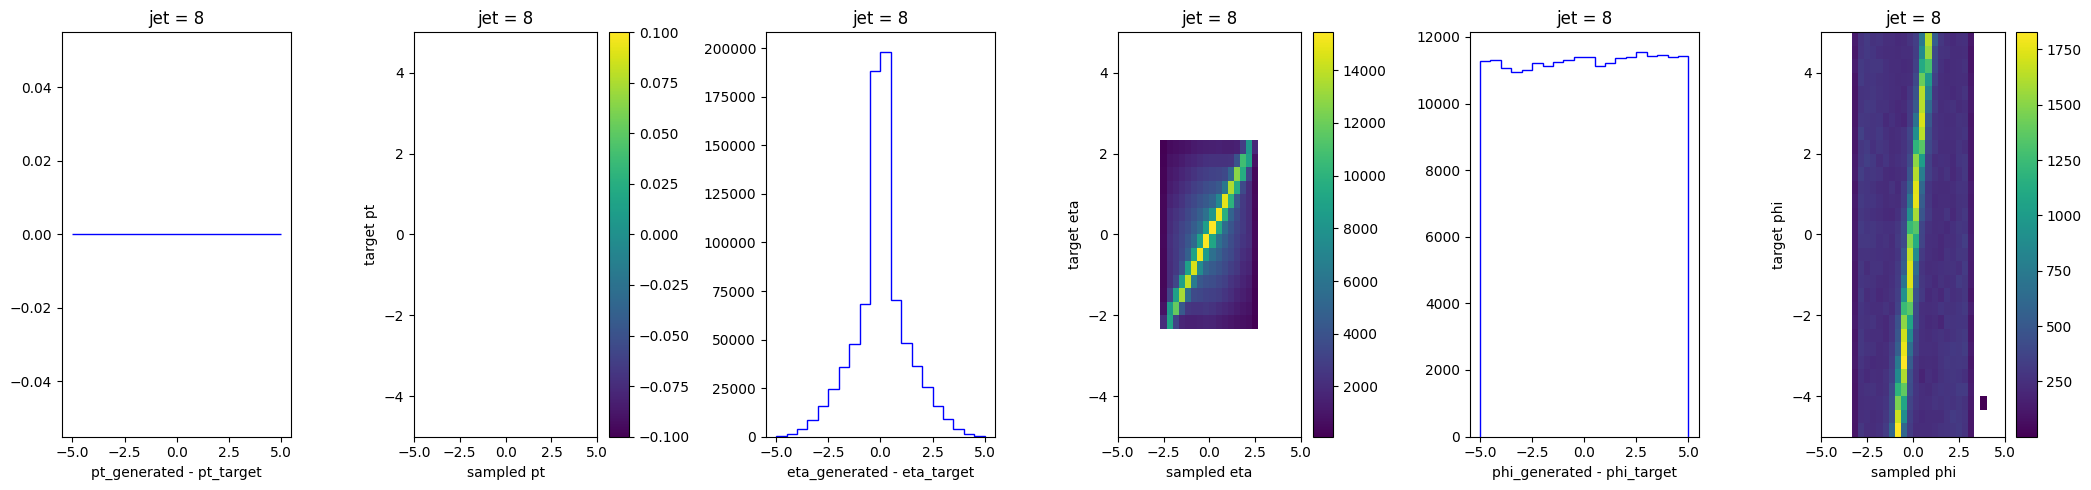

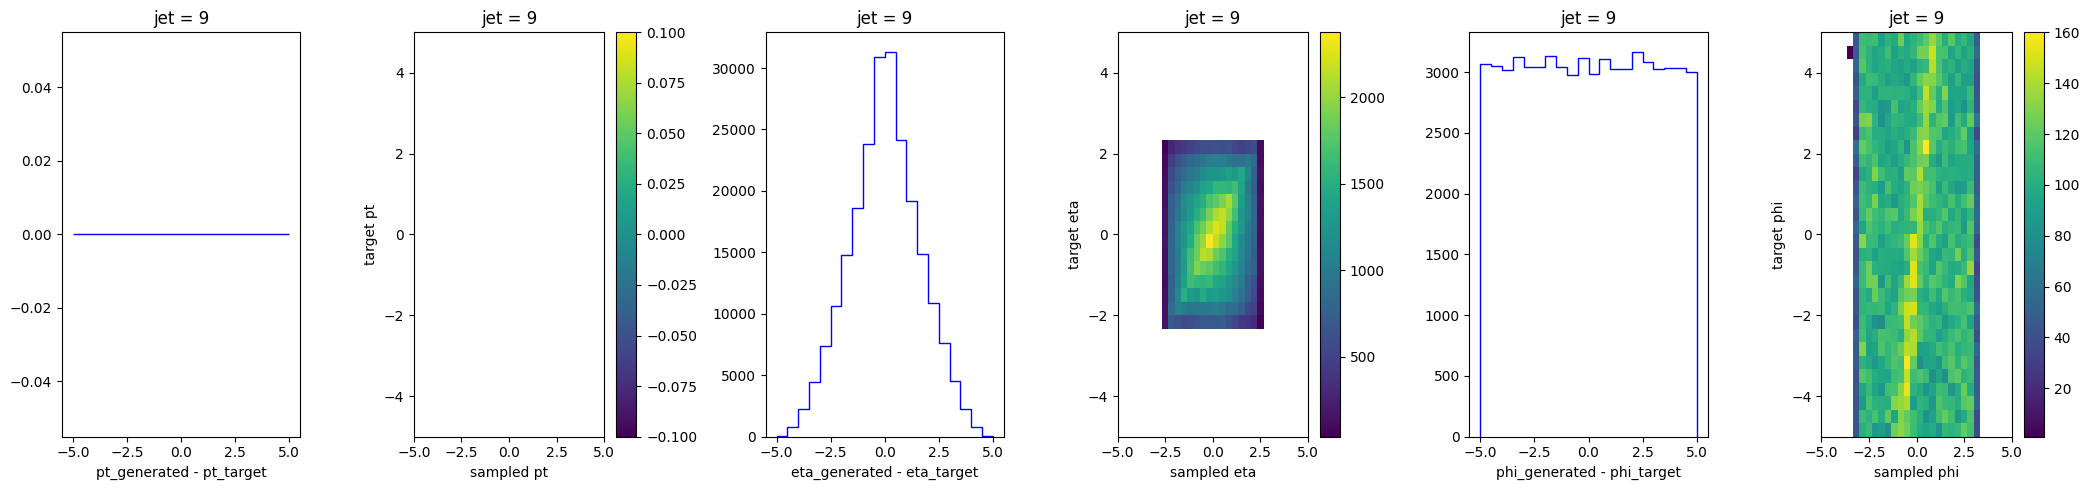

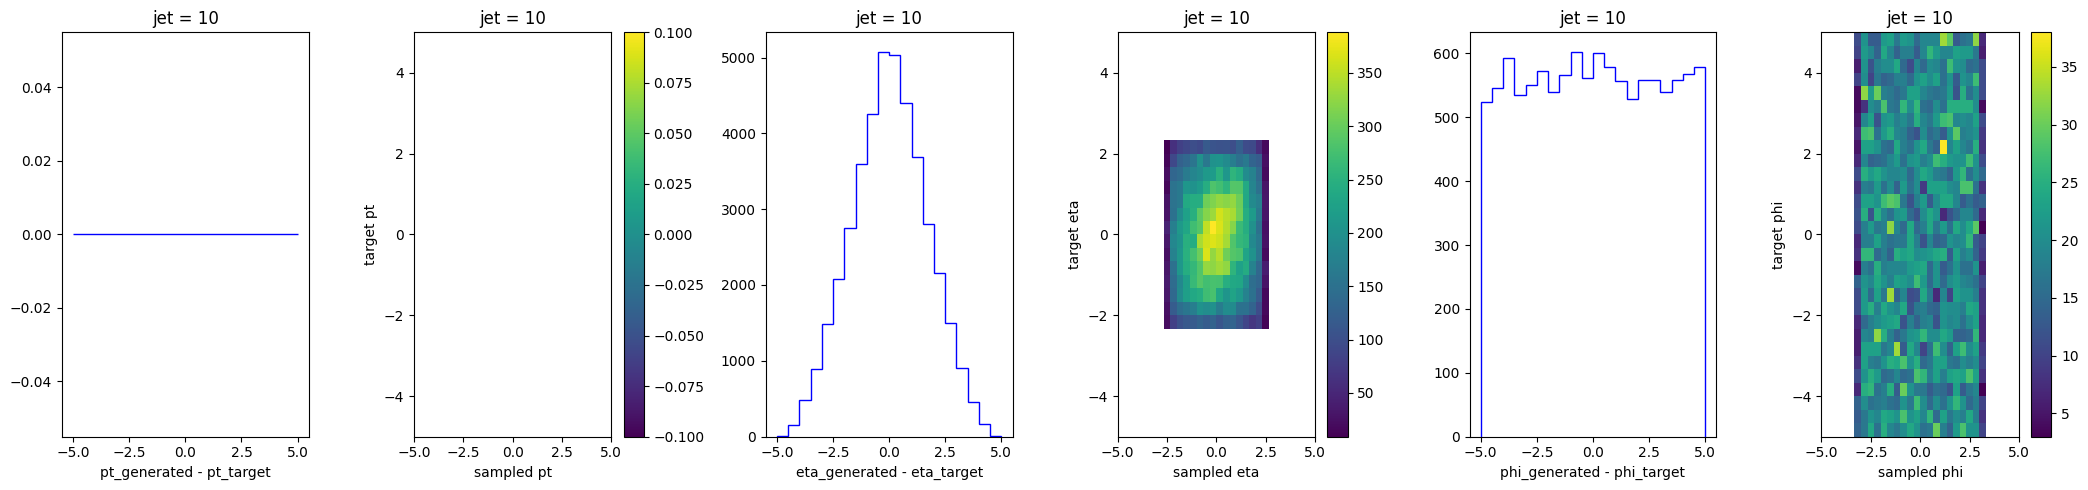

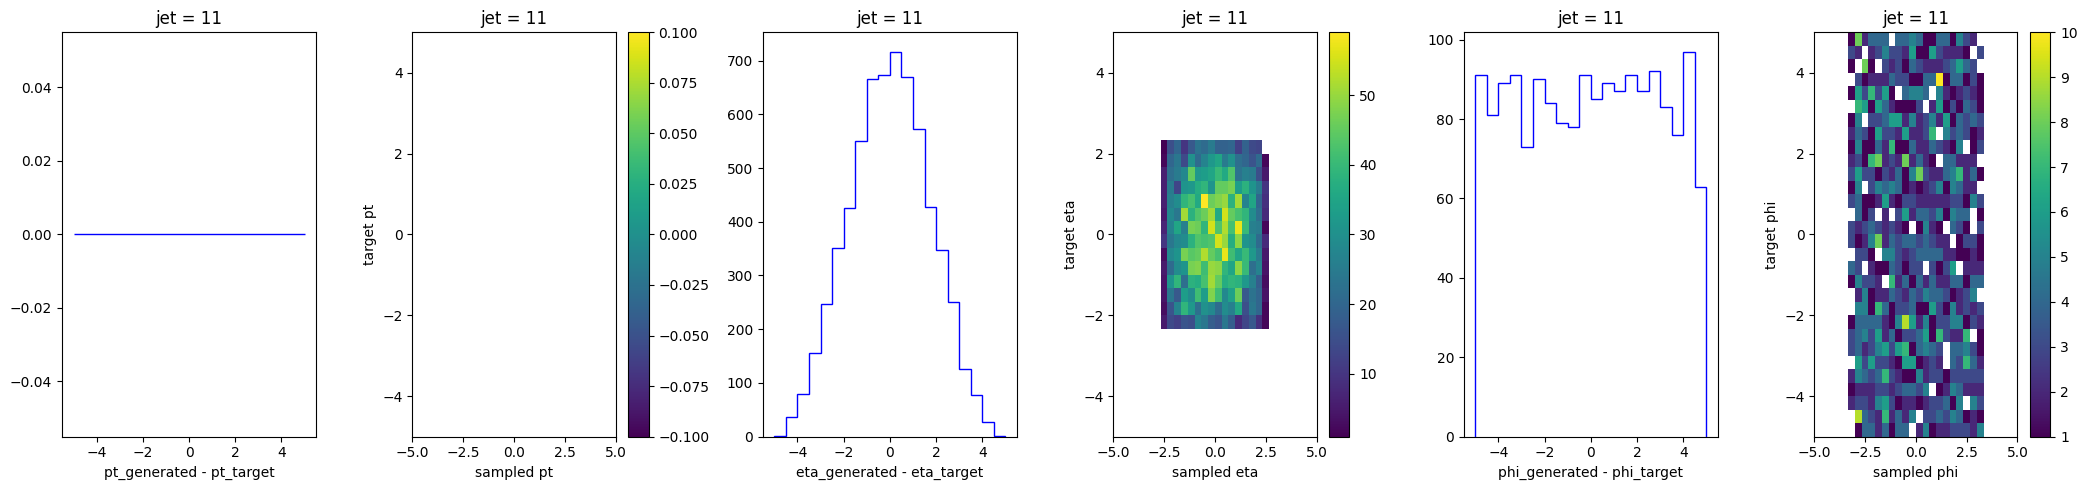

In [148]:
unscaled_target, unscaled_sampled = unscale_var(log_mean_reco, log_std_reco, scaledLogRecoSpanet, sampledEvent)
for i in range(12):
    sampling_print_unscaled(unscaled_sampled, unscaled_target, maskReco, plotJets=i, onlyExistElem=True)

In [147]:
print(unscaled_target[0,:,1])
print(torch.exp(

tensor([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf])


# Sampled Event 2 -- VALIDATION

In [85]:
model_dir = '/eos/user/a/adpetre/www/ttHbbAnalysis/MEMFlow/models_archive/transferFlow_paperVersion-pretrained_2ndVersion_onlyExist_v7/Transfer_Flow_Paper_pretrained_v2_transfer_flow_2nd_2nd_DiagNormal_NoTransf1_NoBins80_DNN:5_512'
path_to_sample = model_dir + '/sampled_jets_valid.pt'
sampledEvent = torch.load(path_to_sample, map_location=device)
print(sampledEvent.shape)
print(scaledLogRecoSpanet.shape)

torch.Size([179213, 12, 5])
torch.Size([179213, 21, 9])


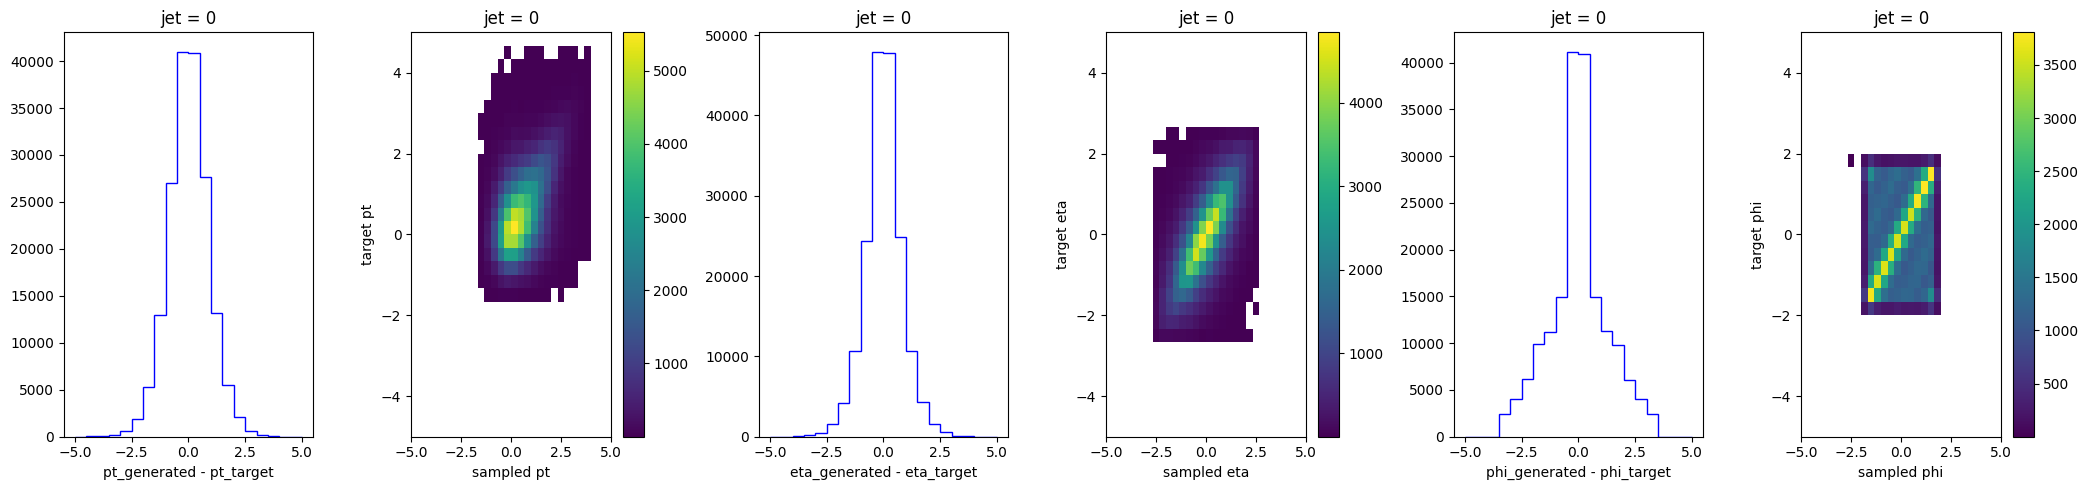

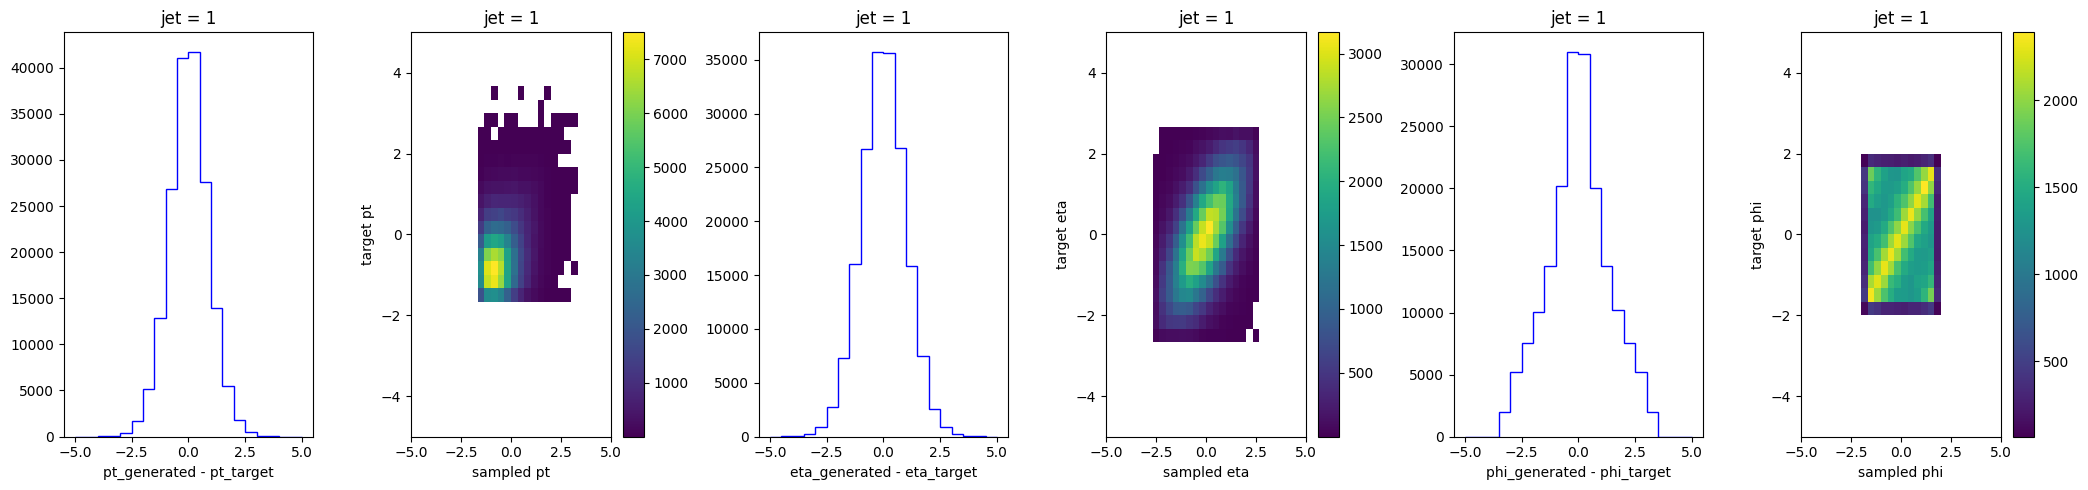

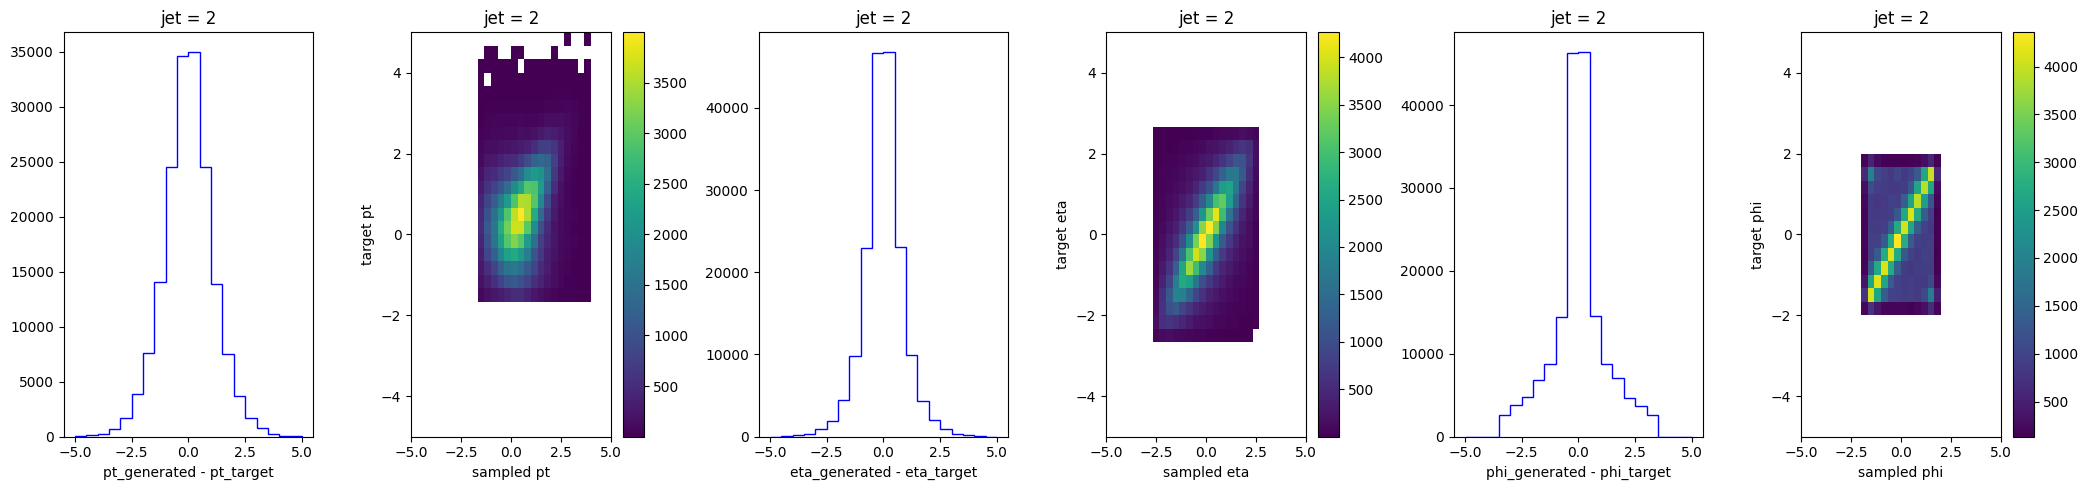

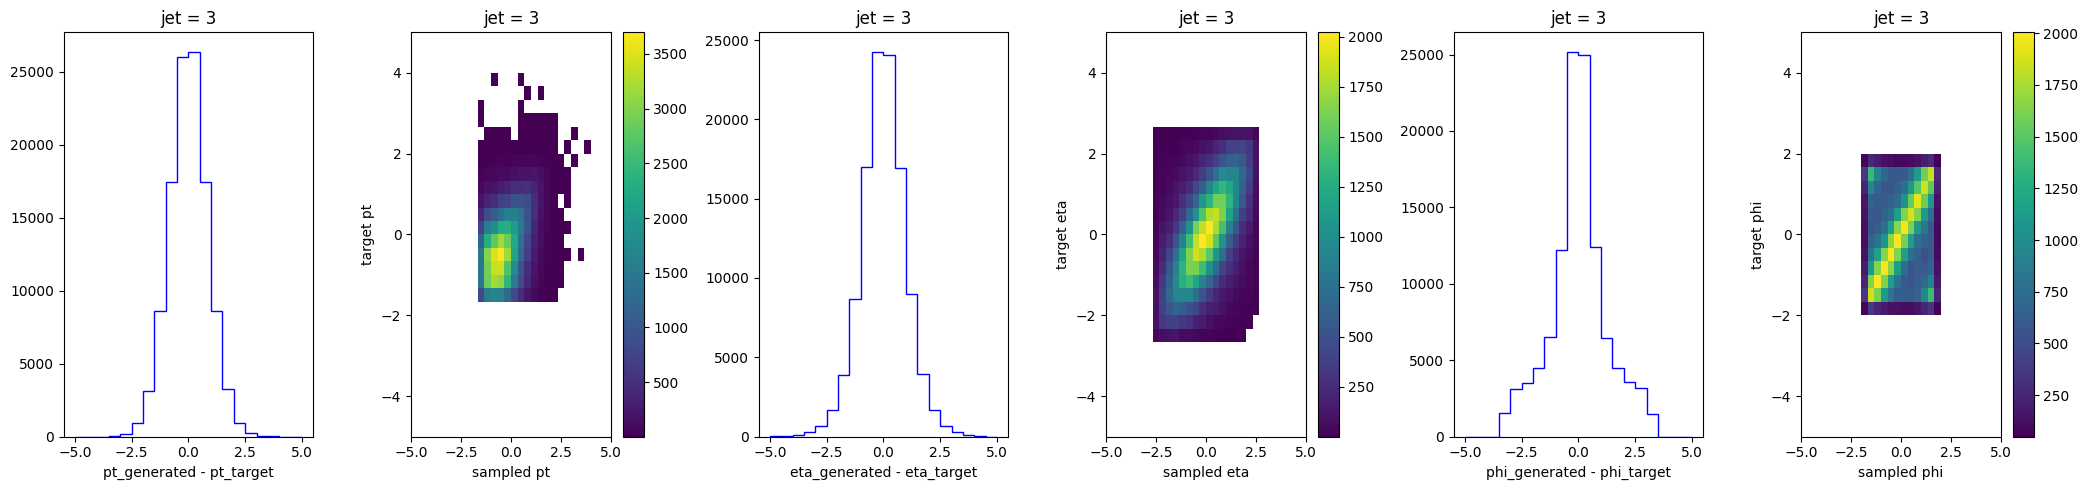

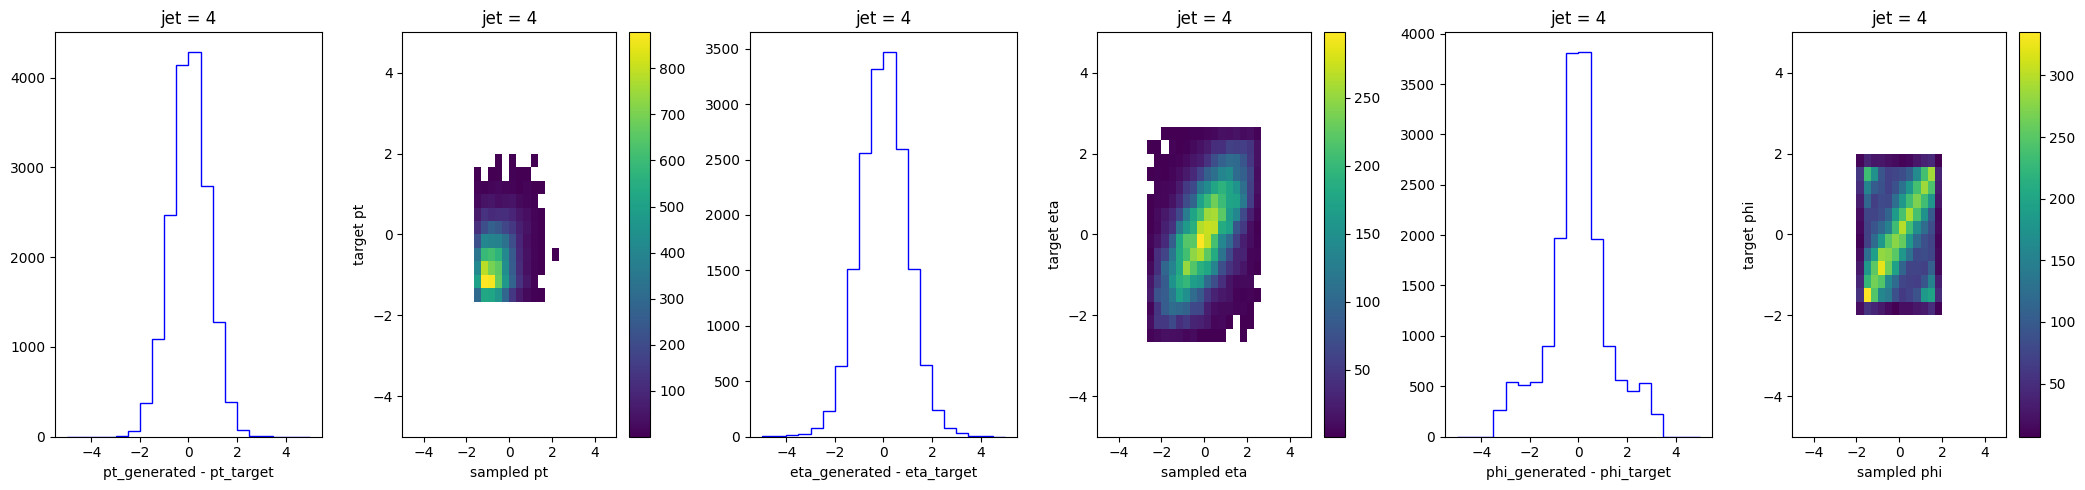

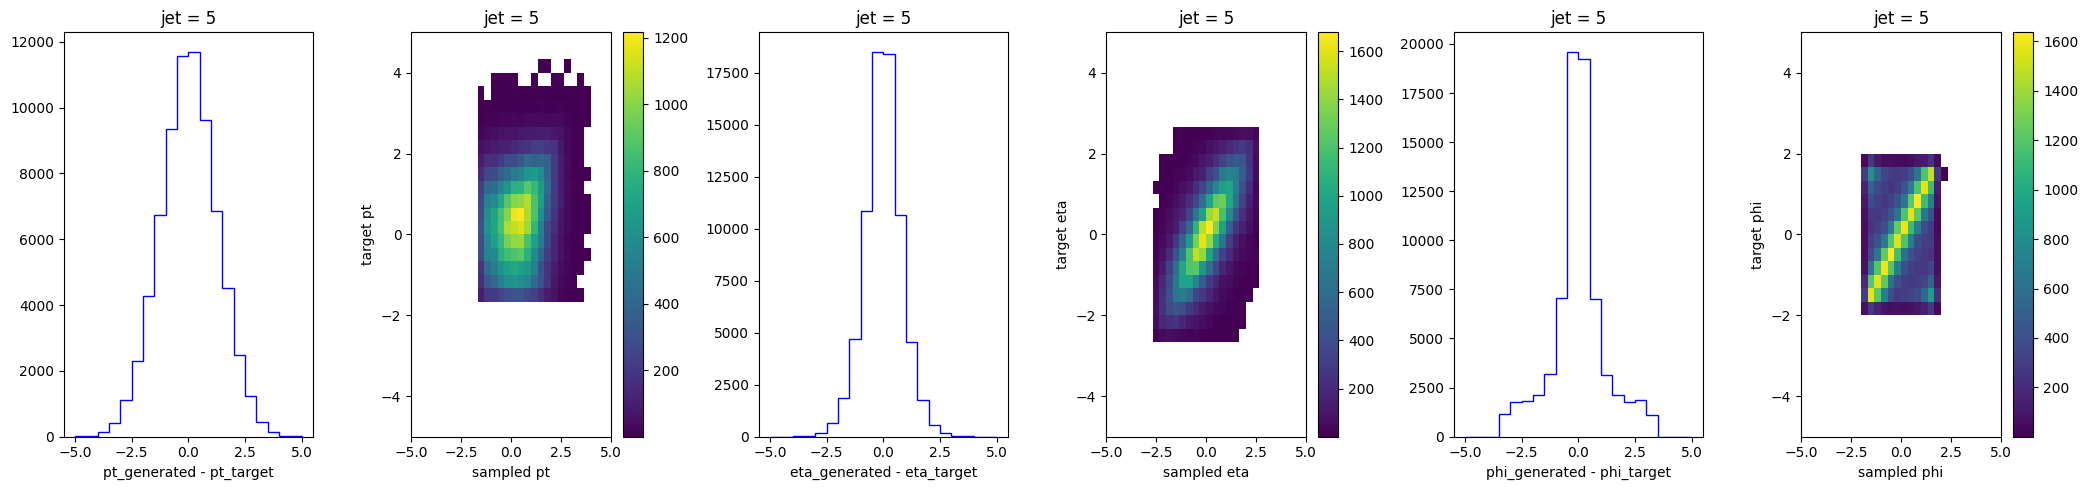

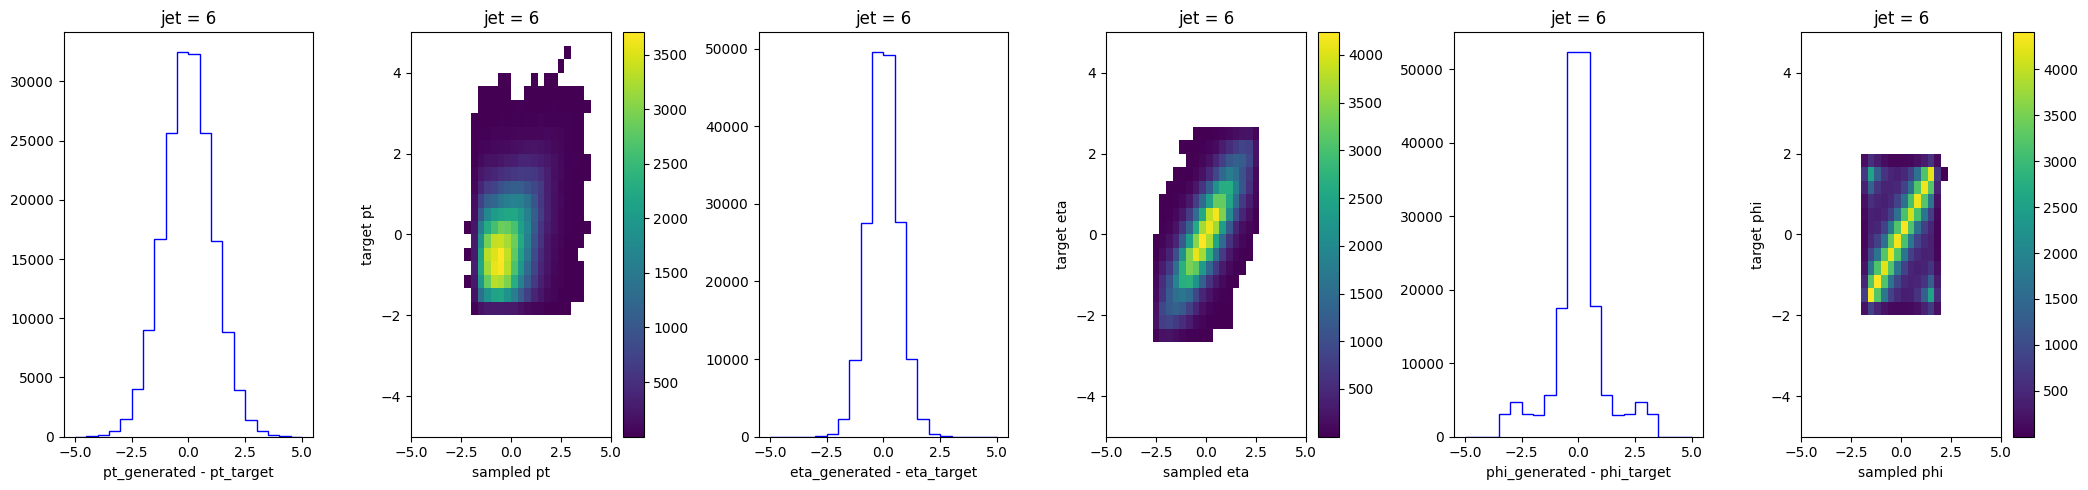

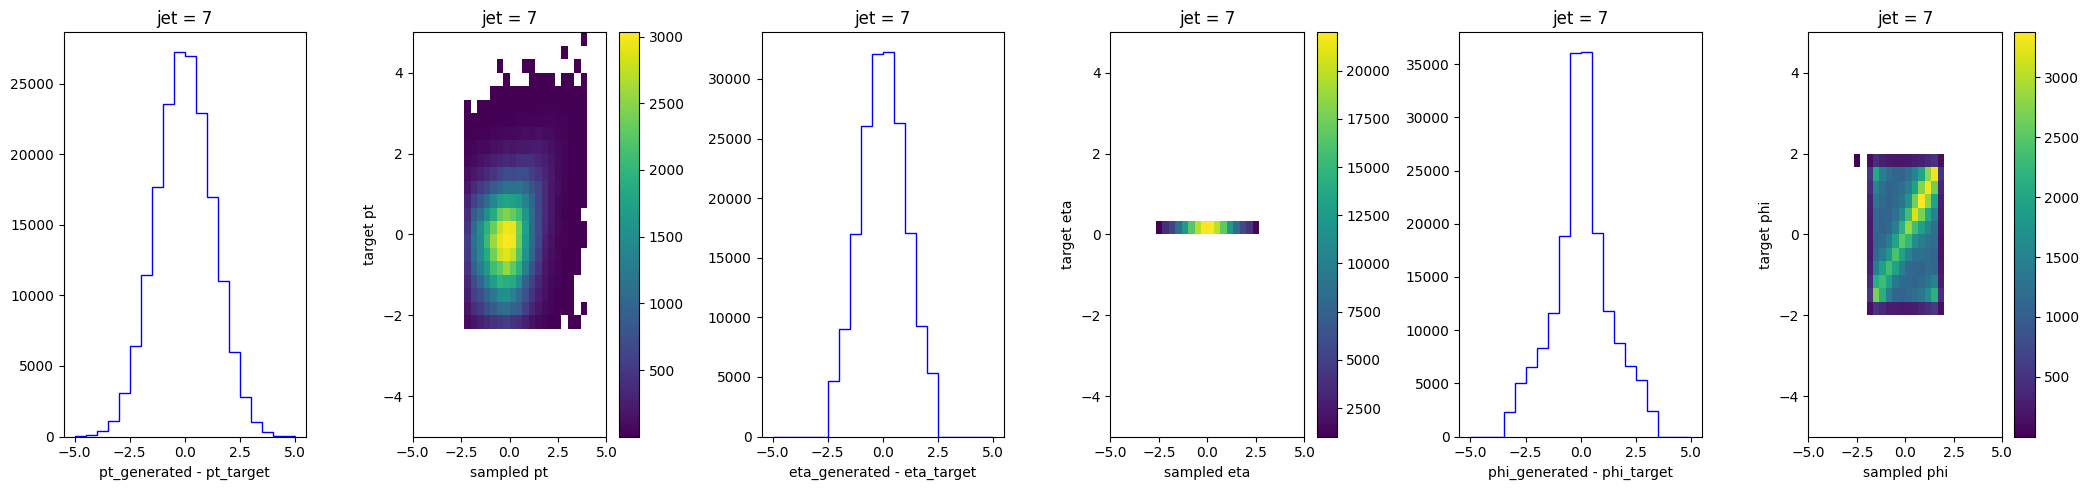

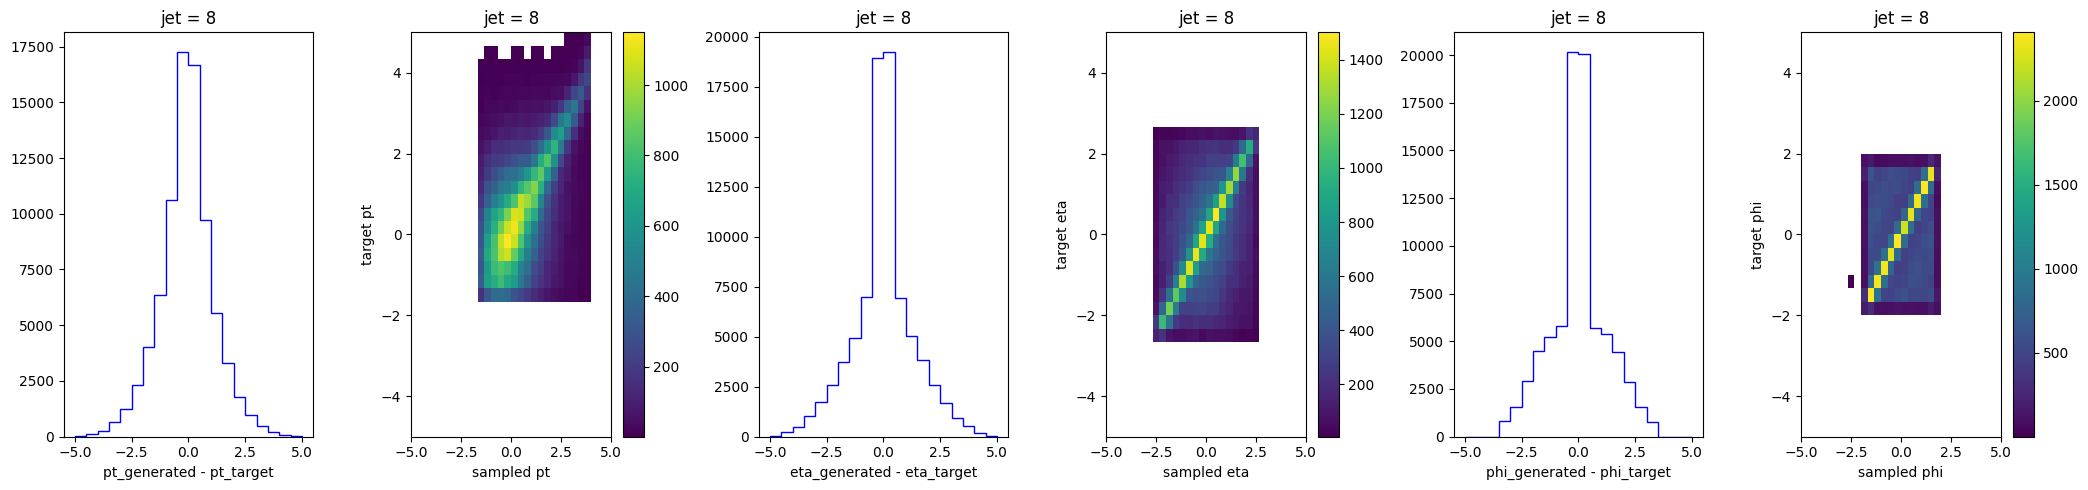

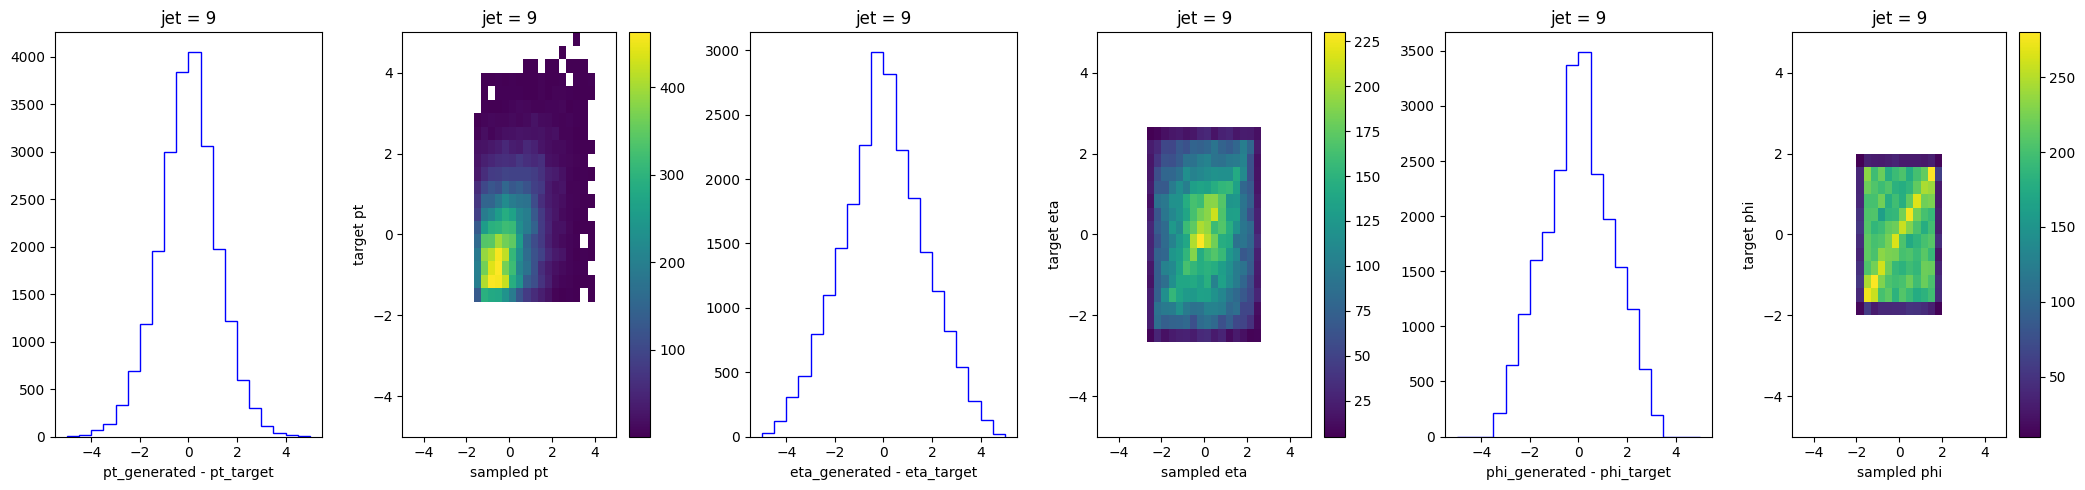

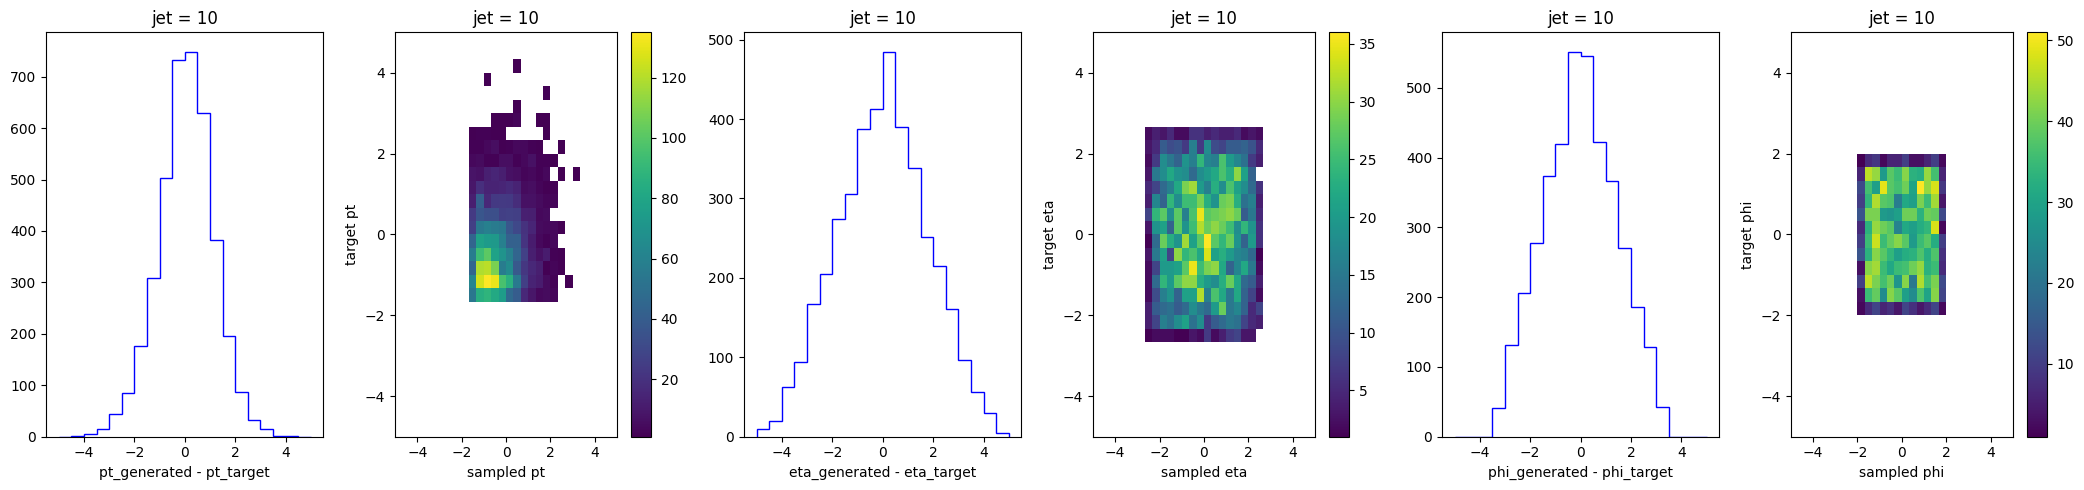

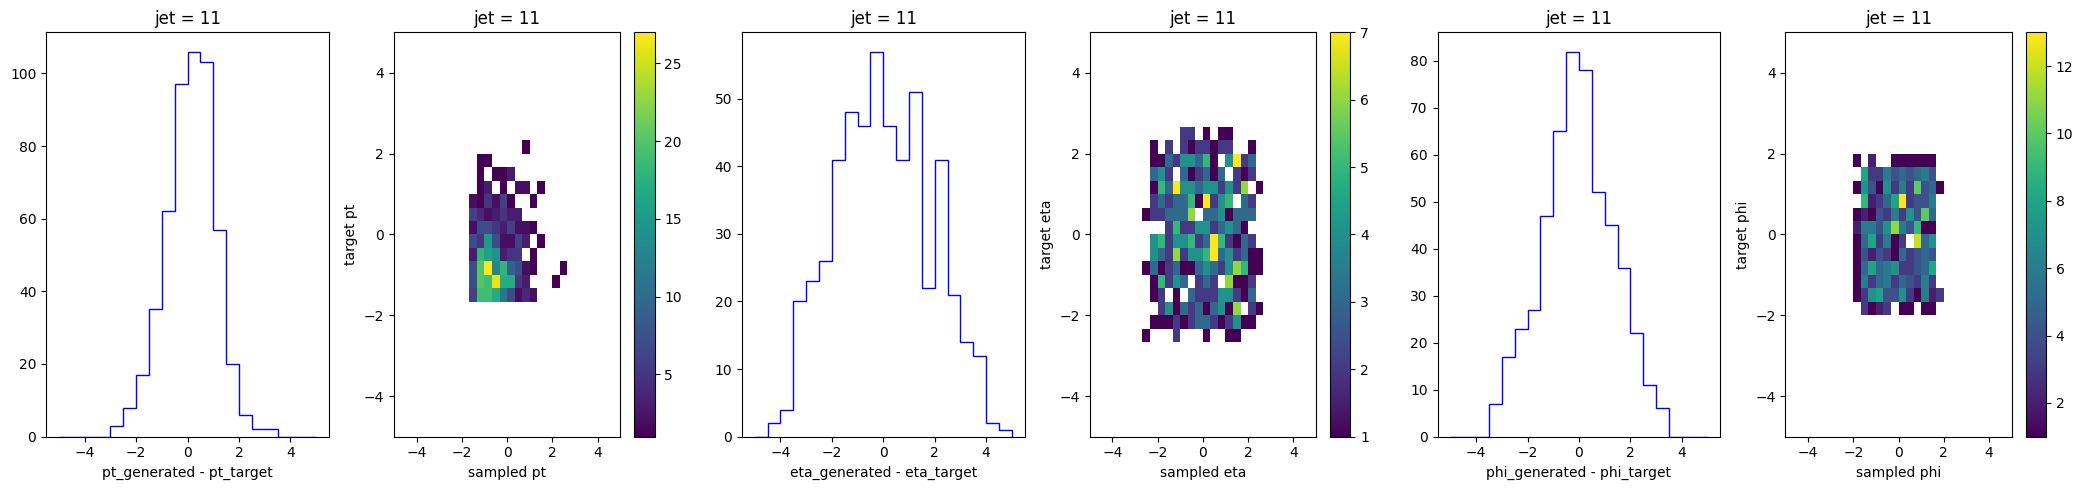

In [86]:
for i in range(12):
    sampling_print(sampledEvent, scaledLogRecoSpanet, maskReco, plotJets=i, onlyExistElem=True)

In [ ]:
unscaled_target, unscaled_sampled = unscale_var(log_mean_reco, log_std_reco, scaledLogRecoSpanet, sampledEvent)
for i in range(12):
    sampling_print_unscaled(unscaled_sampled, unscaled_target, maskReco, plotJets=i, onlyExistElem=True)